# Code accompanying "Mapping Electric Vehicle Impacts: Greenhouse Gas Emissions, Fuel Costs, and Energy Justice in the United States" (2022)
Code author: Jesse Vega-Perkins

LCOC code adapted from code from Borlaug et al. (2020)

# Setup

In [1]:
# Import packages
import sys
import os
analysis = os.path.join('','02_analysis') # update with file path for 02_analysis folder
sys.path.append(analysis)
import importlib
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import scipy
import seaborn as sns
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from IPython.display import display
import xlwings as xw
import glob
import kaleido
import plotly.graph_objects as go

# Import custom modules
import directories as dir
importlib.reload(dir)
import helpers as help
importlib.reload(help)
import calculators as calc
importlib.reload(calc)

# Import LCOC modules
import logging
sys.path.append(os.path.join(dir.cost))
import config
import lcoc.urdb as urdb
import lcoc.afdc as afdc
import lcoc.processing as proc
importlib.reload(urdb)
importlib.reload(proc)

# Seaborn figure settings
sns.set(rc={'figure.dpi':100, 'savefig.dpi':300})
sns.set_theme(context='paper',font_scale=1.2,palette='Dark2')

# Load and Process Data

## General Parameters
Set general parameters for running the analysis.

In [2]:
# Years of analysis
start_year = 2022
cutoff_year = 2050

# GIS projection
# Source: https://epsg.io/102008
projection = 'PROJCS["North_America_Albers_Equal_Area_Conic",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",20.0],PARAMETER["Standard_Parallel_2",60.0],PARAMETER["Latitude_Of_Origin",40.0],UNIT["Meter",1.0]]'

# Sensitivity analysis
pct_sa = 0.1 # percent (in fraction format) to vary variables for sensitivity analyses (sa)
run_sensitivity = True # Specify whether to run sensitivity analysis

# Specify whether to run cost of electricity (COE) and levelized cost of charging (LCOC) calculations. Only necessary if using new data or assumptions that deviate from original analysis (e.g., EIA prices, price projections, new URDB version).
run_COE_LCOC = True

# Specify version of Utility Rate Database (URDB) and Alternative Fuels Data Center (AFDC) datasets to use. If a specific date, this must be specified in the config file. The current setting will download today's version of the datasets.
urdb_afdc_version = 'specific_date' # 'current'

# Determine whether to run direct current fast charging (DCFC) COE calculations, which include the EVI-FAST analysis that takes 3.5-4 hours. Only necessary to re-run if using new data or assumptions that deviate from the original analysis.
# If True, DCFC COE analysis will run
# If False, the results from the previous run will be used
run_DCFC_COE = False

In [3]:
# Fuel consumption (fc) unit conversion to gallons of gasoline equivalent (GGE)
BEV_conversion_factor_GGEpkWH = 0.031 # 0.031 GGE/kWh, source: https://epact.energy.gov/fuel-conversion-factors
fc_conversion = pd.DataFrame(data={'POWERTRAIN':['ICEV','BEV'],'conversion_factor_GGEpGGorkWh':[1,BEV_conversion_factor_GGEpkWH]}) #GGE/gal gasoline = 1

## Geospatial

In [4]:
# Import cartographic boundary shapefiles
# Source: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
state_base = gpd.read_file(os.path.join(dir.p_data,'census_bureau','cb_2019_us_state_500k','cb_2019_us_state_500k.shp'))
state_base.to_crs(crs=projection)
county_base = gpd.read_file(os.path.join(dir.p_data,'census_bureau','cb_2019_us_county_500k','cb_2019_us_county_500k.shp'))
county_base.to_crs(crs=projection)
tract_base = gpd.read_file(os.path.join(dir.p_data,'census_bureau','cb_2019_us_tract_500k','cb_2019_us_tract_500k.shp'))
tract_base.to_crs(crs=projection)

header_cols = {'STATEFP':'state_fips','COUNTYFP':'county_fips'}

state_base.rename(columns=header_cols,inplace=True)
county_base.rename(columns=header_cols,inplace=True)
tract_base.rename(columns=header_cols,inplace=True)
# filter out territories
# 60	AS	American Samoa
# 66	GU	Guam
# 69	MP	Northern Mariana Islands
# 72	PR	Puerto Rico
# 74	UM	U.S. Minor Outlying Island
# 78	VI	U.S. Virgin Islands
state_base.query('state_fips != "60" & state_fips != "66" & state_fips != "69" & state_fips != "72" & state_fips != "74" & state_fips != "78"',inplace=True)
county_base.query('state_fips != "60" & state_fips != "66" & state_fips != "69" & state_fips != "72" & state_fips != "74" & state_fips != "78"',inplace=True)
tract_base.query('state_fips != "60" & state_fips != "66" & state_fips != "69" & state_fips != "72" & state_fips != "74" & state_fips != "78"',inplace=True)
# add lookup columns and drop columns not needed
state_base['state_text'] = 'T' + state_base['GEOID']
county_base['county_text'] = 'T' + county_base['GEOID']
tract_base['tract_text'] = 'T' + tract_base['GEOID']
tract_base['county_text'] = 'T' + tract_base['GEOID'].str[0:5]
county_base.drop(columns=['state_fips','county_fips','COUNTYNS','AFFGEOID','GEOID','NAME','LSAD'],inplace=True)
tract_base.drop(columns=['state_fips','county_fips','TRACTCE','AFFGEOID','GEOID','NAME','LSAD'],inplace=True)
# create county and tract indices
county_base = county_base.sort_values(by='county_text').reset_index(drop=True).reset_index()
county_base.rename(columns={'index':'county_index'},inplace=True)
tract_base = tract_base.sort_values(by=['county_text','tract_text']).reset_index(drop=True).reset_index()
tract_base.rename(columns={'index':'tract_index'},inplace=True)
tract_base = tract_base.merge(county_base[['county_text','county_index']],how='left',on='county_text')

# create basic DFs with county and tract index lookups
# county
county_index = county_base[['county_index','county_text']]
county_index['county_index'] = county_index['county_index'].astype('int16')
county_index['county_text'] = county_index['county_text'].astype('category')

# county and tract
tract_county_index = tract_base[['county_index','tract_index','county_text','tract_text']]
tract_county_index['county_index'] = tract_county_index['county_index'].astype('int16')
tract_county_index['tract_index'] = tract_county_index['tract_index'].astype('int32')
tract_county_index['county_text'] = tract_county_index['county_text'].astype('category')
tract_county_index['tract_text'] = tract_county_index['tract_text'].astype('category')

## US Census Data

In [5]:
census_na_values = ['**','-','+','***','*****','N','(X)']

### FIPS

In [6]:
# US Census state and county fips data (downloaded from https://www.census.gov/library/reference/code-lists/ansi.html)
# County FIPS and name changes documented here: https://www.cdc.gov/nchs/data/nvss/bridged_race/County-Geography-Changes-1990-present.pdf

fips_state_county = help.state_county_FIPS(fips_state_file_path=os.path.join(dir.p_data,'census_bureau','fips_state.txt'),
                                            fips_state_county_file_path=os.path.join(dir.p_data,'census_bureau','national_county.txt'))
fips_state_county = fips_state_county.merge(county_index,how='left',on='county_text')

### Region and Division Codes

In [7]:
# US Census Bureau Region and Division Codes
# Source: https://www2.census.gov/programs-surveys/popest/geographies/2019/state-geocodes-v2019.xlsx
## Load raw data
census_rd_dtypes = {'Region':object,'Division':object,'State (FIPS)':object,'Name':object}
census_rd_raw = pd.read_excel(os.path.join(dir.p_data,'census_bureau','state-geocodes-v2019.xlsx'),skiprows=5)
## Subset regions
census_r = census_rd_raw[['Region','Name']].drop_duplicates(subset='Region').reset_index(drop=True)
census_r.rename(columns={'Name':'Region_Name'},inplace=True)
## Subset divisions
census_d = census_rd_raw[census_rd_raw['Division']!=0]
census_d = census_d[['Division','Name']].drop_duplicates(subset='Division').reset_index(drop=True)
census_d.rename(columns={'Name':'Division_Name'},inplace=True)
## Regions and divisions by state
state_rd = census_rd_raw[census_rd_raw['State (FIPS)']!=0].reset_index(drop=True)
state_rd.rename(columns={'Name':'state_name'},inplace=True)
state_rd = state_rd.merge(census_r,how='left',on='Region',validate='many_to_one')
state_rd = state_rd.merge(census_d,how='left',on='Division',validate='many_to_one')
help.fixGEOID(state_rd,'State (FIPS)','state_text',2)
## Regions and divisions by county
county_rd = fips_state_county[['county_index','county_text','state_text']].merge(state_rd,how='left',on='state_text')

c:\Anaconda3\envs\ev_impacts_env\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


### Housing Units, Population, Income

In [8]:
# US Census - 2018 5-YR ACS data
# Downloaded from https://data.census.gov/cedsci/
# B01003 - Total Population
# B19013 - Median Household Income in the Past 12 Months
# B25001 - Housing units
# B25003 - Households
# B26001 - Group quarter population

# Total Population (2018 5YR ACS Table B01003)
tot_pop_dtypes = {'B01003_001E':'float64','B01003_001M':'float64'}
## county-level
county_tot_pop_raw = pd.read_csv(os.path.join(dir.p_data,'census_bureau','ACSDT5Y2018.B01003_2022-06-09T155532','ACSDT5Y2018.B01003_data_with_overlays_2022-05-31T210929.csv'),skiprows={1},na_values=census_na_values)
county_tot_pop_raw = county_tot_pop_raw.astype(dtype=tot_pop_dtypes)
county_tot_pop_raw.rename(columns={'B01003_001E':'pop_US'},inplace=True)
county_tot_pop_raw['county_text'] = 'T'+county_tot_pop_raw['GEO_ID'].str[-5:]
county_tot_pop_raw['state_text'] = county_tot_pop_raw['county_text'].str[:3]
county_tot_pop_raw = county_tot_pop_raw.merge(county_index,how='left',on='county_text')
county_tot_pop = county_tot_pop_raw.query('state_text != "T60" & state_text != "T66" & state_text != "T69" & state_text != "T72" & state_text != "T74" & state_text != "T78"')
county_tot_pop['county_index'] = county_tot_pop['county_index'].astype('int16')
county_tot_pop['mult_pop_US'] = county_tot_pop['pop_US'] / county_tot_pop['pop_US'].sum()
county_tot_pop = county_tot_pop[['county_index','pop_US','mult_pop_US']]
## tract-level
tract_tot_pop_raw = pd.read_csv(os.path.join(dir.p_data,'census_bureau','ACSDT5Y2018.B01003_2022-01-22T095145','ACSDT5Y2018.B01003_data_with_overlays_2022-01-22T094945.csv'),skiprows={1},na_values=census_na_values)
tract_tot_pop_raw = tract_tot_pop_raw.astype(dtype=tot_pop_dtypes)
tract_tot_pop_raw.rename(columns={'B01003_001E':'pop_US'},inplace=True)
tract_tot_pop_raw['tract_text'] = 'T'+tract_tot_pop_raw['GEO_ID'].str[-11:]
tract_tot_pop_raw['county_text'] = tract_tot_pop_raw['tract_text'].str[:6]
tract_tot_pop_raw['state_text'] = tract_tot_pop_raw['tract_text'].str[:3]
tract_tot_pop_raw = tract_tot_pop_raw.merge(tract_county_index,how='left',on=['county_text','tract_text'])
tract_tot_pop = tract_tot_pop_raw.query('state_text != "T60" & state_text != "T66" & state_text != "T69" & state_text != "T72" & state_text != "T74" & state_text != "T78"')
tract_tot_pop.dropna(inplace=True)
tract_tot_pop['county_index'] = tract_tot_pop['county_index'].astype('int16')
tract_tot_pop['tract_index'] = tract_tot_pop['tract_index'].astype('int32')
tract_tot_pop['mult_pop_US'] = tract_tot_pop['pop_US'] / tract_tot_pop['pop_US'].sum()
tract_tot_pop = tract_tot_pop[['county_index','tract_index','pop_US','mult_pop_US']]

# Median HH income (2018 5YR ACS Table B19013)
## tract-level
med_hh_income_dtypes = {'B19013_001E':'float64','B19013_001M':'float64'}
tract_med_hh_income_raw = pd.read_csv(os.path.join(dir.p_data,'census_bureau','ACSDT5Y2018.B19013_2021-12-14T161318','ACSDT5Y2018.B19013_data_with_overlays_2021-12-14T161248.csv'),skiprows={1},na_values=census_na_values)
tract_med_hh_income_raw.replace(to_replace='250,000+',value=250000,inplace=True)
tract_med_hh_income_raw.replace(to_replace='2,500-',value=2500,inplace=True)
tract_med_hh_income_raw = tract_med_hh_income_raw.astype(dtype=med_hh_income_dtypes)
tract_med_hh_income_raw.rename(columns={'B19013_001E':'med_hh_income'},inplace=True)
tract_med_hh_income_raw['tract_text'] = 'T'+tract_med_hh_income_raw['GEO_ID'].str[-11:]
tract_med_hh_income_raw['county_text'] = tract_med_hh_income_raw['tract_text'].str[:6]
tract_med_hh_income_raw['state_text'] = tract_med_hh_income_raw['tract_text'].str[:3]
tract_med_hh_income_raw = tract_med_hh_income_raw.merge(tract_county_index,how='left',on=['county_text','tract_text'])
tract_med_hh_income = tract_med_hh_income_raw.query('state_text != "T60" & state_text != "T66" & state_text != "T69" & state_text != "T72" & state_text != "T74" & state_text != "T78"')
tract_med_hh_income.dropna(inplace=True)
tract_med_hh_income['county_index'] = tract_med_hh_income['county_index'].astype('int16')
tract_med_hh_income['tract_index'] = tract_med_hh_income['tract_index'].astype('int32')

## Housing units (2018 5YR ACS Table B25001)
# county-level
county_tot_hu_raw = pd.read_csv(os.path.join(dir.p_data,'census_bureau','ACSDT5Y2018.B25001_2022-06-19T140058','ACSDT5Y2018.B25001_data_with_overlays_2022-06-19T140018.csv'),skiprows={1},na_values=census_na_values)
county_tot_hu_raw.rename(columns={'B25001_001E':'total_hu'},inplace=True)
county_tot_hu_raw['county_text'] = 'T'+county_tot_hu_raw['GEO_ID'].str[-5:]
county_tot_hu_raw['state_text'] = county_tot_hu_raw['county_text'].str[:3]
county_tot_hu_raw = county_tot_hu_raw.merge(county_index,how='left',on='county_text')
county_tot_hu = county_tot_hu_raw.query('state_text != "T60" & state_text != "T66" & state_text != "T69" & state_text != "T72" & state_text != "T74" & state_text != "T78"')
county_tot_hu['county_index'] = county_tot_hu['county_index'].astype('int16')
# tract-level
tract_tot_hu_raw = pd.read_csv(os.path.join(dir.p_data,'census_bureau','ACSDT5Y2018.B25001_2022-03-12T170747','ACSDT5Y2018.B25001_data_with_overlays_2022-03-12T164029.csv'),skiprows={1},na_values=census_na_values)
tract_tot_hu_raw.rename(columns={'B25001_001E':'total_hu'},inplace=True)
tract_tot_hu_raw['tract_text'] = 'T'+tract_tot_hu_raw['GEO_ID'].str[-11:]
tract_tot_hu_raw['county_text'] = tract_tot_hu_raw['tract_text'].str[:6]
tract_tot_hu_raw['state_text'] = tract_tot_hu_raw['tract_text'].str[:3]
tract_tot_hu_raw = tract_tot_hu_raw.merge(tract_county_index,how='left',on=['county_text','tract_text'])
tract_tot_hu = tract_tot_hu_raw.query('state_text != "T60" & state_text != "T66" & state_text != "T69" & state_text != "T72" & state_text != "T74" & state_text != "T78"')
tract_tot_hu.dropna(inplace=True)
tract_tot_hu['county_index'] = tract_tot_hu['county_index'].astype('int16')
tract_tot_hu['tract_index'] = tract_tot_hu['tract_index'].astype('int32')

# Number of households (2018 5YR ACS Table B25003)
## tract-level
tract_tot_hh_raw = pd.read_csv(os.path.join(dir.p_data,'census_bureau','ACSDT5Y2018.B25003_2022-01-09T124302','ACSDT5Y2018.B25003_data_with_overlays_2022-01-09T124158.csv'),skiprows={1})
tract_tot_hh_raw.rename(columns={'B25003_001E':'total_hh'},inplace=True)
tract_tot_hh_raw['tract_text'] = 'T'+tract_tot_hh_raw['GEO_ID'].str[-11:]
tract_tot_hh_raw['county_text'] = tract_tot_hh_raw['tract_text'].str[:6]
tract_tot_hh_raw['state_text'] = tract_tot_hh_raw['tract_text'].str[:3]
tract_tot_hh_raw = tract_tot_hh_raw.merge(tract_county_index,how='left',on=['county_text','tract_text'])
tract_tot_hh = tract_tot_hh_raw.query('state_text != "T60" & state_text != "T66" & state_text != "T69" & state_text != "T72" & state_text != "T74" & state_text != "T78"')
tract_tot_hh.dropna(inplace=True)
tract_tot_hh['tract_index'] = tract_tot_hh['tract_index'].astype('int32')
tract_tot_hh = tract_tot_hh[['tract_index','tract_text','total_hh']]

# Population in group quarters (2018 5YR ACS Table B26001)
## tract-level
tract_group_qtr_pop_raw = pd.read_csv(os.path.join(dir.p_data,'census_bureau','ACSDT5Y2018.B26001_2022-06-15T095636','ACSDT5Y2018.B26001_data_with_overlays_2022-06-15T095339.csv'),skiprows={1},na_values=census_na_values)
tract_group_qtr_pop_raw.rename(columns={'B26001_001E':'grp_qtr_pop_US'},inplace=True)
tract_group_qtr_pop_raw['tract_text'] = 'T'+tract_group_qtr_pop_raw['GEO_ID'].str[-11:]
tract_group_qtr_pop_raw['county_text'] = tract_group_qtr_pop_raw['tract_text'].str[:6]
tract_group_qtr_pop_raw['state_text'] = tract_group_qtr_pop_raw['tract_text'].str[:3]
tract_group_qtr_pop_raw = tract_group_qtr_pop_raw.merge(tract_county_index,how='left',on=['county_text','tract_text'])
tract_group_qtr_pop = tract_group_qtr_pop_raw.query('state_text != "T60" & state_text != "T66" & state_text != "T69" & state_text != "T72" & state_text != "T74" & state_text != "T78"')
tract_group_qtr_pop = tract_group_qtr_pop[['tract_index','grp_qtr_pop_US']]
tract_group_qtr_pop.dropna(inplace=True)
tract_group_qtr_pop['tract_index'] = tract_group_qtr_pop['tract_index'].astype('int32')

# combine population count, HH count, and group quarters count
tract_pop_hh = tract_tot_pop.merge(tract_tot_hh,how='left',on='tract_index')
tract_pop_hh = tract_pop_hh.merge(tract_group_qtr_pop,how='left',on='tract_index')
tract_pop_hh['pop_grp_qtr'] = tract_pop_hh['pop_US']==tract_pop_hh['grp_qtr_pop_US']
tract_pop_hh['county_index'] = tract_pop_hh['county_index'].astype('int16')
tract_pop_hh['tract_index'] = tract_pop_hh['tract_index'].astype('int32')

## NCHS Urban-Rural Classification

In [9]:
# NCHS Urban-Rural Classification Scheme for Counties
# Source: https://www.cdc.gov/nchs/data_access/urban_rural.htm
fips_county_urbrur_dtype = {'FIPS code':object}
fips_county_urbrur = pd.read_excel(os.path.join(dir.p_data,'cdc','NCHSURCodes2013.xlsx'),dtype=fips_county_urbrur_dtype)
help.fixGEOID(fips_county_urbrur,'FIPS code','county_text',5)
fips_county_urbrur = fips_county_urbrur.merge(county_index,how='left',on='county_text')
urbrur_code_dict = {1:'01 - Large central metro',2:'02 - Large fringe metro',3:'03 - Medium metro',4:'04 - Small metro',5:'05 - Micropolitan',6:'06 - Noncore'}
fips_county_urbrur.rename(columns={'2013 code':'UR_code'},inplace=True)
fips_county_urbrur['UR_code_name'] = fips_county_urbrur['UR_code'].map(urbrur_code_dict)
fips_county_urbrur = fips_county_urbrur.dropna(subset=['county_index'])

## HUD Area Median Income

In [10]:
# Read in and process HUD AMI data
# Source: https://www.huduser.gov/portal/datasets/il.html#2018_data
county_ami = pd.read_excel(os.path.join(dir.p_data,'hud','Section8-FY18.xlsx'),dtype={'fips2010':str,'State':str,'County':str})
county_ami = county_ami[['fips2010','median2018']]
county_ami['fips_STCOU'] = county_ami['fips2010'].str[:-5]
county_ami['county_text'] = 'T' + county_ami['fips_STCOU']
county_ami['cousub_text'] = np.where(county_ami['fips2010'].str[-5:]=='99999',np.nan,'T'+county_ami['fips2010'])
county_ami_COU = county_ami[county_ami['cousub_text'].isna()]
county_ami_COUSUB = county_ami.dropna(subset=['cousub_text'])

# Read in and process IPUMS NHGIS county subdivision / tract crosswalk file
tract_cousub_lookup_0 = pd.read_csv(os.path.join(dir.p_data,'ipums_nhgis','nhgis0002_csv','nhgis0002_ds171_2010_tract_730.csv'),encoding='latin_1',low_memory=False,
                                    dtype={'STATEA':str,'COUNTYA':str,'COUSUBA':str,'PLACEA':str,'TRACTA':str})
tract_cousub_lookup = tract_cousub_lookup_0[['STATE','STATEA','COUNTY','COUNTYA','COUSUB','COUSUBA','TRACTA','H7Q001']].groupby(by=['STATE','STATEA','COUNTY','COUNTYA','COUSUB','COUSUBA','TRACTA'],as_index=False).sum()

# County name and number changes
tract_cousub_lookup.loc[(tract_cousub_lookup['STATEA']=="46")&(tract_cousub_lookup['COUNTYA']=="113"),'COUNTYA'] = '102' # Shannon County, SD renamed and renumbered in 2015
tract_cousub_lookup.loc[(tract_cousub_lookup['STATEA']=="46")&(tract_cousub_lookup['COUNTYA']=="102"),'COUNTY'] = 'Oglala Lakota County' # Shannon County, SD renamed and renumbered in 2015
tract_cousub_lookup.loc[(tract_cousub_lookup['STATEA']=="51")&(tract_cousub_lookup['COUNTYA']=="515"),'COUNTYA'] = '019' # Bedford City (51515) merged with Bedford County in 2013
tract_cousub_lookup.loc[(tract_cousub_lookup['STATEA']=="51")&(tract_cousub_lookup['COUNTYA']=="019"),'COUNTY'] = 'Bedford County' # Bedford City (51515) merged with Bedford County in 2013
tract_cousub_lookup.loc[(tract_cousub_lookup['STATEA']=='02') & (tract_cousub_lookup['COUNTYA']=='270'),'COUNTYA'] = '158' # Effective July 1, 2015, Wade Hampton Census Area (FIPS code=02270) was renamed Kusilvak Census Area and assigned a new FIPS code
tract_cousub_lookup.loc[(tract_cousub_lookup['STATEA']=='02') & (tract_cousub_lookup['COUNTYA']=='158'),'COUNTY'] = 'Kusilvak Census Area' # Effective July 1, 2015, Wade Hampton Census Area (FIPS code=02270) was renamed Kusilvak Census Area and assigned a new FIPS code

# Additional lookup columns
tract_cousub_lookup['county_text'] = 'T' + tract_cousub_lookup['STATEA'] + tract_cousub_lookup['COUNTYA']
tract_cousub_lookup['cousub_text'] = 'T' + tract_cousub_lookup['STATEA'] + tract_cousub_lookup['COUNTYA'] + tract_cousub_lookup['COUSUBA']
tract_cousub_lookup['tract_text'] = 'T' + tract_cousub_lookup['STATEA'] + tract_cousub_lookup['COUNTYA'] + tract_cousub_lookup['TRACTA']

# Get AMI at tract level
tract_cousub_ami = tract_cousub_lookup.merge(county_ami_COU[['county_text','median2018']],how='left',on='county_text')
tract_cousub_ami = tract_cousub_ami.merge(county_ami_COUSUB[['cousub_text','median2018']],how='left',on='cousub_text',suffixes=['_cou','_cousub'])
tract_cousub_ami['median2018'] = np.where(tract_cousub_ami['median2018_cou'].isna(),tract_cousub_ami['median2018_cousub'],tract_cousub_ami['median2018_cou'])
tract_cousub_ami.set_index('tract_text',inplace=True)
tract_cousub_ami['tract_pop_tot'] = tract_cousub_ami[['H7Q001']].groupby(level=0).sum()
tract_cousub_ami.reset_index(inplace=True)
tract_cousub_ami['median2018_wt'] = tract_cousub_ami['median2018'] * tract_cousub_ami['H7Q001'] / tract_cousub_ami['tract_pop_tot']
tract_ami = tract_cousub_ami[['tract_text','median2018_wt']].groupby(by=['tract_text'],as_index=False).sum()
tract_ami = tract_county_index.merge(tract_ami,how='left',on=['tract_text'])
tract_ami = tract_ami[['tract_index','median2018_wt']]
tract_ami.rename(columns={'median2018_wt':'AMI'},inplace=True)
tract_ami = tract_ami.astype({'tract_index':'int32','AMI':'float32'})

## GHG Data

### Vehicle Cycle

In [11]:
# Vehicle Cycle GHG Emissions
# Source: Woody et al. (2022)
ghg_vc = pd.read_excel(os.path.join(dir.p_data,'woody_etal_2022','erlac5142supp1.xlsx'),sheet_name='Figure 1',skipfooter=1)
ghg_vc.rename(columns={'Unnamed: 0':'VEHCLASS','Unnamed: 1':'POWERTRAIN'},inplace=True)
ghg_vc.drop(columns='Unnamed: 7',inplace=True)
ghg_vc['VEHCLASS'].fillna(method='ffill',inplace=True)
ghg_vc['VC_TOTAL_MTCO2e'] = ghg_vc.loc[:,'Disposal':].sum(axis=1)
ghg_vc['VC_TOTAL_kgCO2e'] = ghg_vc['VC_TOTAL_MTCO2e'] * 1000
ghg_vc.query('POWERTRAIN != "HEV"',inplace=True)
ghg_vc['VEHCLASS'] = ghg_vc['VEHCLASS'].str.replace('Pickup','Truck',regex=True)
ghg_vc.drop(columns=['Disposal', 'Assembly', 'Batteries', 'Fluids','Components', 'VC_TOTAL_MTCO2e'],inplace=True)
ghg_vc.sort_values(by=['POWERTRAIN','VEHCLASS'],inplace=True)
ghg_vc.set_index(keys=['POWERTRAIN','VEHCLASS'],inplace=True)

### Use Phase

#### ICEV

In [12]:
# ICEV use-phase emissions
# Source: Woody et al. (2022)
ef_ICEV_kgCO2Epg = 10.67 #kg CO2e/gallon
ef_ICEV = {'EF_kgCO2Epg_sa_lwr':(1-pct_sa)*ef_ICEV_kgCO2Epg,
            'EF_kgCO2Epg_base':ef_ICEV_kgCO2Epg,
            'EF_kgCO2Epg_sa_upr':(1+pct_sa)*ef_ICEV_kgCO2Epg}

ef_ICEV_df_gCO2EpGGE = pd.DataFrame(data=ef_ICEV,index=[0])
ef_ICEV_df_gCO2EpGGE.rename(columns ={'EF_kgCO2Epg_sa_lwr':'EF_gCO2EpGGE_sa_lwr',
                            'EF_kgCO2Epg_base':'EF_gCO2EpGGE_base',
                            'EF_kgCO2Epg_sa_upr':'EF_gCO2EpGGE_sa_upr'},inplace=True)

#### BEV
NREL's Cambium tool is used for electric grid emissions factors. Raw emissions data in units of kg/MWh (convert to kg/kWh : multiply by 1 MWh/1000 kWh).

Decarbonization scenarios
 - Lower: Mid Case 95% decarbonization by 2035 (MC35)
 - Base: Mid Case (MC)
 - Upper: High Renewable Energy Cost (HIRE)

Data can be downloaded from here: https://scenarioviewer.nrel.gov/?project=a3e2f719-dd5a-4c3e-9bbf-f24fef563f45&mode=download&layout=Default


##### Alaska and Hawaii

In [13]:
# GHG emission factor projections for Alaska and Hawaii
# eGRID emissions factors
# SRC2ERTA = eGRID subregion annual CO2e total output emission rate (kg/MWh)
# Source: https://www.epa.gov/egrid/power-profiler#/
egrid_subregions_efs_raw = pd.read_excel(os.path.join(dir.p_data,'eGRID','power_profiler_zipcode_tool_2020.xlsx'),sheet_name='Subregion Rates (kg-MWh)',skiprows=3)
egrid_subregions_efs_raw['grid_kgCO2EpkWh'] = egrid_subregions_efs_raw['SRC2ERTA'] / 1000 # convert to kg/kWh
egrid_subregions_efs = egrid_subregions_efs_raw[['SUBRGN','grid_kgCO2EpkWh']].set_index(keys='SUBRGN')

# Define function for projecting GHG EFs using Cambium
def project_ghg_ef_cambium(ST_df,SUBRGN):
    ST_ef_even = ST_df[['state','t','aer_load_co2e']].copy()
    ST_ef_even.rename(columns={'t':'year','aer_load_co2e':'grid_kgCO2EpMWh'},inplace=True)
    ST_ef_even.set_index(keys=['state','year'],inplace=True)
    ST_ef_even['pct_chg'] = ST_ef_even['grid_kgCO2EpMWh'].groupby(level=[0]).pct_change()
    ST_ef_even_med = ST_ef_even[['pct_chg']].reset_index().groupby(by='year',as_index=False).median()
    ST_ef_even_med['chg_mult'] = ST_ef_even_med['pct_chg'] + 1
    ST_ef_even_med.loc[0,'chg_mult'] = egrid_subregions_efs.loc[SUBRGN,'grid_kgCO2EpkWh']
    ST_ef_even_med['grid_kgCO2EpkWh'] = (ST_ef_even_med['chg_mult']).cumprod()
    ST_ef_even_med['SUBRGN'] = SUBRGN

    return ST_ef_even_med #,ST_ef_even

def calculate_grid_ghg_ef_AKHI():
    # Load and Process Data
    # State RPS Status
    # Source: https://www.eia.gov/energyexplained/renewable-sources/portfolio-standards.php
    state_rps_df = pd.read_csv(os.path.join(dir.p_data,'eia','portfolio-standards-and-goals.csv'),skiprows=4,header=None)
    state_rps_df.rename(columns={0:'state',1:'status'},inplace=True)
    state_rps_df['status'] = state_rps_df['status'].str.strip()
    # state_rps_none = state_rps_df.query('status == "neither"')
    # Cambium - State-Level
    # Source: https://scenarioviewer.nrel.gov/?project=a3e2f719-dd5a-4c3e-9bbf-f24fef563f45&mode=download&layout=Default (Mid-case, Annual, States)
    ST_MC35_raw = pd.read_csv(os.path.join(dir.p_data,'nrel','StdScen21_MidCase95by2035_annual_state','StdScen21_MidCase95by2035_annual_state.csv'),skiprows=4)
    ST_MC_raw = pd.read_csv(os.path.join(dir.p_data,'nrel','StdScen21_MidCase_annual_state','StdScen21_MidCase_annual_state.csv'),skiprows=4)
    ST_HIRE_raw = pd.read_csv(os.path.join(dir.p_data,'nrel','StdScen21_HighRECost_annual_state','StdScen21_HighRECost_annual_state.csv'),skiprows=4)
    
    # Run through scenarios
    scenarios_ghg = ['MC35','MC','HIRE']
    scen_dfs = [ST_MC35_raw,ST_MC_raw,ST_HIRE_raw]

    for i,scen,scen_df in zip(range(len(scenarios_ghg)),scenarios_ghg,scen_dfs):
        ## ALASKA
        ST_rps = scen_df.merge(state_rps_df,how='left',on='state')
        ST_rps_none = ST_rps.query('status == "neither"')
        subregions = ['AKGD','AKMS']
        AK_ef_even = pd.DataFrame()
        for sr in subregions:
            df = project_ghg_ef_cambium(ST_df=ST_rps_none,SUBRGN=sr)
            AK_ef_even = pd.concat([AK_ef_even,df]).reset_index(drop=True)
            AK_ef_even = AK_ef_even.reindex(columns=['SUBRGN','year','grid_kgCO2EpkWh'])
        AK_ef_even.rename(columns={'grid_kgCO2EpkWh':f'grid_kgCO2EpkWh_{scen}'},inplace=True)
        AK_ef_odd = AK_ef_even.copy()
        AK_ef_odd['yr_odd'] = AK_ef_odd['year'] + 1
        AK_ef_odd = AK_ef_odd[['SUBRGN','yr_odd',f'grid_kgCO2EpkWh_{scen}']]
        AK_ef_odd.rename(columns={'yr_odd':'year'},inplace=True)
        AK_ef_odd.query('year != 2051',inplace=True)
        AK_ef = pd.concat([AK_ef_even,AK_ef_odd])
        AK_ef.sort_values(by=['SUBRGN','year'],inplace=True)
        AK_ef.reset_index(drop=True,inplace=True)
        if i == 0:
            AK_ef_long = AK_ef
        else:
            AK_ef_long = AK_ef_long.merge(AK_ef,how='left',on=['SUBRGN','year'],validate='one_to_one')

        ## HAWAII
        # Model Hawaii projections off of other states that have similar RPS goals (i.e., 100% RE by 2045 or 2050)
        # Source: https://www.ncsl.org/research/energy/renewable-portfolio-standards.aspx
        ST_rps_100by4550 = ST_rps.query('(state == "CA") | (state == "WA") | (state == "NM") | (state == "VA") | (state == "CO") | (state == "NV") | (state == "ME")')
        subregions = ['HIOA','HIMS']
        HI_ef_even = pd.DataFrame()
        for sr in subregions:
            df = project_ghg_ef_cambium(ST_df=ST_rps_100by4550,SUBRGN=sr)
            HI_ef_even = pd.concat([HI_ef_even,df]).reset_index(drop=True)
            HI_ef_even = HI_ef_even.reindex(columns=['SUBRGN','year','grid_kgCO2EpkWh'])
        HI_ef_even.rename(columns={'grid_kgCO2EpkWh':f'grid_kgCO2EpkWh_{scen}'},inplace=True)
        HI_ef_odd = HI_ef_even.copy()
        HI_ef_odd['yr_odd'] = HI_ef_odd['year'] + 1
        HI_ef_odd = HI_ef_odd[['SUBRGN','yr_odd',f'grid_kgCO2EpkWh_{scen}']]
        HI_ef_odd.rename(columns={'yr_odd':'year'},inplace=True)
        HI_ef_odd.query('year != 2051',inplace=True)
        HI_ef = pd.concat([HI_ef_even,HI_ef_odd])
        HI_ef.sort_values(by=['SUBRGN','year'],inplace=True)
        HI_ef.reset_index(drop=True,inplace=True)
        if i == 0:
            HI_ef_long = HI_ef
        else:
            HI_ef_long = HI_ef_long.merge(HI_ef,how='left',on=['SUBRGN','year'],validate='one_to_one')

    AK_ef_long['year_txt'] = 'ef_' + AK_ef_long['year'].astype(str)
    AK_ef_long['state'] = 'AK'
    HI_ef_long['year_txt'] = 'ef_' + HI_ef_long['year'].astype(str)
    HI_ef_long['state'] = 'HI'

    # Combine AK and HI
    AKHI_ef_long = pd.concat([AK_ef_long,HI_ef_long])

    # Map eGRID Subregions to Counties
    ## ALASKA ##
    # import crosswalk file (derived from spatial join/visual inspection)
    county_eGRID_AK = pd.read_csv(os.path.join(dir.p_data,'eGRID','county_eGRID_cw_AK.csv'),dtype={'county_fips':str,'SUBRGN':str})
    county_eGRID_AK['county_text'] = 'T' + county_eGRID_AK['county_fips']
    county_eGRID_AK.drop(columns='county_fips',inplace=True)

    ## HAWAII ##
    # eGRID mapping
    county_eGRID_HI = county_base[county_base['county_text'].str.contains('T15')]
    county_eGRID_HI['SUBRGN'] = np.where(county_eGRID_HI['county_text']=='T15003','HIOA','HIMS') # assign HIOA to Honolulu County, HIMS to every other county
    county_eGRID_HI = county_eGRID_HI[['county_text','SUBRGN']]

    # Combine AK and HI county-subregion lookups
    county_eGRID_AKHI = pd.concat([county_eGRID_AK,county_eGRID_HI])

    # Create final EF DF
    county_ef_AKHI_long = AKHI_ef_long.merge(county_eGRID_AKHI,how='left',on='SUBRGN',validate='many_to_many')
    
    return county_ef_AKHI_long,ST_rps_none

county_ef_AKHI_long,ST_rps_none = calculate_grid_ghg_ef_AKHI()

print('states with no RPS used to model AK trajectory:')
ST_rps_none['state'].unique()

states with no RPS used to model AK trajectory:


array(['AL', 'AR', 'FL', 'GA', 'ID', 'KY', 'LA', 'MS', 'NE', 'TN', 'WV',
       'WY'], dtype=object)

##### Lower 48

In [14]:
# Cambium Data Preprocessing

def combine_grid_ghg_ef():
    # Load data
    # County-BA crosswalk
    ## Source: Woody et al. (2022, requested from author)
    county_BA_raw = pd.read_excel(os.path.join(dir.p_data,'woody_etal_2022','County_BA_Lookup.xlsx'))
    help.fixGEOID(county_BA_raw,'FIPS','county_text',5)
    county_BA_raw = county_BA_raw.merge(county_index,how='left',on='county_text')
    # BA GHG emissions
    ## Source: NREL (https://scenarioviewer.nrel.gov/?project=a3e2f719-dd5a-4c3e-9bbf-f24fef563f45&mode=download&layout=Default)
    BA_MC35_raw = pd.read_csv(os.path.join(dir.p_data,'nrel','StdScen21_MidCase95by2035_annual_balancingArea','StdScen21_MidCase95by2035_annual_balancingArea.csv'),skiprows=4)
    BA_MC_raw = pd.read_csv(os.path.join(dir.p_data,'nrel','StdScen21_MidCase_annual_balancingArea','StdScen21_MidCase_annual_balancingArea.csv'),skiprows=4)
    BA_HIRE_raw = pd.read_csv(os.path.join(dir.p_data,'nrel','StdScen21_HighRECost_annual_balancingArea','StdScen21_HighRECost_annual_balancingArea.csv'),skiprows=4)

    scenarios_ghg = ['MC35','MC','HIRE']
    scen_dfs = [BA_MC35_raw,BA_MC_raw,BA_HIRE_raw]

    for i,scen,scen_df in zip(range(len(scenarios_ghg)),scenarios_ghg,scen_dfs):
        BA_ef_even = scen_df[['r','state','t','aer_load_co2e']].copy()
        BA_ef_even.rename(columns={'t':'year','aer_load_co2e':'grid_kgCO2EpMWh_'+scen},inplace=True)
        BA_ef_odd = BA_ef_even.copy()
        BA_ef_odd['yr_odd'] = BA_ef_odd['year'] + 1
        BA_ef_odd = BA_ef_odd[['r','state','yr_odd','grid_kgCO2EpMWh_'+scen]]
        BA_ef_odd.rename(columns={'yr_odd':'year'},inplace=True)
        BA_ef_odd.query('year != 2051',inplace=True)
        BA_ef = pd.concat([BA_ef_even,BA_ef_odd])
        BA_ef.sort_values(by=['r','year'],inplace=True)
        BA_ef.reset_index(drop=True,inplace=True)
        BA_ef['grid_kgCO2EpkWh_'+scen] = BA_ef['grid_kgCO2EpMWh_'+scen] * (1 / 1000) # convert to kg/kWh
        BA_ef.drop(columns=['grid_kgCO2EpMWh_'+scen],inplace=True)
        if i == 0:
            BA_ef_long = BA_ef
        else:
            BA_ef_long = BA_ef_long.merge(BA_ef,how='left',on=['r','state','year'],validate='one_to_one')

    BA_ef_long['BA'] = BA_ef_long.loc[:,'r'].str[1:]
    BA_ef_long['year'] = BA_ef_long['year'].astype(object)
    BA_ef_long['BA'] = BA_ef_long['BA'].astype(int)
    BA_ef_long.drop(columns=['r'],inplace=True)
    BA_ef_long = BA_ef_long.merge(county_BA_raw[['county_text','BA']],how='left',on='BA',validate='many_to_many')
    BA_ef_long['year_txt'] = 'ef_' + BA_ef_long['year'].astype(str)
    
    # Join together AK and HI data with contiguous US states
    county_grid_ef_long = pd.concat([BA_ef_long,county_ef_AKHI_long])
    county_grid_ef_long = county_grid_ef_long.merge(county_index,how='left',on='county_text')
    # Add sensitivity scenarios
    county_grid_ef_long['grid_kgCO2EpkWh_sa_lwr'] = county_grid_ef_long['grid_kgCO2EpkWh_MC']*(1-pct_sa)
    county_grid_ef_long['grid_kgCO2EpkWh_sa_upr'] = county_grid_ef_long['grid_kgCO2EpkWh_MC']*(1+pct_sa)
    # Clean up
    county_grid_ef_long.drop(columns=['SUBRGN'],inplace=True)

    return county_grid_ef_long

county_grid_ef_long = combine_grid_ghg_ef()
county_grid_ef_long = county_grid_ef_long.astype({'state':str,'year':'int16','grid_kgCO2EpkWh_MC35':'float32',
                                                 'grid_kgCO2EpkWh_MC':'float32','grid_kgCO2EpkWh_HIRE':'float32','BA':'float16',
                                                 'year_txt':str,'grid_kgCO2EpkWh_sa_lwr':'float32','grid_kgCO2EpkWh_sa_upr':'float32'})
county_grid_ef_long_pGGE = county_grid_ef_long.copy()
county_grid_ef_long_pGGE.loc[:,'grid_kgCO2EpkWh_MC35':'grid_kgCO2EpkWh_HIRE'] = county_grid_ef_long.loc[:,'grid_kgCO2EpkWh_MC35':'grid_kgCO2EpkWh_HIRE'] * (1/fc_conversion.loc[fc_conversion['POWERTRAIN']=='BEV','conversion_factor_GGEpGGorkWh'])[1]
county_grid_ef_long_pGGE.rename(columns={'grid_kgCO2EpkWh_MC35':'grid_gCO2EpGGE_MC35',
                                        'grid_kgCO2EpkWh_MC':'grid_gCO2EpGGE_MC',
                                        'grid_kgCO2EpkWh_HIRE':'grid_gCO2EpGGE_HIRE'},inplace=True)
# Wide versions for each scenario w/ ICEV use-phase GHG - units of gCO2EpGGE
county_grid_ef_wide_MC = county_grid_ef_long_pGGE.pivot_table(values='grid_gCO2EpGGE_MC',index=['county_index'],columns='year_txt').reset_index()
county_grid_ef_wide_MC35 = county_grid_ef_long_pGGE.pivot_table(values='grid_gCO2EpGGE_MC35',index=['county_index'],columns='year_txt').reset_index()
county_grid_ef_wide_HIRE = county_grid_ef_long_pGGE.pivot_table(values='grid_gCO2EpGGE_HIRE',index=['county_index'],columns='year_txt').reset_index()
county_grid_ef_wide_MC['EF_gCO2EpGGE_ICEV'] = ef_ICEV_df_gCO2EpGGE.loc[0,'EF_gCO2EpGGE_base']
county_grid_ef_wide_MC35['EF_gCO2EpGGE_ICEV'] = ef_ICEV_df_gCO2EpGGE.loc[0,'EF_gCO2EpGGE_sa_upr']
county_grid_ef_wide_HIRE['EF_gCO2EpGGE_ICEV'] = ef_ICEV_df_gCO2EpGGE.loc[0,'EF_gCO2EpGGE_sa_lwr']

county_grid_ef_wide_MC['pct_chg_EF_2022'] = (county_grid_ef_wide_MC['ef_2022'] - county_grid_ef_wide_MC['EF_gCO2EpGGE_ICEV']) / (county_grid_ef_wide_MC['EF_gCO2EpGGE_ICEV']) * 100
county_grid_ef_wide_MC35['pct_chg_EF_2022'] = (county_grid_ef_wide_MC35['ef_2022'] - county_grid_ef_wide_MC35['EF_gCO2EpGGE_ICEV']) / (county_grid_ef_wide_MC35['EF_gCO2EpGGE_ICEV']) * 100
county_grid_ef_wide_HIRE['pct_chg_EF_2022'] = (county_grid_ef_wide_HIRE['ef_2022'] - county_grid_ef_wide_HIRE['EF_gCO2EpGGE_ICEV']) / (county_grid_ef_wide_HIRE['EF_gCO2EpGGE_ICEV']) * 100

## Vehicle Parameters

### Lifetime VMT

In [15]:
# Vehicle lifetime data
# Source: Woody et al. (2022)
lifetime_base_bVC = [184250.0,205263.0,206207.0]
life_vmt_data = {'VEHCLASS':['Sedan','SUV','Truck'],
                    'lifetime_base':lifetime_base_bVC,
                    'lifetime_min':[round(x*(0.8)) for x in lifetime_base_bVC],
                    'lifetime_max':[round(x*(1.2)) for x in lifetime_base_bVC],
                    'lifetime_sa_lwr':[round(x*(1-pct_sa)) for x in lifetime_base_bVC],
                    'lifetime_sa_upr':[round(x*(1+pct_sa)) for x in lifetime_base_bVC]
                    }
life_vmt = pd.DataFrame(data=life_vmt_data)

# Lifetime scenarios by powertrain
life_vmt_bev = life_vmt.copy()
life_vmt_icev = life_vmt.copy()
life_vmt_bev['POWERTRAIN'] = 'BEV'
life_vmt_icev['POWERTRAIN'] = 'ICEV'
life_vmt_bPT = pd.concat([life_vmt_bev,life_vmt_icev])
life_vmt_bPT = life_vmt_bPT.reindex(columns=['POWERTRAIN','VEHCLASS',
        'lifetime_base','lifetime_min','lifetime_max','lifetime_sa_lwr','lifetime_sa_upr'])
life_vmt_bPT['min_BEV_lt_max_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_min'],life_vmt_bPT['lifetime_max'])
life_vmt_bPT['max_BEV_lt_min_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_max'],life_vmt_bPT['lifetime_min'])
life_vmt_bPT['min_BEV_lt_base_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_min'],life_vmt_bPT['lifetime_base'])
life_vmt_bPT['max_BEV_lt_base_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_max'],life_vmt_bPT['lifetime_base'])
life_vmt_bPT['sa_lwr_BEV_lt_base_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_sa_lwr'],life_vmt_bPT['lifetime_base'])
life_vmt_bPT['sa_upr_BEV_lt_base_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_sa_upr'],life_vmt_bPT['lifetime_base'])
life_vmt_bPT['base_BEV_lt_sa_lwr_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_base'],life_vmt_bPT['lifetime_sa_lwr'])
life_vmt_bPT['base_BEV_lt_sa_upr_ICEV_lt'] = np.where(life_vmt_bPT['POWERTRAIN']=='BEV',life_vmt_bPT['lifetime_base'],life_vmt_bPT['lifetime_sa_upr'])

### Charging Efficiency

In [16]:
# Charging efficiency
# Source: Woody et al. (2022)
charge_eff_base = 0.85
charge_eff_data = {'POWERTRAIN':['BEV','ICEV'],
                    'base_charge_eff':[charge_eff_base,1],
                    'charge_eff_sa_lwr':[(1-pct_sa)*charge_eff_base,1],
                    'charge_eff_sa_upr':[np.where((1+pct_sa)*charge_eff_base<1,(1+pct_sa)*charge_eff_base,1),1]}
charge_eff = pd.DataFrame(data=charge_eff_data)

### NHTS Data

In [17]:
# Process NHTS data
# import 2017 NHTS vehpub (downloaded from https://nhts.ornl.gov/downloads)
nhts_veh_raw = pd.read_csv(os.path.join(dir.p_data,'nhts','vehpub.csv'),dtype={'VEHTYPE':object})

# import VEHTYPE code definitions from 2017 NHTS Codebook, downloaded from https://nhts.ornl.gov/documentation
nhts_codebook_raw = pd.read_excel(os.path.join(dir.p_data,'nhts','codebook_v1.2.xlsx'),sheet_name='CODEBOOK_VEH')
nhts_codebook = nhts_codebook_raw.ffill(axis=0)
nhts_code_vehtype = nhts_codebook.query('Name == "VEHTYPE"').copy()
nhts_code_vehtype = nhts_code_vehtype[['Name', 'Label', 'Code / Range']]
nhts_code_vehtype['Code'] = nhts_code_vehtype['Code / Range'].str[:2]

# create column with vehicle class
vehtype_class_map = {"-8=I don't know":'dont_know',
                    '-7=I prefer not to answer':'pref_no_ans',
                    '01=Automobile/Car/Station Wagon':'Sedan',
                    '02=Van (Mini/Cargo/Passenger)':'Van',
                    '03=SUV (Santa Fe, Tahoe, Jeep, etc.)':'SUV',
                    '04=Pickup Truck':'Truck',
                    '05=Other Truck':'Truck_Other',
                    '06=RV (Recreational Vehicle)':'RV',
                    '07=Motorcycle/Motorbike':'Motorcycle',
                    '97=Something Else':'Other'}
nhts_code_vehtype['NHTS_VEHCLASS'] = nhts_code_vehtype['Code / Range'].map(vehtype_class_map)

# join VEHTYPE codes
nhts_vehclass = nhts_veh_raw[['HOUSEID','VEHTYPE','HHSTATE','HH_CBSA','CENSUS_D', 'CENSUS_R','HTRESDN','VEHAGE','BESTMILE','ANNMILES']].merge(nhts_code_vehtype[['Code','NHTS_VEHCLASS']],how='left',left_on='VEHTYPE',right_on='Code',validate='many_to_one',copy=False)

# filter for relevant vehicle classes
nhts_vehclass = pd.DataFrame(nhts_vehclass.query('NHTS_VEHCLASS == "Sedan" | NHTS_VEHCLASS == "SUV" | NHTS_VEHCLASS == "Truck"'))

### Annual VMT by Vehicle Age

In [18]:
## VMT BY AGE AND BY VEHICLE CLASS ##
nhts_vmt_vehage_base = nhts_vehclass.copy()
nhts_vmt_vehage_base.query('ANNMILES > 0',inplace=True) # filter out entries with value "-9" (Not ascertained) or = 0
nhts_vmt_vehage_base.query('VEHAGE > 0',inplace=True) # filter out entries with value "-9" (Not ascertained) or = 0
nhts_vmt_vehage_base.rename(columns={'NHTS_VEHCLASS':'VEHCLASS'},inplace=True)
nhts_vmt_vehage_base = nhts_vmt_vehage_base.merge(census_d,how='left',left_on='CENSUS_D',right_on='Division')
# calculate average VMT by age for each vehicle class
nhts_vmt_by = nhts_vmt_vehage_base[['VEHCLASS','VEHAGE','BESTMILE']].groupby(by = ['VEHCLASS','VEHAGE']).mean()
nhts_vmt_by.rename(columns={'BESTMILE':'vmt_avg'},inplace=True)
# rounded version for QA
nhts_vmt_vehage_rd = nhts_vmt_by.pivot_table(values='vmt_avg',index='VEHAGE',columns='VEHCLASS').reset_index()
nhts_vmt_vehage_rd = nhts_vmt_vehage_rd.rename_axis(None,axis=1)
nhts_vmt_vehage_rd = nhts_vmt_vehage_rd.reindex(columns=['VEHAGE','Sedan','SUV','Truck'])
nhts_vmt_vehage_rd = nhts_vmt_vehage_rd.round(decimals=0)
# clean up
nhts_vmt_by.reset_index(inplace=True)
nhts_vmt_by['year'] = nhts_vmt_by['VEHAGE']-1 + start_year
nhts_vmt_by.query('year <= @cutoff_year',inplace=True) # filter out years after cutoff year

# Baseline lifetime VMT
# calculate annual VMT based on lifetimes from Woody et al. (2022)
life_vmt_df = life_vmt_bPT[['POWERTRAIN','VEHCLASS','lifetime_base']]
life_vmt_df = life_vmt_df.rename(columns={[x for x in life_vmt_df.columns.tolist() if ('lifetime' in x)|('lt' in x)][0]:'lifetime'})
nhts_vmt_by_lt = nhts_vmt_by.merge(life_vmt_df,how='left',on='VEHCLASS',copy=False)
nhts_vmt_by_lt.sort_values(by=['POWERTRAIN','VEHCLASS'],inplace=True)
nhts_vmt_by_lt.set_index(keys=['POWERTRAIN','VEHCLASS'],inplace=True)
nhts_vmt_by_lt['vmt_cumulative'] = nhts_vmt_by_lt['vmt_avg'].groupby(level=[0,1]).cumsum()
nhts_vmt_by_lt['vmt_cumulative_shift'] = nhts_vmt_by_lt['vmt_cumulative'].groupby(level=[0,1]).shift()
nhts_vmt_by_lt['vmt_pveh_by'] = np.select(
    condlist=[nhts_vmt_by_lt['vmt_cumulative']<nhts_vmt_by_lt['lifetime'],nhts_vmt_by_lt['vmt_cumulative']>=nhts_vmt_by_lt['lifetime']],
    choicelist=[nhts_vmt_by_lt['vmt_avg'],nhts_vmt_by_lt['lifetime']-nhts_vmt_by_lt['vmt_cumulative_shift']],
    default=0)
nhts_vmt_by_lt['vmt_pveh_by'] = np.where(nhts_vmt_by_lt['vmt_pveh_by']>0,nhts_vmt_by_lt['vmt_pveh_by'],0)
nhts_vmt_by_lt['lifespan_yr'] = nhts_vmt_by_lt['vmt_pveh_by']/nhts_vmt_by_lt['vmt_avg']
nhts_vmt_by_lt['lifespan'] = nhts_vmt_by_lt['lifespan_yr'].groupby(level=[0,1]).sum()
# final cumulative VMT
# nhts_vmt_by_lt.set_index(keys=['POWERTRAIN','VEHCLASS'],inplace=True)
nhts_vmt_by_lt['vmt_cumulative_final'] = nhts_vmt_by_lt['vmt_pveh_by'].groupby(level=[0,1]).cumsum()
nhts_vmt_by_lt.reset_index(inplace=True)

# nhts_vmt_by_lt[['POWERTRAIN','VEHCLASS','VEHAGE','vmt_cumulative']].to_csv(os.path.join(dir.cost,'outputs','veh_param','vmt_by.csv'))

##### Compare results with Woody et al. (2022)

VEHAGE    0
Sedan     0
SUV       0
Truck     0
dtype: int64


<AxesSubplot:>

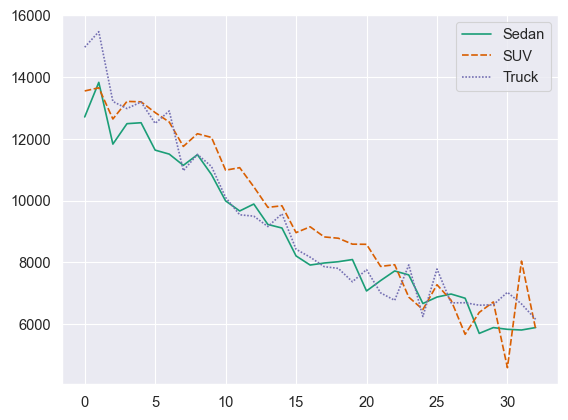

In [19]:
# check with Woody et al.
nhts_vmt_vehage_woody = pd.read_excel(os.path.join(dir.p_data,'woody_etal_2022','erlac5142supp1.xlsx'),sheet_name='Figure S2',skiprows=1)
nhts_vmt_vehage_woody.rename(columns={'Unnamed: 0':'VEHAGE','Pickup':'Truck'},inplace=True)
nhts_vmt_vehage_woody_rd = nhts_vmt_vehage_woody.round(decimals=0)
# QA
print((nhts_vmt_vehage_rd.iloc[0:25,:] != nhts_vmt_vehage_woody_rd).sum()) # all equal to Woody data
sns.lineplot(data=nhts_vmt_vehage_rd.iloc[:,1:4]) # plot results

### Vehicle Class Prevalence

In [20]:
## VEHICLE CLASS PREVALENCE ##
# Geographic scope: 18 groups from Zhou et al. (2020)
density_cond = [nhts_vmt_vehage_base['HTRESDN'] <= 99,nhts_vmt_vehage_base['HTRESDN'] <= 1999]
density_choice = ['rural','suburban']
nhts_vmt_vehage_base['density_group'] = np.select(density_cond,density_choice,'urban')
geogroup_map = {'Middle Atlantic Division':'Northeast','East North Central Division':'Midwest','Pacific Division':'Pacific','West South Central Division':'South Central','South Atlantic Division':'South Atlantic','Mountain Division':'Mountain','New England Division':'Northeast', 'East South Central Division':'South Central','West North Central Division':'Midwest'}
nhts_vmt_vehage_base['geogroup'] = nhts_vmt_vehage_base['Division_Name'].map(geogroup_map)
## count number of each vehicle class in each group
nhts_VEHCLASS_byGGVC = nhts_vmt_vehage_base[['geogroup','density_group','VEHCLASS','HOUSEID']].groupby(by = ['geogroup','density_group','VEHCLASS'],as_index=False).count()
nhts_VEHCLASS_byGGVC.rename(columns={'HOUSEID':'VC_count'},inplace=True)
# calculate total number of vehicles
nhts_VEHCLASS_byGGVC.set_index(keys=['geogroup','density_group'],inplace=True)
nhts_VEHCLASS_byGGVC['veh_total'] = nhts_VEHCLASS_byGGVC[['VC_count']].groupby(level=[0,1],as_index=True).sum()
# calculate vehicle class prevalence
nhts_VEHCLASS_byGGVC['VEHCLASS_FRAC'] = nhts_VEHCLASS_byGGVC['VC_count'] / nhts_VEHCLASS_byGGVC['veh_total']
nhts_VEHCLASS_byGGVC.reset_index(inplace=True)


county_GG_VC = {'hu_density_base_df':county_base[['county_index','ALAND']].merge(county_tot_hu[['county_index','total_hu']],how='left',on='county_index')}

tract_GG_VC = {'hu_density_base_df':tract_base[['county_index','tract_index','ALAND']].merge(tract_tot_hu[['county_index','tract_index','total_hu']],how='left',on=['county_index','tract_index'])}

scales_GG_VC = [county_GG_VC,tract_GG_VC]

for scale in scales_GG_VC:
    # Calculate housing unit density
    # tract-level
    # ALAND is in square meters per metadata
    # 1 square meter = 0.0000003861003 square mile
    hu_density = scale['hu_density_base_df'].copy()
    hu_density['ALAND_sqmi'] = hu_density['ALAND'] * 0.0000003861003
    hu_density['density_hupsqmi'] = hu_density['total_hu'] / hu_density['ALAND_sqmi']
    density_cond = [(hu_density['density_hupsqmi'] < 100).astype(bool),(hu_density['density_hupsqmi'] < 2000).astype(bool)]
    density_choice = ['rural','suburban']
    hu_density['density_group'] = np.select(density_cond,density_choice,'urban')
    # Assign geogroups
    geogroup_map = {'Middle Atlantic Division':'Northeast','East North Central Division':'Midwest',
                    'Pacific Division':'Pacific','West South Central Division':'South Central',
                    'South Atlantic Division':'South Atlantic','Mountain Division':'Mountain',
                    'New England Division':'Northeast', 'East South Central Division':'South Central',
                    'West North Central Division':'Midwest'}
    GG_VC_df = hu_density.merge(county_rd[['county_index','Division_Name']],how='left',on='county_index')
    GG_VC_df['geogroup'] = GG_VC_df['Division_Name'].map(geogroup_map)
    # merge VEHCLASS prevalence to tract data
    GG_VC_df = GG_VC_df.merge(nhts_VEHCLASS_byGGVC[['geogroup','density_group','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['geogroup','density_group'],validate='many_to_many',copy=False)
    # Add US average
    nhts_vehclass_US = nhts_vehclass.pivot_table(index='NHTS_VEHCLASS',values='HOUSEID',aggfunc='count',margins=True)
    nhts_vehclass_US.rename(columns={'HOUSEID':'VEH_CT'},inplace=True)
    nhts_vehclass_US['VEHCLASS_FRAC'] = nhts_vehclass_US['VEH_CT'] / nhts_vehclass_US.loc['All','VEH_CT']
    nhts_vehclass_US = nhts_vehclass_US.reset_index().query('VEHCLASS_FRAC != 1').drop(columns=['VEH_CT'])
    nhts_vehclass_US.rename(columns={'NHTS_VEHCLASS':'VEHCLASS'},inplace=True)
    nhts_vehclass_US['tract_index'] = 72831
    nhts_vehclass_US['county_index'] = 3142
    GG_VC_df = pd.concat([GG_VC_df,nhts_vehclass_US]).reset_index(drop=True)
    scale['GG_VC_df'] = GG_VC_df

del scale, scales_GG_VC

# clean up
county_GG_VC['GG_VC_df'].drop(columns='tract_index',inplace=True)
# create wide version w/ some Census data fields
GG_VC_df_wide = tract_GG_VC['GG_VC_df'].pivot_table(index=['county_index','tract_index','geogroup','density_group'],columns='VEHCLASS',values='VEHCLASS_FRAC').reset_index()
GG_VC_df_wide = GG_VC_df_wide.rename_axis(None,axis=1)
GG_VC_df_wide = GG_VC_df_wide.merge(fips_county_urbrur[['county_index','UR_code','UR_code_name']],how='left',on='county_index',validate='many_to_one',copy=False)
GG_VC_df_wide = GG_VC_df_wide.merge(county_rd[['county_index','Region','Division','state_name','Region_Name','Division_Name']],how='left',on='county_index',validate='many_to_one',copy=False)

#### Population Weightings by VC

In [21]:
# county-level
county_mult_pop_US_VC = county_GG_VC['GG_VC_df'].merge(county_tot_pop,how='left',on='county_index')
county_mult_pop_US_VC['mult_pop_US_VC'] = county_mult_pop_US_VC['mult_pop_US'] * county_mult_pop_US_VC['VEHCLASS_FRAC']
county_mult_pop_US_VC = county_mult_pop_US_VC[['county_index','VEHCLASS','mult_pop_US_VC']]

# tract-level
tract_mult_pop_US_VC = tract_GG_VC['GG_VC_df'].merge(tract_tot_pop,how='left',on=['county_index','tract_index'])
tract_mult_pop_US_VC['mult_pop_US_VC'] = tract_mult_pop_US_VC['mult_pop_US'] * tract_mult_pop_US_VC['VEHCLASS_FRAC']
tract_mult_pop_US_VC = tract_mult_pop_US_VC[['tract_index','VEHCLASS','mult_pop_US_VC']]

### Fuel Efficiency
Methods and assumptions from Woody et al. (2022)

In [22]:
def calculate_fuel_consumption():
    # Load and process data
    ## Drive cycle
    drive_cycle_urbrur = {'UR_code':[1,2,3,4,5,6],'urban_per':[1,0.8,0.6,0.4,0.2,0]}
    df_drive_cycle = pd.DataFrame(data=drive_cycle_urbrur)

    ## Temperature adjustment
    # Temperature adjustment assumptions, all parameters in degrees Fahrenheit
    TC = 60
    TH = 75
    alpha_TC_ICEV = 0.0115
    alpha_TC_BEV = 0.0436
    alpha_TH_ICEV = 0.0232
    alpha_TH_BEV = 0.0378
    ### Alaska
    # Import AK temperature data
    # Source: https://www.ncdc.noaa.gov/cag/county/mapping/50/tavg/202012/60/mean
    county_temp_AK = pd.read_csv(os.path.join(dir.p_data,'noaa','50-tavg.csv'),skiprows=3,na_values=-99)
    county_temp_AK['year'] = county_temp_AK['Date'].astype(str).str[:4].astype(int)
    county_temp_AK['month'] = county_temp_AK['Date'].astype(str).str[-2:].astype(int)
    county_temp_AK.query('(year >= 2016) & (year <= 2020)',inplace=True)
    county_temp_AK['county_text'] = 'T02' + county_temp_AK['Location ID'].str[-3:]
    county_temp_AK.rename(columns={'Value':'temp_degF'},inplace=True)
    county_temp_AK_avg = county_temp_AK.copy()
    # Assign 2 counties with former county name for compatibility with other datasets that do not have the most recent county changes
    # https://www.census.gov/programs-surveys/geography/technical-documentation/county-changes.2010.html
    county_temp_AK_avg.loc[county_temp_AK_avg['county_text']=='T02063','county_text'] = 'T02261' # Change Chugach Census Area back to Valdez-Cordova Census Area
    county_temp_AK_avg.loc[county_temp_AK_avg['county_text']=='T02066','county_text'] = 'T02261' # Copper River Census Area back to Valdez-Cordova Census Area
    county_temp_AK_avg = county_temp_AK_avg[['county_text','month','temp_degF']].groupby(by=['county_text','month'],as_index=False).mean()

    # Calculate r for AK
    calc.temp_r(df=county_temp_AK_avg,col_temp='temp_degF',col_r='r_ICEV',alpha_TC=alpha_TC_ICEV,alpha_TH=alpha_TH_ICEV,TC=TC,TH=TH)
    calc.temp_r(df=county_temp_AK_avg,col_temp='temp_degF',col_r='r_BEV',alpha_TC=alpha_TC_BEV,alpha_TH=alpha_TH_BEV,TC=TC,TH=TH)

    # Calculate annual average
    month_days_map = {1:31,2:28.25,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    county_temp_AK_avg['days_in_month'] = county_temp_AK_avg['month'].map(month_days_map)
    county_temp_AK_avg['r_ICEV_wtd'] = county_temp_AK_avg['r_ICEV'] * county_temp_AK_avg['days_in_month'] / 365.25
    county_temp_AK_avg['r_BEV_wtd'] = county_temp_AK_avg['r_BEV'] * county_temp_AK_avg['days_in_month'] / 365.25
    county_r_AK_avg = county_temp_AK_avg[['county_text','r_ICEV_wtd','r_BEV_wtd']].groupby(by=['county_text'],as_index=False).sum()
    county_r_AK_avg.rename(columns={'r_ICEV_wtd':'r_ICEV','r_BEV_wtd':'r_BEV'},inplace=True)

    ### Hawaii
    # Import HI temperature data
    # Source: https://www.ncdc.noaa.gov/cag/city/mapping/51/tavg/202012/60/value
    county_temp_HI = pd.read_csv(os.path.join(dir.p_data,'noaa','51-tavg.csv'),skiprows=3,na_values=-99)
    county_temp_HI['year'] = county_temp_HI['Date'].astype(str).str[:4].astype(int)
    county_temp_HI['month'] = county_temp_HI['Date'].astype(str).str[-2:].astype(int)
    county_temp_HI.query('(year >= 2016) & (year <= 2020)',inplace=True)
    HI_city_county_map = {'Captain Cook, Hawaii':'T15001','Hilo, Hawaii':'T15001',
                        'Honolulu Intl. Airport, Hawaii':'T15003','Honolulu Zoo, Hawaii':'T15003',
                        'Kahului, Hawaii':'T15009','Kapalua, Hawaii':'T15009','Kula, Hawaii':'T15009',
                        'lihue, Hawaii':'T15007'}
    county_temp_HI['county_text'] = county_temp_HI['Location'].map(HI_city_county_map)
    county_temp_HI.rename(columns={'Value':'temp_degF'},inplace=True)
    county_temp_HI_avg = county_temp_HI[['county_text','month','temp_degF']].groupby(by=['county_text','month'],as_index=False).mean()

    # Calculate r for HI
    # Temperature adjustment assumptions, all parameters in degrees Fahrenheit
    calc.temp_r(df=county_temp_HI_avg,col_temp='temp_degF',col_r='r_ICEV',alpha_TC=alpha_TC_ICEV,alpha_TH=alpha_TH_ICEV,TC=TC,TH=TH)
    calc.temp_r(df=county_temp_HI_avg,col_temp='temp_degF',col_r='r_BEV',alpha_TC=alpha_TC_BEV,alpha_TH=alpha_TH_BEV,TC=TC,TH=TH)

    # Calculate annual average
    county_temp_HI_avg['days_in_month'] = county_temp_HI_avg['month'].map(month_days_map)
    county_temp_HI_avg['r_ICEV_wtd'] = county_temp_HI_avg['r_ICEV'] * county_temp_HI_avg['days_in_month'] / 365.25
    county_temp_HI_avg['r_BEV_wtd'] = county_temp_HI_avg['r_BEV'] * county_temp_HI_avg['days_in_month'] / 365.25
    county_r_HI_avg = county_temp_HI_avg[['county_text','r_ICEV_wtd','r_BEV_wtd']].groupby(by=['county_text'],as_index=False).sum()
    county_r_HI_avg.rename(columns={'r_ICEV_wtd':'r_ICEV','r_BEV_wtd':'r_BEV'},inplace=True)

    # Add Kalawao County, Hawaii - same as Maui County
    county_r_HI_T15005 = county_r_HI_avg.query('county_text  == "T15009"').reset_index(drop=True)
    county_r_HI_T15005.loc[0,'county_text'] = 'T15005'
    county_r_HI_avg = pd.concat([county_r_HI_avg,county_r_HI_T15005])

    ### Contiguous US from Woody et al.
    temp_adj_dtype = {'FIPS':object}
    temp_adj = pd.read_excel(os.path.join(dir.p_data,'woody_etal_2022','erlac5142supp1.xlsx'),sheet_name='Figure S3',skiprows=1,dtype=temp_adj_dtype)
    temp_adj.rename(columns={'ICEVs':'r_ICEV','BEVs':'r_BEV'},inplace=True)
    temp_adj = temp_adj[['FIPS','r_ICEV','r_BEV']]
    help.fixGEOID(temp_adj,'FIPS','county_text',5)
    temp_adj.drop(columns='FIPS',inplace=True)
    ### Combine all US states
    temp_adj = pd.concat([temp_adj,county_r_AK_avg,county_r_HI_avg]) # add Alaska and Hawaii
    temp_adj.reset_index(drop=True,inplace=True)
    temp_adj = temp_adj.merge(county_index,how='left',on='county_text')

    ## Fuel consumption / economy - drive cycle adjustment without temperature adjustment
    ## BEV fuel consumption (FC) values are in Watt-hour (Wh) per mile [Whpm] and ICEV fuel economy (FE) values are in miles per gallon [mpg]
    data_fe = {'VEHCLASS': ['Sedan','SUV','Truck'],'UDDS_BEV': [145.2,188.9,225.8],'HWFET_BEV':[180.7,248.1,306.9],'UDDS_ICEV': [37.1,32.7,25.4],'HWFET_ICEV':[49.6,39.9,31.3]}
    df_fe = pd.DataFrame(data = data_fe)
    h_city = 0.67
    h_hwy = 0.87
    df_fe['FC_OR_city_BEV'] = df_fe['UDDS_BEV'] / 0.7
    df_fe['FC_OR_hwy_BEV'] = df_fe['HWFET_BEV'] / 0.7
    df_fe['FC_noT_city_BEV'] = df_fe['UDDS_BEV'] + h_city*(df_fe['FC_OR_city_BEV']-df_fe['UDDS_BEV'])
    df_fe['FC_noT_hwy_BEV'] = df_fe['HWFET_BEV'] + h_hwy*(df_fe['FC_OR_hwy_BEV']-df_fe['HWFET_BEV'])
    df_fe['FE_noT_city_ICEV'] = 1 / (0.00187 + (1.134/df_fe['UDDS_ICEV']))
    df_fe['FE_noT_hwy_ICEV'] = 1 / (0.00269 + (1.235/df_fe['HWFET_ICEV']))
    df_fe = df_fe[['VEHCLASS', 'FC_noT_city_BEV', 'FC_noT_hwy_BEV','FE_noT_city_ICEV', 'FE_noT_hwy_ICEV']]

    ## Final fuel economy (FE)
    county_fe_long = county_GG_VC['GG_VC_df'][['county_index','VEHCLASS']].query('county_index != 3142', engine='python').merge(fips_county_urbrur[['county_index','UR_code']],how='left',on='county_index')
    county_fe_long = county_fe_long.merge(df_drive_cycle,how='left',on='UR_code',copy=False)
    county_fe_long = county_fe_long.merge(temp_adj,how='left',on='county_index',copy=False)
    county_fe_long = county_fe_long.merge(df_fe,how='left',on='VEHCLASS',copy=False)
    ### Calculate drive cycle and temperature-adjusted FE
    county_fe_long['FC_BEV_Whpm'] = (county_fe_long['urban_per']*county_fe_long['FC_noT_city_BEV'] + (1-county_fe_long['urban_per'])*county_fe_long['FC_noT_hwy_BEV']) * county_fe_long['r_BEV']
    county_fe_long['FC_ICEV_mpg'] = (county_fe_long['urban_per']*county_fe_long['FE_noT_city_ICEV'] + (1-county_fe_long['urban_per'])*county_fe_long['FE_noT_hwy_ICEV']) / county_fe_long['r_ICEV']
    county_fe_long['FC_BEV_kWhpm'] = county_fe_long['FC_BEV_Whpm'] / 1000
    county_fe_long = county_fe_long[['county_index', 'VEHCLASS', 'FC_BEV_kWhpm', 'FC_ICEV_mpg']]

    # Fuel economy by PT and VC
    county_fc_long_bPT = county_fe_long.copy()
    county_fc_long_bPT['FC_ICEV_gpm'] = 1 / county_fc_long_bPT['FC_ICEV_mpg'] 
    county_fc_long_bPT = county_fc_long_bPT.melt(id_vars=['county_index','VEHCLASS'],value_name='base_FC',value_vars=['FC_BEV_kWhpm','FC_ICEV_gpm'],var_name='FC_PT')
    county_fc_long_bPT['POWERTRAIN'] = np.where(county_fc_long_bPT['FC_PT']=='FC_BEV_kWhpm','BEV','ICEV')
    # county_fc_long_bPT['UNITS_FC'] = np.where(county_fc_long_bPT['POWERTRAIN']=='BEV','kWh per mile','gallons per mile')
    county_fc_long_bPT = county_fc_long_bPT.reindex(columns=['county_index','POWERTRAIN','VEHCLASS','base_FC'])
    county_fc_long_bPT['min_BEV_FC_max_ICEV_FC'] = np.where(county_fc_long_bPT['POWERTRAIN']=='BEV',(1-pct_sa) * county_fc_long_bPT['base_FC'],(1+pct_sa) * county_fc_long_bPT['base_FC'])
    county_fc_long_bPT['max_BEV_FC_min_ICEV_FC'] = np.where(county_fc_long_bPT['POWERTRAIN']=='BEV',(1+pct_sa) * county_fc_long_bPT['base_FC'],(1-pct_sa) * county_fc_long_bPT['base_FC'])
    county_fc_long_bPT['sa_lwr_BEV_FC_base_ICEV_FC'] = np.where(county_fc_long_bPT['POWERTRAIN']=='BEV',(1-pct_sa) * county_fc_long_bPT['base_FC'],county_fc_long_bPT['base_FC'])
    county_fc_long_bPT['sa_upr_BEV_FC_base_ICEV_FC'] = np.where(county_fc_long_bPT['POWERTRAIN']=='BEV',(1+pct_sa) * county_fc_long_bPT['base_FC'],county_fc_long_bPT['base_FC'])
    county_fc_long_bPT['base_BEV_FC_sa_lwr_ICEV_FC'] = np.where(county_fc_long_bPT['POWERTRAIN']=='BEV',county_fc_long_bPT['base_FC'],(1-pct_sa) * county_fc_long_bPT['base_FC'])
    county_fc_long_bPT['base_BEV_FC_sa_upr_ICEV_FC'] = np.where(county_fc_long_bPT['POWERTRAIN']=='BEV',county_fc_long_bPT['base_FC'],(1+pct_sa) * county_fc_long_bPT['base_FC'])
    # US national average
    county_fc_long_bPT = county_fc_long_bPT.merge(county_tot_pop,how='left',on='county_index')
    county_fc_long_bPT.sort_values(by=['POWERTRAIN','VEHCLASS','county_index'],inplace=True)
    county_fc_long_bPT.set_index(keys=['POWERTRAIN','VEHCLASS','county_index'],inplace=True)
    county_fc_long_bPT['tot_pop_US'] = county_fc_long_bPT['pop_US'].groupby(level=[0,1]).sum()
    county_fc_long_bPT['wt_pop'] = county_fc_long_bPT['pop_US'] / county_fc_long_bPT['tot_pop_US']
    county_fc_long_bPT.drop(columns=['pop_US','tot_pop_US'],inplace=True)
    county_fc_long_bPT.reset_index(inplace=True)
    county_fc_long_bPT = county_fc_long_bPT.merge(county_index,how='left',on='county_index')
    return county_fc_long_bPT

county_fc_long_bPT = calculate_fuel_consumption()
county_fc_long_bPT = county_fc_long_bPT.astype({'POWERTRAIN':'category','VEHCLASS':'category','county_index':'int16','base_FC':'float32',
       'min_BEV_FC_max_ICEV_FC':'float32','max_BEV_FC_min_ICEV_FC':'float32',
       'sa_lwr_BEV_FC_base_ICEV_FC':'float32','sa_upr_BEV_FC_base_ICEV_FC':'float32',
       'base_BEV_FC_sa_lwr_ICEV_FC':'float32','base_BEV_FC_sa_upr_ICEV_FC':'float32'})

# Wide format with conversion to fuel economy - miles per GGE
county_fc_w = county_fc_long_bPT[['POWERTRAIN','county_index','VEHCLASS','base_FC']].copy()
county_fc_w = county_fc_w.merge(fc_conversion,how='left',on='POWERTRAIN')
county_fc_w['base_FC_GGEp100m'] = county_fc_w['base_FC'] * county_fc_w['conversion_factor_GGEpGGorkWh'] * 100
## WEIGHTED ##
county_fc_wtd_w = county_fc_w.merge(county_GG_VC['GG_VC_df'][['county_index','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['county_index','VEHCLASS']).sort_values(by=['POWERTRAIN','county_index','VEHCLASS']).set_index(keys=['POWERTRAIN','county_index','VEHCLASS'])
county_fc_wtd_w = county_fc_wtd_w.multiply(county_fc_wtd_w['VEHCLASS_FRAC'],axis='index',level='VEHCLASS',fill_value=None).groupby(level=['POWERTRAIN','county_index']).sum()
county_fc_wtd_w = county_fc_wtd_w.reset_index().drop(columns='VEHCLASS_FRAC')
county_fc_wtd_w = county_fc_wtd_w.pivot(index=['county_index'],values='base_FC_GGEp100m',columns='POWERTRAIN').reset_index()
county_fc_wtd_w = county_fc_wtd_w.rename_axis(None,axis=1)
county_fc_wtd_w.rename(columns={'BEV':'FC_BEV','ICEV':'FC_ICEV'},inplace=True)
county_fc_wtd_w['pct_chg_FC'] = (county_fc_wtd_w['FC_BEV'] - county_fc_wtd_w['FC_ICEV']) / county_fc_wtd_w['FC_ICEV'] * 100
# add column for map color spectrum
stats_fc = county_fc_wtd_w.describe()
county_fc_wtd_w.loc[0,'color_spectrum'] = min(stats_fc.loc['min','FC_BEV'],stats_fc.loc['min','FC_ICEV'])
county_fc_wtd_w.loc[3141,'color_spectrum'] = max(stats_fc.loc['max','FC_BEV'],stats_fc.loc['max','FC_ICEV'])
county_fc_wtd_w['color_spectrum'] = county_fc_wtd_w['color_spectrum'].interpolate(method='linear',axis=0)
## BY VEHCLASS ##
county_fc_bVC_w = county_fc_w.copy()
county_fc_bVC_w['FE_PT_VC'] = 'FE_' + county_fc_bVC_w['POWERTRAIN'].astype(str) + '_' + county_fc_bVC_w['VEHCLASS'].astype(str)
county_fc_bVC_w = county_fc_bVC_w.pivot(index=['county_index'],values='base_FC_GGEp100m',columns='FE_PT_VC').reset_index()
county_fc_bVC_w = county_fc_bVC_w.rename_axis(None,axis=1)

## Transportation Energy Burden Data - Disaggregated
Source: Zhou et al. (2020)

NOTE: Data provided by authors - disaggregated version not publicly available.

In [23]:
# Create variable_lookup df
tract_TEB_ST_raw = pd.read_csv(os.path.join(dir.p_data,'zhou_etal_2020','detailed_data','disaggregated results_OpenEI','full_data_AL.csv'),index_col=0)
tract_TEB_ST_l = tract_TEB_ST_raw.melt(id_vars=['tract','VEH4','WRK3','price','wtd_mpg','total_hh'],value_vars=[x for x in tract_TEB_ST_raw.columns.tolist() if ('burden' in x) or ('vmt' in x) or ('hhs' in x)])
variable_lookup = tract_TEB_ST_l[['variable']].drop_duplicates()
variable_lookup[['variable_name','income_bin10']] = tract_TEB_ST_l['variable'].str.rsplit('_',n=1,expand=True)
variable_lookup.to_csv(os.path.join(dir.p_data,'zhou_etal_2020','detailed_data','variable_lookup.csv'),index=False)

In [24]:
# Import and append files for all states
# Lookup tables for fields
variable_lookup = pd.read_csv(os.path.join(dir.p_data,'zhou_etal_2020','detailed_data','variable_lookup.csv'))
income_bin_key = variable_lookup[['income_bin10']].drop_duplicates().reset_index(drop=True).reset_index()
income_bin_key.rename(columns={'index':'id_income_bin10'},inplace=True)

def process_TEB_data(files_path = os.path.join(dir.p_data,'zhou_etal_2020','detailed_data','disaggregated results_OpenEI','**','*.csv')):
    # File paths
    files = glob.glob(files_path, recursive=True)
    # Initiate dataframe
    tract_TEB_df_DA = pd.DataFrame()
    # Iterate through state-level files
    for file in files:
        # print(file)
        if ('Updated_AK_fixed' in file) or ('Updated_HI_fixed' in file):
            state_df = pd.read_csv(file,index_col=0)
            state_df.rename(columns={'FIP':'tract'},inplace=True)
            help.fixGEOID(df=state_df,col_in='tract',col_out='tract_text',length=11)
            state_df = state_df.merge(tract_tot_hh,how='left',on='tract_text')
        else:
            state_df = pd.read_csv(file,index_col=0) # Read state csv file
        # manipulate raw data
        state_l = state_df.melt(id_vars=['tract','VEH4','WRK3','total_hh','wtd_mpg','price'],value_vars=[x for x in state_df.columns.tolist() if ('burden' in x) or ('vmt' in x) or ('hhs' in x)])
        state_l = state_l.merge(variable_lookup,how='left',on='variable')
        state_l = state_l.merge(income_bin_key,how='left',on='income_bin10')
        state_bINC = state_l.pivot(index=['tract','id_income_bin10','WRK3','VEH4','total_hh','wtd_mpg','price'],columns='variable_name',values='value')
        state_bINC.reset_index(inplace=True)
        state_bINC.rename(columns={'hhs_in':'mult_hhs_tract','total_hh':'hhs_tract'},inplace=True)
        # calculate additional columns
        state_bINC['hh_income'] = round(state_bINC['vmt'] * (1/state_bINC['wtd_mpg']) * state_bINC['price'] / state_bINC['burden'],0)
        state_bINC['hh_income'] = state_bINC['hh_income'].fillna(method='bfill',limit=1)
        state_bINC['hhs_tract_inc_wrk_veh'] = state_bINC['mult_hhs_tract']*state_bINC['hhs_tract']
        # remove zero-vehicle households
        state_bINC.set_index(keys=['tract'],inplace=True)
        state_bINC['hhs_tract_VEH0'] = state_bINC.query('VEH4==0')['hhs_tract_inc_wrk_veh'].groupby(by='tract').sum()
        state_bINC['hhs_tract_VEH1+'] = state_bINC['hhs_tract'] - state_bINC['hhs_tract_VEH0']
        state_bINC.query('VEH4!=0',inplace=True)
        state_bINC.reset_index(inplace=True)
        # add lookup columns
        help.fixGEOID(df=state_bINC,col_in='tract',col_out='tract_text',length=11)
        state_bINC['county_text'] = state_bINC['tract_text'].str[:6]
        state_bINC = state_bINC.rename_axis(None,axis=1).reset_index(drop=True)
        state_bINC = state_bINC.merge(tract_county_index,how='left',on=['county_text','tract_text'])
        state_bINC.dropna(subset=['tract_index'],inplace=True)
        # add AMI bins
        state_bINC = state_bINC.merge(tract_ami,how='left',on='tract_index')
        help.amiBINS(df=state_bINC,col_in='hh_income')
        # multipliers with household counts
        state_bINC.set_index(keys=['county_index','tract_index','ami_bin','id_income_bin10','WRK3','VEH4'],inplace=True)
        state_bINC['hhs_tract_inc'] = state_bINC['hhs_tract_inc_wrk_veh'].groupby(level=['county_index','tract_index','ami_bin']).sum()
        state_bINC['mult_hhs_tract_inc'] = state_bINC['hhs_tract_inc_wrk_veh'] / state_bINC['hhs_tract_inc']
        state_bINC['mult_hhs_tract'] = state_bINC['hhs_tract_inc_wrk_veh'] / state_bINC['hhs_tract_VEH1+']
        # clean up
        cols_f32 = ['hhs_tract','wtd_mpg','price','burden','vmt','hh_income']
        for col in cols_f32:
            state_bINC[col] = state_bINC[col].astype('float32')
        state_bINC.drop(columns=['tract','hhs_tract_inc_wrk_veh','hhs_tract_VEH1+','county_text','tract_text','AMI','pct_ami'],inplace=True)
        state_bINC.reset_index(inplace=True)
        tract_TEB_df_DA = pd.concat([tract_TEB_df_DA,state_bINC])
    
    # zero vehicle households
    veh0 = tract_TEB_df_DA[['tract_index','hhs_tract','hhs_tract_VEH0']].drop_duplicates()
    pct_veh0 = veh0['hhs_tract_VEH0'].sum() / veh0['hhs_tract'].sum() * 100 # 8.7% of households have 0 vehicles
    print(f'percent of zero-vehicle households: {round(pct_veh0,1)}%')

    # aggregated to tract level
    tract_TEB_df = tract_TEB_df_DA.set_index(keys=['county_index','tract_index','id_income_bin10','WRK3','VEH4']).drop(columns=['mult_hhs_tract_inc'])
    tract_TEB_df = tract_TEB_df.multiply(tract_TEB_df['mult_hhs_tract'],axis='index',level='VEH4',fill_value=None).groupby(level=['county_index','tract_index']).sum()
    tract_TEB_df = tract_TEB_df.reset_index().drop(columns=['mult_hhs_tract'])
    tract_TEB_df.rename(columns={'price':'gas'},inplace=True)

    # multiplier for income bins - aggregated
    tract_tot_hh_bINC = tract_TEB_df_DA[['tract_index','ami_bin','hhs_tract_inc']].drop_duplicates()
    tract_tot_hh_bINC['mult_hh_study_incbin'] = tract_tot_hh_bINC['hhs_tract_inc'] / tract_tot_hh_bINC['hhs_tract_inc'].sum() # divide number of households in each tract-income bin by total number of households
    tract_tot_hh_bINC.dropna(subset=['tract_index','ami_bin'],inplace=True)
    tract_tot_hh_bINC['ami_bin'] = tract_tot_hh_bINC['ami_bin'].astype('int16')

    # final format for DA_df
    tract_TEB_df_DA = tract_TEB_df_DA.reindex(columns=['county_index','tract_index','ami_bin','id_income_bin10','WRK3','VEH4','mult_hhs_tract','mult_hhs_tract_inc','vmt','hh_income','burden'])
    tract_TEB_df_DA.dropna(subset=['tract_index'],inplace=True)
    tract_TEB_df_DA = tract_TEB_df_DA.astype({'county_index':'int16','tract_index':'int32'})

    print('processing complete, tract_TEB_df_DA info:')
    display(tract_TEB_df_DA.info())

    return tract_TEB_df_DA,tract_TEB_df,tract_tot_hh_bINC

tract_TEB_df_DA,tract_TEB_df,tract_tot_hh_bINC = process_TEB_data()

percent of zero-vehicle households: 8.7%
processing complete, tract_TEB_df_DA info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12759648 entries, 0 to 57023
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county_index        int16  
 1   tract_index         int32  
 2   ami_bin             float64
 3   id_income_bin10     int64  
 4   WRK3                int64  
 5   VEH4                int64  
 6   mult_hhs_tract      float64
 7   mult_hhs_tract_inc  float64
 8   vmt                 float32
 9   hh_income           float32
 10  burden              float32
dtypes: float32(3), float64(3), int16(1), int32(1), int64(3)
memory usage: 900.5 MB


None

## Cost Data

### EIA Data Processing
**Data Source Information**  
All data should be saved to the lcoc-ldevs/data/eia folder. Note that a full census of all utilities is only collected every 8 years, the most recent of which was in 2019. The 2019 data is updated with 2020 data for the sample collected in 2020.
 - Annual Energy Outlook (eia_aeo) data downloaded from https://www.eia.gov/outlooks/aeo/data/browser/#/?id=3-AEO2021&region=1-0&cases=ref2021~highprice~lowprice&start=2020&end=2050&f=A&linechart=~~~ref2021-d113020a.28-3-AEO2021.1-0~highprice-d113020a.28-3-AEO2021.1-0~lowprice-d113020a.28-3-AEO2021.1-0~ref2021-d113020a.13-3-AEO2021.1-0~highprice-d113020a.13-3-AEO2021.1-0~lowprice-d113020a.13-3-AEO2021.1-0~ref2021-d113020a.6-3-AEO2021.1-0~highprice-d113020a.6-3-AEO2021.1-0~lowprice-d113020a.6-3-AEO2021.1-0&map=highprice-d113020a.3-3-AEO2021.1-0&chartindexed=1&sourcekey=0
     - If using a different AEO year, will need to recreate the chart for the desired AEO year and download data
     - Save to 'eia/15yr-gas-electricity-price-projections' folder and name 'eia_aeoYY_gas_electricity_price_projections'
 - table6 & table7 price files downloaded from https://www.eia.gov/electricity/sales_revenue_price/
     - Save to 'eia/commercial-electricity-prices' folder and add _YY to name for clarity
 - Service_Territory_YYYY & Delivery_Companies_YYYY downloaded from https://www.eia.gov/electricity/data/eia861/. 
     - Download zip file, unzip
     - Copy Service_Territory_YYYY to 'eia/eiaid-crosswalk'
     - Copy Delivery_Companies_YYYY to 'eia/TX-delivery-companies'

In [25]:
## Set import parameters
eia_price_yr_c = '2019' # c = census
eia_price_yr_s = '2020' # s = sample
aeo_yr = '2021'

proc.eia_data(eia_price_yr_c=eia_price_yr_c,eia_price_yr_s=eia_price_yr_s,aeo_yr=aeo_yr,fips_state_county=fips_state_county)

eia_aeo = pd.read_csv(os.path.join(dir.cost_data,'eia','15yr-gas-electricity-price-projections',f'eia_price_scenarios_aeo{aeo_yr[-2:]}.csv'))

# Add sensitivity analysis scenarios
eia_aeo['sa_lwr_res_elec_cost_sf'] = eia_aeo['ref_res_elec_cost_sf']*(1-pct_sa)
eia_aeo['sa_upr_res_elec_cost_sf'] = eia_aeo['ref_res_elec_cost_sf']*(1+pct_sa)
eia_aeo['sa_lwr_gas_cost_sf'] = eia_aeo['ref_gas_cost_sf']*(1-pct_sa)
eia_aeo['sa_upr_gas_cost_sf'] = eia_aeo['ref_gas_cost_sf']*(1+pct_sa)
eia_aeo = eia_aeo.astype({'year':'int32','ref_gas_cost_sf':'float32','highoil_gas_cost_sf':'float32','lowoil_gas_cost_sf':'float32',
    'ref_com_elec_cost_sf':'float32','highoil_com_elec_cost_sf':'float32','lowoil_com_elec_cost_sf':'float32','ref_res_elec_cost_sf':'float32',
    'highoil_res_elec_cost_sf':'float32','lowoil_res_elec_cost_sf':'float32','sa_lwr_res_elec_cost_sf':'float32','sa_upr_res_elec_cost_sf':'float32',
    'sa_lwr_gas_cost_sf':'float32','sa_upr_gas_cost_sf':'float32'})

Loading data.
Data loaded.
AEO data processed.
2019 census EIA residential electricity price data contains 3048 utility-state groups, 2020 sample EIA residential electricity price data contains 1439 utility-state groups
2019 census EIA commercial electricity price data contains 3043 utility-state groups, 2020 census EIA commercial electricity price data contains 1453 utility-state groups
Updating entities in Census price data with most recent Service Territory list
Number of residential utilities in sample but not in census data: 0
Number of commercial utilities in sample but not in census data: 0
Updating census data with sample prices where applicable
Reconciling Texas Retail Energy Providers (REP) / Retail Power Marketer (RPM) and TDU mismatch
Customer-weighted average residential price for Texas RPMs is 12.65 cents per kWh
Customer-weighted average commercial price for Texas RPMs is 9.35 cents per kWh
Final residential electricity price data contains 2980 utility-state groups
Final

### Gas prices

#### County-level gas prices from TEB data

In [26]:
# Create county-level gas price DF from TEB data
county_gas_price = tract_TEB_df[['county_index','gas']].groupby(by=['county_index'],as_index=False).mean()
county_gas_price = county_gas_price.merge(county_index,how='left',on='county_index')
county_gas_price_T02050 = county_gas_price.query('county_text=="T02050"').reset_index(drop=True)
county_gas_price_T02158 = county_index.query('county_text=="T02158"')
county_gas_price_T02158['gas'] = county_gas_price_T02050.loc[0,'gas']  # add missing AK county - assume same gas price as neighboring Bethel
county_gas_price = pd.concat([county_gas_price,county_gas_price_T02158]).sort_values(by=['county_index','county_text']).reset_index(drop=True)
county_gas_price['gas_sa_lwr'] = county_gas_price['gas']*(1-pct_sa)
county_gas_price['gas_sa_upr'] = county_gas_price['gas']*(1+pct_sa)
county_gas_price = county_gas_price.astype({'county_index':'int16','gas':'float32','gas_sa_lwr':'float32','gas_sa_upr':'float32'})
county_gas_price.drop(columns='county_text',inplace=True)

#### State-level gas prices from AAA

In [27]:
# State-level gas prices from AAA
# Source: https://gasprices.aaa.com/state-gas-price-averages/
# Captured on August 3, 2022

state_gas_price = pd.read_excel(os.path.join(dir.p_data,'aaa','aaa_gas_prices_by_state_20220803.xlsx'))

state_gas_price = state_gas_price.merge(fips_state_county[['state_name','county_index']],how='left',left_on='State',right_on='state_name')
state_gas_price.rename(columns={'Regular':'price_gas_regular'},inplace=True)
state_gas_price = state_gas_price[['state_name','county_index','price_gas_regular']]

# Calculations

## COE and LCOC
The code in this section is adapted from the lcoc_demo.ipynb file from Borlaug et al. (2020).

### Load & Process Data

In [28]:
## LOAD DATA ##
if run_COE_LCOC == True:
    if urdb_afdc_version == 'current':
        db = urdb.DatabaseRates() # gets current snapshot of URDB and saves it to db
    elif urdb_afdc_version == 'specific_date':
        urdb_path = config.URDB_PATH
        print(config.URDB_PATH)
        db = urdb.DatabaseRates(urdb_path)

    print("Total:", db.rate_data.shape)
    print("Res:", db.res_rate_data.shape)
    print("Com:", db.com_rate_data.shape)

    print('filter expired rates')
    db.filter_stale_rates(industry='residential')
    print("Res:", db.res_rate_data.shape)

    db.filter_stale_rates(industry='commercial')
    print("Com:", db.com_rate_data.shape)

    # update commercial rates with manual changes to demand and energy usage limits (included in description but missing from database fields)
    urdb_rates_update = pd.read_excel(os.path.join(dir.cost,'data','urdb','urdb_rates_update_202205.xlsx'),sheet_name='changed_rates')
    urdb_rates_update.set_index(keys='label',inplace=True)
    db.com_rate_data.set_index(keys='label',inplace=True)
    db.com_rate_data.update(urdb_rates_update,overwrite=True)
    db.com_rate_data = db.com_rate_data.reset_index()

    # classify rates by is_tier, is_seasonal, is_TOU, is_ev-specific (residential only)
    ev_rate_words_filepath = os.path.join(dir.cost,'filters','urdb_res_ev_specific_rate_words.txt')

    db.classify_rate_structures(industry='residential', 
                                ev_rate_words_file=ev_rate_words_filepath)

    db.classify_rate_structures(industry='commercial')

    # standardize units of reporting for commercial rates
    db.com_rate_preprocessing()

    filters_path = os.path.join(dir.cost,'filters')

    # filter demand rates (residential only)
    db.filter_demand_rates(industry='residential') 

    # filter commercial rates missing critical fields to approx the cost of electricity
    db.additional_com_rate_filters()

    # filter rates containing certain phrases in filters/
    db.filter_on_phrases(industry='residential', filters_path=filters_path)
    db.filter_on_phrases(industry='commercial', filters_path=filters_path)

    # combine base rate + adjusted rate
    db.combine_rates(industry='residential')
    db.combine_rates(industry='commercial')

    # filter null rates
    db.filter_null_rates(industry='residential')
    db.filter_null_rates(industry='commercial')

    print('size of rate dataframes:')
    print("Res:", db.res_rate_data.shape)
    print("Com:", db.com_rate_data.shape)

    print('res rate structure breakdown')
    db.generate_classification_tree_values(industry='residential')

    print('com rate structure breakdown')
    db.generate_classification_tree_values(industry='commercial')

C:\Users\Jesse Vega-Perkins\Documents\thesis_ev\02_analysis\lcoc-ldevs\data\urdb\usurdb_20220526.csv
Total: (50311, 670)
Res: (11460, 670)
Com: (32503, 670)
filter expired rates
Res: (6151, 670)
Com: (17961, 670)
size of rate dataframes:
Res: (4772, 732)
Com: (7541, 731)
res rate structure breakdown
com rate structure breakdown


### Residential COE, Workplace/Public-L2 COE & LCOC
Residential LCOC is calculated later because it is affected by variables included in the sensitivity analysis.

In [29]:
if run_COE_LCOC == True:
    ## RESIDENTIAL COE ##
    print('calculate annual electricity cost (rates)')
    db.calculate_annual_energy_cost_residential_v2(outpath = os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-res-rates'))

    print('calculate annual electricity cost (utility-level)')
    df = proc.res_rates_to_utils(
        scenario='baseline',
        urdb_rates_file=os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-res-rates','res_rates.csv'),
        eia_cw_file=config.EIAID_TO_UTILITY_CW_PATH,
        eia_utils_file=config.EIA_RES_PATH,
        outpath=os.path.join(dir.cost,'outputs','cost-of-electricity','res-utilities'))

    print('calculate annual electricity cost (county-level)')
    proc.res_utils_to_county_and_state(
        utils_file=os.path.join(dir.cost,'outputs','cost-of-electricity','res-utilities','res_utils.csv'), #lower_bnd_res_utils.csv, upper_bnd_res_utils.csv,
        util_county_cw_file=config.EIAID_TO_COUNTY_CW_PATH,
        outfile_county=os.path.join(dir.cost,'outputs','cost-of-electricity','res-counties','res_counties_baseline.csv'),
        outfile_state=os.path.join(dir.cost,'outputs','cost-of-electricity','res-states','res_states_baseline.csv')) #res_states_lower_bnd.csv, res_states_upper_bnd.csv

    ## PUBLIC COE and LCOC ##
    print('calculate annual electricity cost (county-level)')
    proc.com_utils_to_county(utils_file = config.EIA_COM_PATH,
                            util_county_cw_file = config.EIAID_TO_COUNTY_CW_PATH,
                            outfile_county = os.path.join(dir.cost,'outputs','cost-of-electricity','com-counties','com_counties_baseline.csv'),
                            outfile_state = os.path.join(dir.cost,'outputs','cost-of-electricity','com-states','com_states_baseline.csv'))
    print('calculate levelized cost of charging (county-level)')
    proc.calculate_county_workplace_public_l2_lcoc(coe_path = os.path.join(dir.cost,'outputs','cost-of-electricity','com-counties','com_counties_baseline.csv'),
                                        fixed_costs_file = os.path.join(dir.cost,'data','fixed-costs','workplace-public-l2','com_level2.txt'),
                                        annual_maint_frac = 0.08,
                                        equip_lifespan = 10,
                                        equip_utilization_kwh_per_day = 30,
                                        outpath = os.path.join(dir.cost,'outputs','cost-of-charging','workplace-public-l2','work_pub_l2_counties_baseline.csv'))

calculate annual electricity cost (rates)
Complete, 4766 rates included.
calculate annual electricity cost (utility-level)
Complete, 2980 utitilies represented (308 TOU rates used).
calculate annual electricity cost (county-level)
County aggregation complete, 3142 counties represented
State aggregation complete, 51 states (including national average [US]) represented
National weighted average complete, national cost of electricity is $0.1/kWh.
calculate annual electricity cost (county-level)
County aggregation complete, 3142 counties represented
State aggregation complete, 51 states (including national average [US]) represented
National weighted average complete, national commercial cost of electricity is $0.14/kWh.
calculate levelized cost of charging (county-level)
County-level LCOC calculation complete, national LCOC (workplace/pub-L2) is $0.24/kWh


### DCFC COE
This block only runs if `run_DCFC_COE` is set equal to `True` at the top of this notebook. Otherwise, this block is skipped b/c it takes 3.5-4 hours to run.

In [30]:
if run_COE_LCOC == True:
    if run_DCFC_COE == True:
        db.calculate_annual_cost_dcfc_v2(dcfc_load_profiles = config.DCFC_PROFILES_DICT,
                                        outpath=os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-rates'),
                                        log_lvl=1) #0=WARNING, 1=INFO, 2=DEBUG
        # calculate annual electricity cost (utility-level)
        proc.dcfc_rates_to_utils(urdb_rates_files = config.DCFC_PROFILES_DICT,
                                inpath = os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-rates'),
                                outpath = os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-utilities'))
        #AFDC
        if urdb_afdc_version == 'current':
            stations = afdc.DCFastChargingLocator() #GET DCFC stations from AFDC
        elif urdb_afdc_version == 'specific_date':
            stations = afdc.DCFastChargingLocator(config.AFDC_PATH) #GET DCFC stations from AFDC
        stations.join_county_geoid(us_counties_gdf_file = os.path.join(dir.cost,'data','gis','2019_counties','cb_2019_us_county_500k','cb_2019_us_county_500k.shp')) #join to county (spatial)
        stations.aggregate_counties_to_csv(outfile = os.path.join(dir.cost,'outputs','county-dcfc-counts','afdc_county_station_counts.csv')) #aggregate to county-lvl, output to .csv

        # calculate annual electricity cost (county and state-level)
        proc.dcfc_utils_to_county_and_state(
            urdb_util_files = { 'p1':os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-utilities','dcfc_utils_p1.csv'),
                                'p2':os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-utilities','dcfc_utils_p2.csv'),
                                'p3':os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-utilities','dcfc_utils_p3.csv'),
                                'p4':os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-utilities','dcfc_utils_p4.csv')},
            eia_territory_file = config.EIAID_TO_COUNTY_CW_PATH,
            outpath_county = os.path.join(dir.cost,'outputs','cost-of-electricity','urdb-dcfc-counties'),
            afdc_counties_file = os.path.join(dir.cost,'outputs','county-dcfc-counts','afdc_county_station_counts.csv'),
            outpath_state = os.path.join(dir.cost,'outputs','cost-of-electricity','dcfc-states'))
        
        # EVI-FAST
        # WARNING: This step takes about 230 min. (~4 hours)
        file_macrobook = os.path.join(dir.cost,'evi-fast-tool','lcoc_county_dcfc.xlsm')
        file_evi_fast = os.path.join(dir.cost,'evi-fast-tool','evi-fast_dcfc_lcoc.xlsm')
        dcfc_scenarios = {
                            1:'baseline_dcfc_station_p1_lcoc',
                            2:'min_dcfc_station_p1_lcoc',
                            3:'max_dcfc_station_p1_lcoc',
                            4:'baseline_dcfc_station_p2_lcoc',
                            5:'min_dcfc_station_p2_lcoc',
                            6:'max_dcfc_station_p2_lcoc',
                            7:'baseline_dcfc_station_p3_lcoc',
                            8:'min_dcfc_station_p3_lcoc',
                            9:'max_dcfc_station_p3_lcoc',
                            10:'baseline_dcfc_station_p4_lcoc',
                            11:'min_dcfc_station_p4_lcoc',
                            12:'max_dcfc_station_p4_lcoc'
                            }
        proc.dcfc_county_to_lcoc_evifast(file_macrobook=file_macrobook,file_evi_fast=file_evi_fast,dcfc_scenarios=dcfc_scenarios)
        proc.dcfc_county_lcoc_results_proc(file_macrobook=file_macrobook,outpath=os.path.join(dir.cost,'outputs','cost-of-charging','dcfc'))

    # produce baseline, min, and max DCFC LCOC from 4 profiles
    # baseline
    print('baseline:')
    dcfc_lcoc_file = os.path.join(dir.cost,'outputs','cost-of-charging','dcfc','dcfc_counties_baseline.csv')
    proc.combine_county_dcfc_profiles_into_single_lcoc(dcfc_lcoc_file = dcfc_lcoc_file,
                                            load_profile_path = config.DCFC_PROFILES_DICT,
                                            afdc_path = config.AFDC_PATH)
    # min
    print('min:')
    dcfc_lcoc_file = os.path.join(dir.cost,'outputs','cost-of-charging','dcfc','dcfc_counties_min.csv')
    proc.combine_county_dcfc_profiles_into_single_lcoc(dcfc_lcoc_file = dcfc_lcoc_file,
                                            load_profile_path = config.DCFC_PROFILES_DICT,
                                            afdc_path = config.AFDC_PATH)
    # max
    print('max:')
    dcfc_lcoc_file = os.path.join(dir.cost,'outputs','cost-of-charging','dcfc','dcfc_counties_max.csv')
    proc.combine_county_dcfc_profiles_into_single_lcoc(dcfc_lcoc_file = dcfc_lcoc_file,
                                            load_profile_path = config.DCFC_PROFILES_DICT,
                                            afdc_path = config.AFDC_PATH)

baseline:
LCOC calculation complete, national LCOC (DCFC) is $0.25/kWh
min:
LCOC calculation complete, national LCOC (DCFC) is $0.2/kWh
max:
LCOC calculation complete, national LCOC (DCFC) is $0.31/kWh


In [31]:
# Load and process DCFC LCOC data
lcoc_df_dcfc_base = pd.read_csv(os.path.join(dir.cost,'outputs','cost-of-charging','dcfc','dcfc_counties_baseline.csv'))
lcoc_df_dcfc_min = pd.read_csv(os.path.join(dir.cost,'outputs','cost-of-charging','dcfc','dcfc_counties_min.csv'))
lcoc_df_dcfc_max = pd.read_csv(os.path.join(dir.cost,'outputs','cost-of-charging','dcfc','dcfc_counties_max.csv'))

lcoc_df_dcfc_base = lcoc_df_dcfc_base[['state','county','comb_lcoc']]
lcoc_df_dcfc_base = lcoc_df_dcfc_base.astype({'state':'category','comb_lcoc':'float32'})
lcoc_df_dcfc_min = lcoc_df_dcfc_min[['state','county','comb_lcoc']]
lcoc_df_dcfc_min = lcoc_df_dcfc_min.astype({'state':'category','comb_lcoc':'float32'})
lcoc_df_dcfc_max = lcoc_df_dcfc_max[['state','county','comb_lcoc']]
lcoc_df_dcfc_max = lcoc_df_dcfc_max.astype({'state':'category','comb_lcoc':'float32'})

## GHG and Energy Burden Results

### Define Functions

#### calculate_county_savings_byVC

In [32]:
def calculate_county_savings_byVC(
    scen_name,
    life_vmt_df,
    charge_eff_df,
    county_fc_long_bPT_df,
    res_fixed_costs_filenames,
    res_maint_pct,
    evse_l2_lifespan,
    res_L1_charge_pct,
    res_charge_mix,
    pub_charge_mix,
    dcfc_charge_mix,
    lcoc_dcfc_df,
    fuel_scen,
    discount_rate,
    county_grid_ef_long_df,
    ef_ICEV_val,
    nhts_vmt_by_df,
    county_gas_price_df):
    '''
    Calculates costs and GHGs by year, then sums to calculate lifetime costs and GHGs. 
    Returns df called "tract_fc_lce_bPT_bVC" aka tract-level fuel costs (fc) and life cycle emissions (lce) by powertrain (PT) and vehicle class (VC).
    '''
    # Scenario-specific lifetime VMT
    # calculate annual VMT based on lifetimes from Woody et al. (2022)
    life_vmt_df = life_vmt_df.rename(columns={[x for x in life_vmt_df.columns.tolist() if ('lifetime' in x)|('lt' in x)][0]:'lifetime'})
    nhts_vmt_by_lt = nhts_vmt_by_df.merge(life_vmt_df,how='left',on='VEHCLASS',copy=False)
    nhts_vmt_by_lt.sort_values(by=['POWERTRAIN','VEHCLASS'],inplace=True)
    nhts_vmt_by_lt.set_index(keys=['POWERTRAIN','VEHCLASS'],inplace=True)
    nhts_vmt_by_lt['vmt_cumulative'] = nhts_vmt_by_lt['vmt_avg'].groupby(level=[0,1]).cumsum()
    nhts_vmt_by_lt['vmt_cumulative_shift'] = nhts_vmt_by_lt['vmt_cumulative'].groupby(level=[0,1]).shift()
    nhts_vmt_by_lt['vmt_pveh_by'] = np.select(
        condlist=[nhts_vmt_by_lt['vmt_cumulative']<nhts_vmt_by_lt['lifetime'],nhts_vmt_by_lt['vmt_cumulative']>=nhts_vmt_by_lt['lifetime']],
        choicelist=[nhts_vmt_by_lt['vmt_avg'],nhts_vmt_by_lt['lifetime']-nhts_vmt_by_lt['vmt_cumulative_shift']],
        default=0)
    nhts_vmt_by_lt['vmt_pveh_by'] = np.where(nhts_vmt_by_lt['vmt_pveh_by']>0,nhts_vmt_by_lt['vmt_pveh_by'],0)
    nhts_vmt_by_lt['lifespan_yr'] = nhts_vmt_by_lt['vmt_pveh_by']/nhts_vmt_by_lt['vmt_avg']
    nhts_vmt_by_lt['lifespan'] = nhts_vmt_by_lt['lifespan_yr'].groupby(level=[0,1]).sum()
    nhts_vmt_by_lt.reset_index(inplace=True)
    nhts_vmt_by_lt = nhts_vmt_by_lt.sort_values(by=['POWERTRAIN','VEHCLASS','year']).reset_index(drop=True)
    # for LCOC
    lifetime_vmt_lcoc = nhts_vmt_by_lt[['POWERTRAIN','VEHCLASS','VEHAGE','vmt_cumulative']]
    lifetime_vmt_lcoc = lifetime_vmt_lcoc.query(f'(POWERTRAIN == "BEV") & (VEHAGE == {evse_l2_lifespan})')
    lifetime_vmt_lcoc.rename(columns={'vmt_cumulative':'lifetime_vmt'},inplace=True)

    # Scenario-specific fuel consumption
    county_fc_long_bPT_df = county_fc_long_bPT_df.rename(columns={[x for x in county_fc_long_bPT_df.columns.tolist() if '_FC' in x][0]:'FC'})
    # for LCOC
    county_fc_lcoc = county_fc_long_bPT_df.query('POWERTRAIN == "BEV"')
    # add population-weighted US average
    county_fc_lcoc['FC_wt'] = county_fc_lcoc['FC'] * county_fc_lcoc['wt_pop']
    county_fc_lcoc_US = county_fc_lcoc[['POWERTRAIN','VEHCLASS','FC_wt']].groupby(by=['POWERTRAIN','VEHCLASS'],as_index=False).sum()
    county_fc_lcoc_US.rename(columns={'FC_wt':'FC'},inplace=True)
    county_fc_lcoc_US['county_index'] = 3142
    county_fc_lcoc_US['county_text'] = 'US'
    county_fc_lcoc = pd.concat([county_fc_lcoc,county_fc_lcoc_US])
    county_fc_lcoc.reset_index(drop=True,inplace=True)

    # Scenario-specific charging efficiency
    charge_eff_df = charge_eff_df.rename(columns={[x for x in charge_eff_df.columns.tolist() if 'charge_eff' in x][0]:'charge_eff'})

    # Scenario-specific gas price
    county_gas_price_df = county_gas_price_df.rename(columns={[x for x in county_gas_price_df.columns.tolist() if 'gas' in x][0]:'gas'})

    # Scenario-specific EIA Annual Outlook data
    eia_aeo_scen = eia_aeo[['year']+fuel_scen]
    eia_aeo_scen_l = eia_aeo_scen.melt(id_vars='year',value_vars=fuel_scen,var_name='eia_scenario',value_name='aeo_pct_of_yr0')
    eia_aeo_scen_l['POWERTRAIN'] = np.select(condlist=[eia_aeo_scen_l['eia_scenario'].str.contains('_elec_')],choicelist=['BEV'],default='ICEV')
    eia_aeo_scen_l.drop(columns='eia_scenario',inplace=True)
    eia_aeo_scen_l.query('year >= @start_year',inplace=True)

    # Scenario-specific electric grid emission factors
    county_grid_ef_long_df = county_grid_ef_long_df.rename(columns={[x for x in county_grid_ef_long_df.columns.tolist() if 'grid_kgCO2EpkWh' in x][0]:'grid_kgCO2EpkWh'})

    ## LCOC ##
    # Residential LCOC
    lcoc_res_df = proc.calculate_county_residential_lcoc(
        coe_file = os.path.join(dir.cost,'outputs','cost-of-electricity','res-counties','res_counties_baseline.csv'),
        county_fc_df=county_fc_lcoc,
        lifetime_vmt_df=lifetime_vmt_lcoc,
        fixed_costs_path = os.path.join(dir.cost,'data','fixed-costs','residential'),
        fixed_costs_filenames = res_fixed_costs_filenames,
        annual_maint_frac = res_maint_pct,
        equip_lifespan = evse_l2_lifespan,
        charge_eff = charge_eff_df.loc[charge_eff_df['POWERTRAIN']=="BEV",'charge_eff'][0],
        fraction_residential_charging = res_charge_mix, 
        fraction_home_l1_charging = res_L1_charge_pct, 
        dr = discount_rate, 
        print_message = False,
        outfile = None)
    # Combine
    lcoc_df = proc.combine_county_res_work_dcfc_lcoc(
        res_df = lcoc_res_df,
        wrk_df = pd.read_csv(os.path.join(dir.cost,'outputs','cost-of-charging','workplace-public-l2','work_pub_l2_counties_baseline.csv')),
        dcfc_df = lcoc_dcfc_df,
        eia_county_lookup_df = pd.read_csv(config.EIA_TO_COUNTY_LOOKUP_PATH),
        res_wgt = res_charge_mix,
        wrk_wgt = pub_charge_mix,
        dcfc_wgt = dcfc_charge_mix,
        print_message = False,
        outpath = None)
    
    if scen_name == 'lcoc_lwr':
        lcoc_df['lcoc_cost_per_kwh'] = lcoc_df['lcoc_cost_per_kwh']*(1-pct_sa)
    elif scen_name == 'lcoc_upr':
        lcoc_df['lcoc_cost_per_kwh'] = lcoc_df['lcoc_cost_per_kwh']*(1+pct_sa)

    lcoc_df = lcoc_df.merge(county_index,how='left',on='county_text')

    ## TEMPORAL CALCULATIONS ##
    # cost and GHG emission factors - per mile (pm) and by year (by)
    # cost
    county_cost_l = county_gas_price_df.merge(lcoc_df[['county_index','VEHCLASS','lcoc_cost_per_kwh']],how='left',on='county_index',copy=False)
    county_cost_l = county_cost_l.melt(id_vars=['county_index','VEHCLASS'],value_vars=['gas','lcoc_cost_per_kwh'],var_name='C_PT',value_name='c_USD')
    county_cost_l['POWERTRAIN'] = np.where(county_cost_l['C_PT']=='lcoc_cost_per_kwh','BEV','ICEV')
    county_cost_l = county_cost_l.reindex(columns=['county_index','VEHCLASS','POWERTRAIN','c_USD'])
    county_cost_by_l = county_cost_l.merge(eia_aeo_scen_l,how='left',on='POWERTRAIN',copy=False)
    county_cost_by_l = county_cost_by_l.merge(county_fc_long_bPT_df,how='left',on=['county_index','POWERTRAIN','VEHCLASS'],copy=False)
    county_cost_by_l['c_USD_by'] = county_cost_by_l['c_USD'] * county_cost_by_l['aeo_pct_of_yr0']
    county_cost_by_l['c_USDpm_by'] = county_cost_by_l['c_USD'] * county_cost_by_l['aeo_pct_of_yr0'] * county_cost_by_l['FC']
    county_cost_by_l = county_cost_by_l.reindex(columns=['county_index','POWERTRAIN','VEHCLASS','year','c_USD','c_USDpm_by','c_USD_by'])
    county_cost_by_l = county_cost_by_l.sort_values(by=['county_index','POWERTRAIN','VEHCLASS','year']).reset_index(drop=True)

    # ghg
    county_grid_ef_long_df['ef_ICEV'] = ef_ICEV_val
    county_ghg_ef_l = county_grid_ef_long_df.melt(id_vars=['county_index','year'],value_vars=['grid_kgCO2EpkWh','ef_ICEV'],var_name='ghg_ef_PT',value_name='ef_kgCO2E_by')
    county_ghg_ef_l['POWERTRAIN'] = np.where(county_ghg_ef_l['ghg_ef_PT']=='grid_kgCO2EpkWh','BEV','ICEV')
    county_ghg_ef_l = county_ghg_ef_l.merge(county_fc_long_bPT_df,how='left',on=['county_index','POWERTRAIN'],copy=False)
    county_ghg_ef_l['ef_kgCO2Epm_by'] = county_ghg_ef_l['ef_kgCO2E_by'] * county_ghg_ef_l['FC']
    county_ghg_ef_l = county_ghg_ef_l.reindex(columns=['county_index','POWERTRAIN','VEHCLASS','year','ef_kgCO2Epm_by'])
    county_ghg_ef_l = county_ghg_ef_l.sort_values(by=['county_index','POWERTRAIN','VEHCLASS','year']).reset_index(drop=True)

    # merge relevant data
    county_fc_lce_by = county_cost_by_l.merge(county_ghg_ef_l,how='left',on=['county_index','POWERTRAIN','VEHCLASS','year'],copy=False)
    county_fc_lce_by = county_fc_lce_by.merge(nhts_vmt_by_lt,how='left',on=['POWERTRAIN','VEHCLASS','year'],copy=False)
    county_fc_lce_by = county_fc_lce_by.merge(charge_eff_df,how='left',on=['POWERTRAIN'],copy=False)
    county_fc_lce_by['discount_by'] = (1 / ((1 + discount_rate) ** (county_fc_lce_by['year'].astype(int)-start_year))) # calculate discount rate by year

    # restructure df
    county_fc_lce_by.sort_values(by=['county_index','POWERTRAIN','VEHCLASS','year'],inplace=True)
    county_fc_lce_by.set_index(keys=['county_index','POWERTRAIN','VEHCLASS','year'],inplace=True)
    county_fc_lce_by.query('vmt_pveh_by != 0',inplace=True) # filter out years past lifespan
    
    # fuel cost by year
    county_fc_lce_by['fuelcost_USD_by'] = county_fc_lce_by['c_USDpm_by'] * county_fc_lce_by['vmt_pveh_by'] * county_fc_lce_by['discount_by'] * (1 / county_fc_lce_by['charge_eff'])
    # ghgs by year
    county_fc_lce_by['use_kgCO2E_by'] = county_fc_lce_by['ef_kgCO2Epm_by'] * county_fc_lce_by['vmt_pveh_by'] * (1 / county_fc_lce_by['charge_eff'])
    county_fc_lce_by.drop(columns=['discount_by','charge_eff'],inplace=True)

    # lifetime calculations
    # sum calculations by year to determine total fuel costs and use emissions over lifespan
    county_fc_lce_bPT_bVC = county_fc_lce_by[['fuelcost_USD_by','use_kgCO2E_by']].groupby(level=[0,1,2]).sum()
    county_fc_lce_bPT_bVC.rename(columns={'fuelcost_USD_by':'lfc_USD','use_kgCO2E_by':'use_kgCO2E'},inplace=True)
    county_fc_lce_bPT_bVC.reset_index(inplace=True)
    # merge relevant data
    county_fc_lce_bPT_bVC = county_fc_lce_bPT_bVC.merge(ghg_vc,how='left',on=['POWERTRAIN','VEHCLASS'],copy=False)
    county_fc_lce_bPT_bVC = county_fc_lce_bPT_bVC.merge(life_vmt_df,how='left',on=['POWERTRAIN','VEHCLASS'],copy=False)
    ## lifetime fuel costs
    county_fc_lce_bPT_bVC['lfc_USDpm'] = county_fc_lce_bPT_bVC['lfc_USD'] / county_fc_lce_bPT_bVC['lifetime'] # per mile fuel costs (2020 FE)
    ## lifetime ghg
    county_fc_lce_bPT_bVC['lce_MTCO2E'] = (county_fc_lce_bPT_bVC['VC_TOTAL_kgCO2e'] + county_fc_lce_bPT_bVC['use_kgCO2E']) / 1000 # divide by 1000 to convert from kg to metric tons
    county_fc_lce_bPT_bVC['lce_gCO2Epm'] = (county_fc_lce_bPT_bVC['lce_MTCO2E'] / county_fc_lce_bPT_bVC['lifetime']) * 1E06 # multiply by 1E06 to convert from metric tons to g

    ## SAVINGS ##
    # calculate savings - unweighted
    # piv = power train pivoted to columns
    county_fc_lce_bPT_bVC.set_index(keys=['county_index','POWERTRAIN','VEHCLASS'],inplace=True)
    county_fc_lce_svgs_bPTpiv_bVC = county_fc_lce_bPT_bVC.unstack(level='POWERTRAIN')
    county_fc_lce_svgs_bPTpiv_bVC['lfcs_USDt'] = county_fc_lce_svgs_bPTpiv_bVC['lfc_USD','ICEV'] - county_fc_lce_svgs_bPTpiv_bVC['lfc_USD','BEV']
    county_fc_lce_svgs_bPTpiv_bVC['lfcs_USDpm'] = county_fc_lce_svgs_bPTpiv_bVC['lfc_USDpm','ICEV'] - county_fc_lce_svgs_bPTpiv_bVC['lfc_USDpm','BEV']
    county_fc_lce_svgs_bPTpiv_bVC['lces_MTCO2Et'] = county_fc_lce_svgs_bPTpiv_bVC['lce_MTCO2E','ICEV'] - county_fc_lce_svgs_bPTpiv_bVC['lce_MTCO2E','BEV']
    county_fc_lce_svgs_bPTpiv_bVC['lces_gCO2Epm'] = county_fc_lce_svgs_bPTpiv_bVC['lce_gCO2Epm','ICEV'] - county_fc_lce_svgs_bPTpiv_bVC['lce_gCO2Epm','BEV']
    county_fc_lce_svgs_bPTpiv_bVC['lfc_USDpm_ICEV'] = county_fc_lce_svgs_bPTpiv_bVC['lfc_USDpm','ICEV']
    county_fc_lce_svgs_bPTpiv_bVC['lfc_USDpm_BEV'] = county_fc_lce_svgs_bPTpiv_bVC['lfc_USDpm','BEV']
    county_fc_lce_svgs_bPTpiv_bVC['lce_gCO2Epm_ICEV'] = county_fc_lce_svgs_bPTpiv_bVC['lce_gCO2Epm','ICEV']
    county_fc_lce_svgs_bPTpiv_bVC['lce_gCO2Epm_BEV'] = county_fc_lce_svgs_bPTpiv_bVC['lce_gCO2Epm','BEV']

    county_svgs_bVC = county_fc_lce_svgs_bPTpiv_bVC.loc[:,'lfcs_USDt':'lce_gCO2Epm_BEV']
    county_svgs_bVC.columns = [''.join(col).strip() for col in county_svgs_bVC.columns.values]
    # add population-weighted national average
    county_svgs_bVC = county_svgs_bVC.reset_index().merge(county_tot_pop,how='left',on='county_index')
    county_svgs_bVC = county_svgs_bVC.sort_values(by=['VEHCLASS','county_index']).set_index(keys=['VEHCLASS'])
    county_svgs_bVC['tot_pop_US'] = county_svgs_bVC['pop_US'].groupby(level=[0]).sum()
    county_svgs_bVC['mult_pop_US'] = county_svgs_bVC['pop_US'] / county_svgs_bVC['tot_pop_US']
    county_svgs_bVC = county_svgs_bVC.reset_index().set_index(keys=['VEHCLASS','county_index'])
    county_svgs_bVC_US = county_svgs_bVC.loc[:,'lfcs_USDt':'lce_gCO2Epm_BEV'].multiply(county_svgs_bVC['mult_pop_US'],axis='index')
    county_svgs_bVC_US = county_svgs_bVC_US.groupby(level=[0]).sum()
    county_svgs_bVC_US['county_index'] = 3142
    county_svgs_bVC = pd.concat([county_svgs_bVC.reset_index(),county_svgs_bVC_US.reset_index()])
    county_svgs_bVC = county_svgs_bVC.reset_index(drop=True).sort_values(by=['county_index','VEHCLASS']).set_index(keys=['county_index','VEHCLASS']).drop(columns=['pop_US','tot_pop_US','mult_pop_US'])

    return county_cost_by_l,county_svgs_bVC

#### calculate_tract_results

In [33]:
def calculate_tract_results(county_svgs_bVC,vmt_data_df):
    # calculate per household results
    tract_res_pHHy_DA_bVC = vmt_data_df.merge(county_svgs_bVC.reset_index(),how='left',on='county_index',copy=False)
    tract_res_pHHy_DA_bVC['lfcs_USDpHHy'] = tract_res_pHHy_DA_bVC['lfcs_USDpm'] * tract_res_pHHy_DA_bVC['vmt'] # per household fuel costs (2020 FE)
    tract_res_pHHy_DA_bVC['lces_MTCO2EpHHy'] = (tract_res_pHHy_DA_bVC['lces_gCO2Epm'] * tract_res_pHHy_DA_bVC['vmt']) * 1E-06 # multiply by 1E-06 to convert from g to metric tons
    tract_res_pHHy_DA_bVC['burden_svgs'] = tract_res_pHHy_DA_bVC['lfcs_USDpHHy'] / tract_res_pHHy_DA_bVC['hh_income'] * 100
    tract_res_pHHy_DA_bVC['lce_MTCO2EpHHy_ICEV'] = (tract_res_pHHy_DA_bVC['lce_gCO2Epm_ICEV'] * tract_res_pHHy_DA_bVC['vmt']) * 1E-06 # multiply by 1E-06 to convert from g to metric tons
    tract_res_pHHy_DA_bVC['lce_MTCO2EpHHy_BEV'] = (tract_res_pHHy_DA_bVC['lce_gCO2Epm_BEV'] * tract_res_pHHy_DA_bVC['vmt']) * 1E-06 # multiply by 1E-06 to convert from g to metric tons
    tract_res_pHHy_DA_bVC['lfc_USDpHHy_ICEV'] = tract_res_pHHy_DA_bVC['lfc_USDpm_ICEV'] * tract_res_pHHy_DA_bVC['vmt']
    tract_res_pHHy_DA_bVC['lfc_USDpHHy_BEV'] = tract_res_pHHy_DA_bVC['lfc_USDpm_BEV'] * tract_res_pHHy_DA_bVC['vmt']
    tract_res_pHHy_DA_bVC['TEB_newICEV'] = tract_res_pHHy_DA_bVC['lfc_USDpHHy_ICEV'] / tract_res_pHHy_DA_bVC['hh_income'] # new TEB (ICEV)
    tract_res_pHHy_DA_bVC['TEB_newBEV'] = tract_res_pHHy_DA_bVC['lfc_USDpHHy_BEV'] / tract_res_pHHy_DA_bVC['hh_income'] # new TEB (BEV)
    tract_res_pHHy_DA_bVC['diff_TEB_curr_newICEV'] = tract_res_pHHy_DA_bVC['burden'] - tract_res_pHHy_DA_bVC['TEB_newICEV']
    tract_res_pHHy_DA_bVC['diff_TEB_curr_newBEV'] = tract_res_pHHy_DA_bVC['burden'] - tract_res_pHHy_DA_bVC['TEB_newBEV']

    # aggregation
    # lifetime total and per mile
    tract_res_t_pm_bVC = county_svgs_bVC[['lfcs_USDt','lfcs_USDpm','lces_MTCO2Et','lces_gCO2Epm']].reset_index()
    tract_res_t_pm_bVC = tract_res_t_pm_bVC.merge(tract_GG_VC['GG_VC_df'][['county_index','tract_index','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['county_index','VEHCLASS'],copy=False)
    tract_res_t_pm_bVC.set_index(keys=['county_index','tract_index','VEHCLASS'],inplace=True)
    tract_res_t_pm = tract_res_t_pm_bVC.multiply(tract_res_t_pm_bVC['VEHCLASS_FRAC'],axis='index',level='VEHCLASS',fill_value=None).groupby(level=['county_index','tract_index']).sum()
    tract_res_t_pm = tract_res_t_pm.reset_index().drop(columns='VEHCLASS_FRAC')

    # per household
    tract_res_pHHy_DA_bVC.drop(columns=['lfcs_USDt','lfcs_USDpm','lces_MTCO2Et','lces_gCO2Epm','lfc_USDpm_ICEV','lfc_USDpm_BEV','lce_gCO2Epm_ICEV','lce_gCO2Epm_BEV'],inplace=True)
    tract_res_pHHy_DA_bVC.sort_values(by=['VEHCLASS','county_index','tract_index','ami_bin','id_income_bin10','WRK3','VEH4'],inplace=True)
    tract_res_pHHy_DA_bVC.set_index(keys=['VEHCLASS','county_index','tract_index','ami_bin','id_income_bin10','WRK3','VEH4'],inplace=True)
    # per household, by income bin
    tract_res_pHHy_bINC_bVC = (tract_res_pHHy_DA_bVC.multiply(tract_res_pHHy_DA_bVC['mult_hhs_tract_inc'],axis='index',level='VEH4',fill_value=None)
                                                    .groupby(level=['VEHCLASS','county_index','tract_index','ami_bin']).sum())
    tract_res_pHHy_bINC_bVC.drop(columns=['mult_hhs_tract','mult_hhs_tract_inc'],inplace=True)
    tract_res_pHHy_bINC_bVC.reset_index(inplace=True)
    tract_res_pHHy_bINC = tract_res_pHHy_bINC_bVC.merge(tract_GG_VC['GG_VC_df'][['tract_index','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['tract_index','VEHCLASS'],copy=False)
    tract_res_pHHy_bINC.set_index(keys=['county_index','tract_index','ami_bin','VEHCLASS'],inplace=True)
    tract_res_pHHy_bINC = tract_res_pHHy_bINC.multiply(tract_res_pHHy_bINC['VEHCLASS_FRAC'],axis='index',level='VEHCLASS',fill_value=None).groupby(level=['county_index','tract_index','ami_bin']).sum()
    tract_res_pHHy_bINC.drop(columns=['VEHCLASS_FRAC'],inplace=True)
    # per household, aggregated
    ## aggregate up to VC
    tract_res_pHHy_bVC = tract_res_pHHy_DA_bVC.multiply(tract_res_pHHy_DA_bVC['mult_hhs_tract'],axis='index',level='VEH4',fill_value=None).groupby(level=['VEHCLASS','county_index','tract_index']).sum()
    tract_res_pHHy_bVC.reset_index(inplace=True)
    ## add national average
    tract_res_pHHy_bVC = tract_res_pHHy_bVC.merge(tract_tot_pop,how='left',on=['county_index','tract_index'])
    tract_res_pHHy_bVC['pop'] = np.where(tract_res_pHHy_bVC['vmt']>0,tract_res_pHHy_bVC['pop_US'],np.nan)
    tract_res_pHHy_bVC.sort_values(by=['VEHCLASS','county_index','tract_index'],inplace=True)
    tract_res_pHHy_bVC.set_index(keys=['VEHCLASS'],inplace=True)
    tract_res_pHHy_bVC['tot_pop'] = tract_res_pHHy_bVC['pop'].groupby(level=[0]).sum()
    tract_res_pHHy_bVC['mult_pop_study'] = tract_res_pHHy_bVC['pop_US'] / tract_res_pHHy_bVC['tot_pop']
    tract_res_pHHy_bVC.reset_index(inplace=True)
    tract_res_pHHy_bVC.set_index(keys=['VEHCLASS','county_index','tract_index'],inplace=True)
    tract_res_pHHy_bVC_US = tract_res_pHHy_bVC.loc[:,'vmt':'TEB_newBEV'].multiply(tract_res_pHHy_bVC['mult_pop_study'],axis='index').groupby(level=[0]).sum()
    tract_res_pHHy_bVC_US['county_index'] = 3142
    tract_res_pHHy_bVC_US['tract_index'] = 72831
    tract_res_pHHy_bVC = pd.concat([tract_res_pHHy_bVC.reset_index(),tract_res_pHHy_bVC_US.reset_index()])
    tract_res_pHHy_bVC.drop(columns=['pop_US','pop','tot_pop','mult_pop_study'],inplace=True)
    tract_res_pHHy_bVC.reset_index(drop=True,inplace=True)
    tract_res_pHHy_bVC.sort_values(by=['county_index','tract_index','VEHCLASS'],inplace=True)
    ## aggregate up to tract
    tract_res_pHHy = tract_res_pHHy_bVC.merge(tract_GG_VC['GG_VC_df'][['tract_index','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['tract_index','VEHCLASS'],copy=False)
    tract_res_pHHy.set_index(keys=['county_index','tract_index','VEHCLASS'],inplace=True)
    tract_res_pHHy = tract_res_pHHy.multiply(tract_res_pHHy['VEHCLASS_FRAC'],axis='index',level='VEHCLASS',fill_value=None).groupby(level=['county_index','tract_index']).sum()
    tract_res_pHHy.reset_index(inplace=True)
    tract_res_pHHy.drop(columns=['mult_hhs_tract','mult_hhs_tract_inc','VEHCLASS_FRAC'],inplace=True)

    tract_res_bVC = tract_res_t_pm_bVC.merge(tract_res_pHHy_bVC,how='left',on=['county_index','tract_index','VEHCLASS'])
    tract_res = tract_res_t_pm.merge(tract_res_pHHy,how='left',on=['county_index','tract_index'])

    return tract_res_pHHy_bINC,tract_res_bVC,tract_res

#### calculate_new_TEB

In [34]:
def calculate_new_TEB(gas_price_df,vmt_data_df):
    # merge relevant data
    tract_new_TEB_DA = vmt_data_df.merge(gas_price_df.drop(columns='state_name'),how='left',on='county_index',copy=False)
    tract_new_TEB_DA = tract_new_TEB_DA.merge(tract_TEB_df[['county_index','tract_index','wtd_mpg']],how='left',on=['county_index','tract_index'])
    # calculate new burden
    tract_new_TEB_DA['burden_22'] = (tract_new_TEB_DA['vmt'] * (1/tract_new_TEB_DA['wtd_mpg']) * tract_new_TEB_DA['price_gas_regular']) / tract_new_TEB_DA['hh_income']
    # set index
    tract_new_TEB_DA.sort_values(by=['county_index','tract_index','ami_bin','id_income_bin10','WRK3','VEH4'],inplace=True)
    tract_new_TEB_DA.set_index(keys=['county_index','tract_index','ami_bin','id_income_bin10','WRK3','VEH4'],inplace=True)
    # by income bin
    tract_new_TEB_bINC = (tract_new_TEB_DA.multiply(tract_new_TEB_DA['mult_hhs_tract_inc'],axis='index',level='VEH4',fill_value=None)
                                                    .groupby(level=['county_index','tract_index','ami_bin']).sum())
    tract_new_TEB_bINC.drop(columns=['mult_hhs_tract','mult_hhs_tract_inc'],inplace=True)
    tract_new_TEB_bINC.reset_index(inplace=True)
    # aggregated to tract-level
    tract_new_TEB = tract_new_TEB_DA.multiply(tract_new_TEB_DA['mult_hhs_tract'],axis='index',level='VEH4',fill_value=None).groupby(level=['county_index','tract_index']).sum()
    tract_new_TEB.drop(columns=['mult_hhs_tract','mult_hhs_tract_inc'],inplace=True)
    tract_new_TEB.reset_index(inplace=True)

    return tract_new_TEB_bINC,tract_new_TEB

### Scenario Analysis

In [35]:
# Define scenarios
# Discount rates
dr_base = 0.035
dr_min = 0.03
dr_max = 0.07
dr_sa_lwr = dr_base*(1-pct_sa)
dr_sa_upr = dr_base*(1+pct_sa)

# Scenario Analysis
scenario_names = ['base_res','base_pub','lwr','upr']
# Base scenario
scen_base_res = {'scen_name':'scen_base_res',
            'life_vmt_df':life_vmt_bPT[['POWERTRAIN','VEHCLASS','lifetime_base']],
            'county_fc_long_bPT_df':county_fc_long_bPT[['county_index','county_text','POWERTRAIN','VEHCLASS','base_FC','wt_pop']],
            'res_fixed_costs_filenames':['res_level1.txt', 'res_level2.txt'],
            'res_maint_pct':0.02,
            'evse_l2_lifespan':10,
            'res_L1_charge_pct':0.16,
            'res_charge_mix':0.81,
            'pub_charge_mix':0.14,
            'dcfc_charge_mix':0.05,
            'lcoc_dcfc_df':lcoc_df_dcfc_base,
            'charge_eff_df':charge_eff[['POWERTRAIN','base_charge_eff']],
            'county_gas_price_df':county_gas_price[['county_index','gas']],
            'fuel_scen':['ref_res_elec_cost_sf']+['ref_gas_cost_sf'],
            'discount_rate':dr_base,
            'county_grid_ef_long_df':county_grid_ef_long[['county_index','year','grid_kgCO2EpkWh_MC']],
            'ef_ICEV':ef_ICEV['EF_kgCO2Epg_base'],
            'scen_lcoc':True}

# Public-only charging scenario (baseline everything else)
scen_base_pub = scen_base_res.copy()
scen_base_pub['scen_name'] = 'scen_base_pub'
scen_base_pub['res_charge_mix'] = 0
scen_base_pub['pub_charge_mix'] = 0.40
scen_base_pub['dcfc_charge_mix'] = 0.60
scen_base_pub['fuel_scen'] = ['ref_com_elec_cost_sf']+['ref_gas_cost_sf']

# Worst-case scenario for BEV
scen_lwr = {'scen_name':'scen_lwr',
            'life_vmt_df':life_vmt_bPT[['POWERTRAIN','VEHCLASS','min_BEV_lt_base_ICEV_lt']], # lower BEV lifetime/lifespan
            'county_fc_long_bPT_df':county_fc_long_bPT[['county_index','county_text','POWERTRAIN','VEHCLASS','base_FC','wt_pop']], # baseline fuel consumption
            'res_fixed_costs_filenames':['res_level1.txt','res_level2.txt'], # default (no residential charging)
            'res_maint_pct':0.02, # default (no residential charging)
            'evse_l2_lifespan':10,
            'res_L1_charge_pct':0.16, # default (no residential charging)
            'res_charge_mix':0,
            'pub_charge_mix':0,
            'dcfc_charge_mix':1, # 100% DCFC charging
            'lcoc_dcfc_df':lcoc_df_dcfc_max, # higher DCFC LCOC
            'charge_eff_df':charge_eff[['POWERTRAIN','charge_eff_sa_lwr']], # lower charging efficiency 
            'county_gas_price_df':county_gas_price[['county_index','gas']], # baseline starting gas price
            'fuel_scen':['lowoil_com_elec_cost_sf']+['lowoil_gas_cost_sf'], # low oil prices
            'discount_rate':dr_max, # higher discount rate (discount future savings)
            'county_grid_ef_long_df':county_grid_ef_long[['county_index','year','grid_kgCO2EpkWh_HIRE']], # high renewable energy costs (higher grid EFs)
            'ef_ICEV':ef_ICEV['EF_kgCO2Epg_sa_lwr']} # lower gas emissions factor

# Best-case scenario for BEV
scen_upr = {'scen_name':'scen_upr',
            'life_vmt_df':life_vmt_bPT[['POWERTRAIN','VEHCLASS','max_BEV_lt_base_ICEV_lt']], # higher BEV lifetime/lifespan
            'county_fc_long_bPT_df':county_fc_long_bPT[['county_index','county_text','POWERTRAIN','VEHCLASS','base_FC','wt_pop']], # baseline fuel consumption
            'res_fixed_costs_filenames':['res_level1_lower_bnd.txt', 'res_level2_lower_bnd.txt'], # lower EVSE costs
            'res_maint_pct':0.01, # lower maintenance costs
            'evse_l2_lifespan':10,
            'res_L1_charge_pct':1, # 100% L1 charging
            'res_charge_mix':1, # 100% residential charging
            'pub_charge_mix':0,
            'dcfc_charge_mix':0,
            'lcoc_dcfc_df':lcoc_df_dcfc_base, # default (no DCFC charging)
            'charge_eff_df':charge_eff[['POWERTRAIN','charge_eff_sa_upr']], # higher charging efficiency
            'county_gas_price_df':county_gas_price[['county_index','gas']], # baseline starting gas price
            'fuel_scen':['highoil_res_elec_cost_sf']+['highoil_gas_cost_sf'], # high oil prices
            'discount_rate':dr_min, # lower discount rate
            'county_grid_ef_long_df':county_grid_ef_long[['county_index','year','grid_kgCO2EpkWh_MC35']], # 95% decarbonization by 2035
            'ef_ICEV':ef_ICEV['EF_kgCO2Epg_sa_upr']} # higher gas emissions factor

In [36]:
# Run Scenario Analysis
list_scenario_dicts = [scen_base_res,scen_lwr,scen_base_pub,scen_upr]

for scen in list_scenario_dicts:
    # calculate county-level results for each vehicle class (VC)
    scen['county_cost_by_l'],scen['county_svgs_bVC'] = calculate_county_savings_byVC(
        scen_name = scen['scen_name'],
        life_vmt_df = scen['life_vmt_df'],
        charge_eff_df = scen['charge_eff_df'],
        county_fc_long_bPT_df = scen['county_fc_long_bPT_df'],
        res_fixed_costs_filenames = scen['res_fixed_costs_filenames'],
        res_maint_pct = scen['res_maint_pct'],
        evse_l2_lifespan = scen['evse_l2_lifespan'],
        res_L1_charge_pct = scen['res_L1_charge_pct'],
        res_charge_mix = scen['res_charge_mix'],
        pub_charge_mix = scen['pub_charge_mix'],
        dcfc_charge_mix = scen['dcfc_charge_mix'],
        lcoc_dcfc_df = scen['lcoc_dcfc_df'],
        fuel_scen = scen['fuel_scen'],
        discount_rate = scen['discount_rate'],
        county_grid_ef_long_df = scen['county_grid_ef_long_df'],
        ef_ICEV_val = scen['ef_ICEV'],
        nhts_vmt_by_df = nhts_vmt_by,
        county_gas_price_df = scen['county_gas_price_df'])
    
    # calculate tract-level results (by income and aggregated to tract)
    scen['tract_res_pHHy_bINC'],scen['tract_res_bVC'],scen['tract_res'] = calculate_tract_results(county_svgs_bVC=scen['county_svgs_bVC'],
                                                                                                  vmt_data_df=tract_TEB_df_DA)

In [37]:
# Combine scenario results into one DF
# By Income Bin
res_cols = [x for x in scen_base_res['tract_res_pHHy_bINC'].columns.tolist() if ('lfc' in x) or ('lce' in x) or ('burden_svgs' in x) or ('TEB' in x)]
tract_res_pHHy_bINC_lwr_upr = scen_lwr['tract_res_pHHy_bINC'][res_cols].merge(scen_upr['tract_res_pHHy_bINC'][res_cols],how='left',on=['county_index','tract_index','ami_bin'],validate='one_to_one',copy=False,suffixes=['_lwr','_upr'])
tract_res_pHHy_bINC_0 = scen_base_res['tract_res_pHHy_bINC'].reset_index().merge(scen_base_pub['tract_res_pHHy_bINC'][res_cols].reset_index(),how='left',on=['county_index','tract_index','ami_bin'],validate='one_to_one',copy=False,suffixes=['_base_res','_base_pub'])
tract_res_pHHy_bINC_0 = tract_res_pHHy_bINC_0.merge(tract_res_pHHy_bINC_lwr_upr.reset_index(),how='left',on=['county_index','tract_index','ami_bin'],validate='one_to_one',copy=False)
tract_res_pHHy_bINC_0.rename(columns={'vmt':'vmt_wtd','hh_income':'hh_income_wtd'},inplace=True)
# By Vehicle Class
res_cols = ['tract_index','county_index','VEHCLASS']+[x for x in scen_base_res['tract_res_bVC'].columns.tolist() if ('lfc' in x) or ('lce' in x) or ('burden_svgs' in x) or ('TEB' in x)]
tract_res_bVC_lwr_upr = scen_lwr['tract_res_bVC'][res_cols].merge(scen_upr['tract_res_bVC'][res_cols],how='left',on=['tract_index','county_index','VEHCLASS'],validate='one_to_one',copy=False,suffixes=['_lwr','_upr'])
tract_res_bVC_0 = scen_base_res['tract_res_bVC'].merge(scen_base_pub['tract_res_bVC'][res_cols],how='left',on=['tract_index','county_index','VEHCLASS'],validate='one_to_one',copy=False,suffixes=['_base_res','_base_pub'])
tract_res_bVC_0 = tract_res_bVC_0.merge(tract_res_bVC_lwr_upr,how='left',on=['tract_index','county_index','VEHCLASS'],validate='one_to_one',copy=False)
tract_res_bVC_0.rename(columns={'vmt':'vmt_wtd','hh_income':'hh_income_wtd'},inplace=True)
# Aggregated to tract level
tract_res_lwr_upr = scen_lwr['tract_res'].merge(scen_upr['tract_res'],how='left',on=['tract_index','county_index'],validate='one_to_one',copy=False,suffixes=['_lwr','_upr'])
tract_res_0 = scen_base_res['tract_res'].merge(scen_base_pub['tract_res'],how='left',on=['tract_index','county_index'],validate='one_to_one',copy=False,suffixes=['_base_res','_base_pub'])
tract_res_0 = tract_res_0.merge(tract_res_lwr_upr,how='left',on=['tract_index','county_index'],validate='one_to_one',copy=False)
tract_res_0.rename(columns={'vmt_base_res':'vmt_wtd','hh_income_base_res':'hh_income_wtd','burden_base_res':'burden'},inplace=True)

### Scenario & Sensitivity Analysis
County-level and per-mile only

In [38]:
# Sensitivity Analysis
if run_sensitivity == True:
    # Define scenarios - Sensitivity Analysis
    # Universal variables
    # Lifetime
    scen_life_BEV_lwr,scen_life_BEV_lwr['life_vmt_df'] = scen_base_res.copy(),life_vmt_bPT[['POWERTRAIN','VEHCLASS','sa_lwr_BEV_lt_base_ICEV_lt']]
    scen_life_BEV_lwr['scen_name'] = 'life_BEV_lwr'
    scen_life_BEV_upr,scen_life_BEV_upr['life_vmt_df'] = scen_base_res.copy(),life_vmt_bPT[['POWERTRAIN','VEHCLASS','sa_upr_BEV_lt_base_ICEV_lt']]
    scen_life_BEV_upr['scen_name'] = 'life_BEV_upr'
    scen_life_ICEV_lwr,scen_life_ICEV_lwr['life_vmt_df'] = scen_base_res.copy(),life_vmt_bPT[['POWERTRAIN','VEHCLASS','base_BEV_lt_sa_lwr_ICEV_lt']]
    scen_life_ICEV_lwr['scen_name'] = 'life_ICEV_lwr'
    scen_life_ICEV_lwr['scen_lcoc'] = False
    scen_life_ICEV_upr,scen_life_ICEV_upr['life_vmt_df'] = scen_base_res.copy(),life_vmt_bPT[['POWERTRAIN','VEHCLASS','base_BEV_lt_sa_upr_ICEV_lt']]
    scen_life_ICEV_upr['scen_name'] = 'life_ICEV_upr'
    scen_life_ICEV_upr['scen_lcoc'] = False
    # Fuel consumption
    scen_FC_BEV_lwr,scen_FC_BEV_lwr['county_fc_long_bPT_df'] = scen_base_res.copy(),county_fc_long_bPT[['county_index','county_text','POWERTRAIN','VEHCLASS','sa_lwr_BEV_FC_base_ICEV_FC','wt_pop']]
    scen_FC_BEV_lwr['scen_name'] = 'FC_BEV_lwr'
    scen_FC_BEV_upr,scen_FC_BEV_upr['county_fc_long_bPT_df'] = scen_base_res.copy(),county_fc_long_bPT[['county_index','county_text','POWERTRAIN','VEHCLASS','sa_upr_BEV_FC_base_ICEV_FC','wt_pop']]
    scen_FC_BEV_upr['scen_name'] = 'FC_BEV_upr'
    scen_FC_ICEV_lwr,scen_FC_ICEV_lwr['county_fc_long_bPT_df'] = scen_base_res.copy(),county_fc_long_bPT[['county_index','county_text','POWERTRAIN','VEHCLASS','base_BEV_FC_sa_lwr_ICEV_FC','wt_pop']]
    scen_FC_ICEV_lwr['scen_name'] = 'FC_ICEV_lwr'
    scen_FC_ICEV_lwr['scen_lcoc'] = False
    scen_FC_ICEV_upr,scen_FC_ICEV_upr['county_fc_long_bPT_df'] = scen_base_res.copy(),county_fc_long_bPT[['county_index','county_text','POWERTRAIN','VEHCLASS','base_BEV_FC_sa_upr_ICEV_FC','wt_pop']]
    scen_FC_ICEV_upr['scen_name'] = 'FC_ICEV_upr'
    scen_FC_ICEV_upr['scen_lcoc'] = False
    # Charging efficiency
    scen_CE_lwr,scen_CE_lwr['charge_eff_df'] = scen_base_res.copy(),charge_eff[['POWERTRAIN','charge_eff_sa_lwr']]
    scen_CE_lwr['scen_name'] = 'CE_lwr'
    scen_CE_lwr['scen_lcoc'] = False
    scen_CE_upr,scen_CE_upr['charge_eff_df'] = scen_base_res.copy(),charge_eff[['POWERTRAIN','charge_eff_sa_upr']]
    scen_CE_upr['scen_name'] = 'CE_upr'
    scen_CE_upr['scen_lcoc'] = False

    # Cost-specific variables
    # LCOC
    scen_lcoc_lwr = scen_base_res.copy()
    scen_lcoc_lwr['scen_name'] = 'lcoc_lwr'
    scen_lcoc_upr = scen_base_res.copy()
    scen_lcoc_upr['scen_name'] = 'lcoc_upr'
    # Gas price
    scen_gas_lwr,scen_gas_lwr['county_gas_price_df'] = scen_base_res.copy(),county_gas_price[['county_index','gas_sa_lwr']]
    scen_gas_lwr['scen_name'] = 'gas_lwr'
    scen_gas_upr,scen_gas_upr['county_gas_price_df'] = scen_base_res.copy(),county_gas_price[['county_index','gas_sa_upr']]
    scen_gas_upr['scen_name'] = 'gas_upr'
    # Electricity price projections
    scen_elec_proj_lwr,scen_elec_proj_lwr['fuel_scen'] = scen_base_res.copy(),['sa_lwr_res_elec_cost_sf']+['ref_gas_cost_sf']
    scen_elec_proj_lwr['scen_name'] = 'elec_proj_lwr'
    scen_elec_proj_lwr['scen_lcoc'] = False
    scen_elec_proj_upr,scen_elec_proj_upr['fuel_scen'] = scen_base_res.copy(),['sa_upr_res_elec_cost_sf']+['ref_gas_cost_sf']
    scen_elec_proj_upr['scen_name'] = 'elec_proj_upr'
    scen_elec_proj_upr['scen_lcoc'] = False
    # Gas price projections
    scen_gas_proj_lwr,scen_gas_proj_lwr['fuel_scen'] = scen_base_res.copy(),['ref_res_elec_cost_sf']+['sa_lwr_gas_cost_sf']
    scen_gas_proj_lwr['scen_name'] = 'gas_proj_lwr'
    scen_gas_proj_lwr['scen_lcoc'] = False
    scen_gas_proj_upr,scen_gas_proj_upr['fuel_scen'] = scen_base_res.copy(),['ref_res_elec_cost_sf']+['sa_upr_gas_cost_sf']
    scen_gas_proj_upr['scen_name'] = 'gas_proj_upr'
    scen_gas_proj_upr['scen_lcoc'] = False
    # Discount rate
    scen_dr_lwr,scen_dr_lwr['discount_rate'] = scen_base_res.copy(),dr_sa_lwr
    scen_dr_lwr['scen_name'] = 'dr_lwr'
    scen_dr_upr,scen_dr_upr['discount_rate'] = scen_base_res.copy(),dr_sa_upr
    scen_dr_upr['scen_name'] = 'dr_upr'

    # GHG-specific variables
    # BEV grid emission factors
    scen_ef_BEV_lwr,scen_ef_BEV_lwr['county_grid_ef_long_df'] = scen_base_res.copy(),county_grid_ef_long[['county_index','year','grid_kgCO2EpkWh_sa_lwr']]
    scen_ef_BEV_lwr['scen_name'] = 'ef_BEV_lwr'
    scen_ef_BEV_upr,scen_ef_BEV_upr['county_grid_ef_long_df'] = scen_base_res.copy(),county_grid_ef_long[['county_index','year','grid_kgCO2EpkWh_sa_upr']]
    scen_ef_BEV_upr['scen_name'] = 'ef_BEV_upr'
    # ICEV emission factor
    scen_ef_ICEV_lwr,scen_ef_ICEV_lwr['ef_ICEV'] = scen_base_res.copy(),ef_ICEV['EF_kgCO2Epg_sa_lwr']
    scen_ef_ICEV_lwr['scen_name'] = 'ef_ICEV_lwr'
    scen_ef_ICEV_upr,scen_ef_ICEV_upr['ef_ICEV'] = scen_base_res.copy(),ef_ICEV['EF_kgCO2Epg_sa_upr']
    scen_ef_ICEV_upr['scen_name'] = 'ef_ICEV_upr'

    # Run scenarios
    runs_sensitivity = [scen_base_res,scen_lwr,scen_base_pub,scen_upr,
                            scen_life_BEV_lwr,scen_life_BEV_upr,scen_life_ICEV_lwr,scen_life_ICEV_upr,
                            scen_FC_BEV_lwr,scen_FC_BEV_upr,scen_FC_ICEV_lwr,scen_FC_ICEV_upr,
                            scen_CE_lwr,scen_CE_upr,
                            scen_lcoc_lwr,scen_lcoc_upr,
                            scen_gas_lwr,scen_gas_upr,
                            scen_elec_proj_lwr,scen_elec_proj_upr,
                            scen_gas_proj_lwr,scen_gas_proj_upr,
                            scen_dr_lwr,scen_dr_upr,
                            scen_ef_BEV_lwr,scen_ef_BEV_upr,
                            scen_ef_ICEV_lwr,scen_ef_ICEV_upr]
    county_svgs_bVC = pd.DataFrame()
    county_svgs_bVC_diff = pd.DataFrame()
    county_svgs_bVC_pct_chg = pd.DataFrame()
    county_svgs_bVC_pct_chg_stats = pd.DataFrame()
    for scen in runs_sensitivity:
        # calculate county-level results for each vehicle class (VC)
        scen['county_cost_by_l'],scen['county_svgs_bVC'] = calculate_county_savings_byVC(
            scen_name = scen['scen_name'],
            life_vmt_df = scen['life_vmt_df'],
            charge_eff_df = scen['charge_eff_df'],
            county_fc_long_bPT_df = scen['county_fc_long_bPT_df'],
            res_fixed_costs_filenames = scen['res_fixed_costs_filenames'],
            res_maint_pct = scen['res_maint_pct'],
            evse_l2_lifespan = scen['evse_l2_lifespan'],
            res_L1_charge_pct = scen['res_L1_charge_pct'],
            res_charge_mix = scen['res_charge_mix'],
            pub_charge_mix = scen['pub_charge_mix'],
            dcfc_charge_mix = scen['dcfc_charge_mix'],
            lcoc_dcfc_df = scen['lcoc_dcfc_df'],
            fuel_scen = scen['fuel_scen'],
            discount_rate = scen['discount_rate'],
            county_grid_ef_long_df = scen['county_grid_ef_long_df'],
            ef_ICEV_val = scen['ef_ICEV'],
            nhts_vmt_by_df = nhts_vmt_by,
            county_gas_price_df = scen['county_gas_price_df'])
        
        if scen not in [scen_base_res,scen_lwr,scen_base_pub,scen_upr,scen_FC_BEV_upr,scen_FC_ICEV_upr]:
            del scen['county_cost_by_l']

        # stats
        # calculate difference
        scen['county_svgs_bVC_diff'] = (scen['county_svgs_bVC'] - scen_base_res['county_svgs_bVC'])
        scen['county_svgs_bVC_diff']['scenario_bnd'] = scen['scen_name']
        county_svgs_bVC_diff = pd.concat([county_svgs_bVC_diff,scen['county_svgs_bVC_diff']])
        # calculate percent change
        scen['county_svgs_bVC_pct_chg'] = (scen['county_svgs_bVC'] - scen_base_res['county_svgs_bVC']) / scen_base_res['county_svgs_bVC'] * 100
        scen['county_svgs_bVC_pct_chg']['scenario_bnd'] = scen['scen_name']
        county_svgs_bVC_pct_chg = pd.concat([county_svgs_bVC_pct_chg,scen['county_svgs_bVC_pct_chg']])
        # statistical summaries of percent changes
        scen['county_svgs_bVC_pct_chg_stats'] = scen['county_svgs_bVC_pct_chg'].describe().reset_index()
        scen['county_svgs_bVC_pct_chg_stats']['scenario_bnd'] = scen['scen_name']
        county_svgs_bVC_pct_chg_stats = pd.concat([county_svgs_bVC_pct_chg_stats,scen['county_svgs_bVC_pct_chg_stats']])
        # compile all results
        scen['county_svgs_bVC']['scenario_bnd'] = scen['scen_name']
        county_svgs_bVC = pd.concat([county_svgs_bVC,scen['county_svgs_bVC']])

    county_svgs_bVC.reset_index(inplace=True)
    county_svgs_bVC['VEHCLASS'] = pd.Categorical(county_svgs_bVC['VEHCLASS'],['Sedan','SUV','Truck'])
    county_svgs_bVC_pct_chg.reset_index(inplace=True)
    county_svgs_bVC_pct_chg['VEHCLASS'] = pd.Categorical(county_svgs_bVC_pct_chg['VEHCLASS'],['Sedan','SUV','Truck'])
    county_svgs_bVC_pct_chg_stats.rename(columns={'index':'stat'},inplace=True)
    county_svgs_bVC_pct_chg_stats.sort_values(by=['stat','scenario_bnd'],inplace=True)
    county_svgs_bVC_pct_chg_stats.set_index(keys=['stat','scenario_bnd'],inplace=True)

    help.categorize_sign(county_svgs_bVC,['lces_gCO2Epm','lfcs_USDpm'],[''])

    # create name mapping for sensitivity runs
    scenario_name_map = {'life_BEV':'BEV Life','life_ICEV':'ICEV Life',
                        'FC_BEV':'BEV FC','FC_ICEV':'ICEV FC',
                        'CE':'BEV Charg. Eff.',
                        'lcoc':'LCOC','gas':'Gas Price',
                        'elec_proj':'Elec. Price Proj.','gas_proj':'Gas Price Proj.',
                        'dr':'Disc. Rate',
                        'ef_BEV':'Elec. EF','ef_ICEV':'Gas EF',
                        'scen_base_res':'Baseline','scen_lwr':'Worst Case for BEV','scen_base_pub':'Public-Only Charging','scen_upr':'Best Case for BEV'}
    bound_name_map = {'lwr':'-10%','upr':'+10%'}

    scenario_df = county_svgs_bVC[['scenario_bnd']].drop_duplicates().reset_index(drop=True)
    scenario_df['scenario'] = np.where((scenario_df['scenario_bnd']=='scen_base_res')|(scenario_df['scenario_bnd']=='scen_lwr')|(scenario_df['scenario_bnd']=='scen_base_pub')|(scenario_df['scenario_bnd']=='scen_upr'),
                                            scenario_df['scenario_bnd'],scenario_df['scenario_bnd'].str[:-4])
    scenario_df['bnd'] = scenario_df['scenario_bnd'].str[-3:]
    scenario_df['scenario_type'] = np.where((scenario_df['scenario_bnd']=='scen_base_res')|(scenario_df['scenario_bnd']=='scen_lwr')|(scenario_df['scenario_bnd']=='scen_base_pub')|(scenario_df['scenario_bnd']=='scen_upr'),
                                            'uncertainty','sensitivity')
    scenario_df['scenario_name'] = scenario_df['scenario'].map(scenario_name_map)
    scenario_df['bnd_name'] = scenario_df['bnd'].map(bound_name_map)
    # scenario_df

### 2022 TEB

In [39]:
# Calculating 2022 TEB with August 2022 state-level gas prices
tract_new_TEB_bINC,tract_new_TEB = calculate_new_TEB(gas_price_df=state_gas_price,vmt_data_df=tract_TEB_df_DA)

# Compile Results

In [40]:
# Foundation DFs for results
# tract
tract_res_base = tract_base[['county_index','tract_index']].copy()
tract_res_base_US = pd.DataFrame(index=[0])
tract_res_base_US['county_index'],tract_res_base_US['tract_index'] = 3142,72831
tract_res_base = pd.concat([tract_res_base,tract_res_base_US]).reset_index(drop=True)
tract_res_base = tract_res_base.merge(tract_tot_pop[['tract_index','pop_US']],how='left',on='tract_index')
tract_res_base = tract_res_base.merge(tract_tot_hh[['tract_index','total_hh']],how='left',on='tract_index').sort_values(by=['county_index','tract_index']).reset_index(drop=True)
tract_res_base.rename(columns={'total_hh':'hh_US'},inplace=True)
tract_res_base = tract_res_base.merge(fips_state_county[['county_index','county_name','state']],how='left',on='county_index')
tract_res_bVC_base = tract_res_base.merge(tract_GG_VC['GG_VC_df'][['county_index','tract_index','VEHCLASS','VEHCLASS_FRAC']],on=['county_index','tract_index'])
tract_res_pHHy_bINC_bVC_base = tract_res_bVC_base.merge(tract_tot_hh_bINC,how='left',on=['tract_index'])
tract_res_pHHy_bINC_bVC_base['ami_bin'] = tract_res_pHHy_bINC_bVC_base['ami_bin'].astype('float16')

# county
county_res_base = county_base[['county_index']].merge(fips_state_county[['county_index','county_name','state']],how='left',on='county_index')

##### tract_res

In [41]:
# merge results to base DF
tract_res = tract_res_base.merge(tract_res_0,how='left',on=['tract_index','county_index'],validate='one_to_one',copy=False)
tract_res = tract_res.merge(tract_new_TEB[['tract_index','county_index','burden_22']],how='left',on=['tract_index','county_index'],validate='one_to_one',copy=False)
# change tracts with 0 VMT from 0 to NAN
rows_VMT0 = tract_res['vmt_wtd']==0
cols_pHHy = help.get_cols_pHHy_results(tract_res)
tract_res.loc[rows_VMT0,cols_pHHy] = np.nan
# add population multipliers
tract_res['pop_study'] = np.where(tract_res['vmt_wtd'].astype('float64')>0,tract_res['pop_US'],np.nan)
tract_res['mult_pop_US'] = tract_res['pop_US'] / tract_res['pop_US'].sum()
tract_res['mult_pop_study'] = tract_res['pop_study'] / tract_res['pop_study'].sum()
# add household multipliers
tract_res['hh_study'] = np.where(tract_res['vmt_wtd'].astype('float64')>0,tract_res['hh_US'],np.nan)
tract_res['mult_hh_US'] = tract_res['hh_US'] / tract_res['hh_US'].sum()
tract_res['mult_hh_study'] = tract_res['hh_study'] / tract_res['hh_study'].sum()
# burden in percent form
tract_res['burden_pct'] = tract_res['burden'] * 100
# add percent change in TEB from current to new BEV
for s in scenario_names:
    tract_res[f'pct_chg_TEB_curr_newBEV_{s}'] = (tract_res[f'TEB_newBEV_{s}'] - tract_res['burden']) / tract_res['burden'] * 100
    tract_res[f'pct_chg_TEB_curr_newICEV_{s}'] = (tract_res[f'TEB_newICEV_{s}'] - tract_res['burden']) / tract_res['burden'] * 100
# add percent change in TEB from 2020 to 2022
tract_res['pct_chg_TEB_20_22'] = (tract_res['burden_22'] - tract_res['burden']) / tract_res['burden'] * 100
# add percent difference between ICEV and BEV
for s in scenario_names:
    tract_res[f'pct_diff_lce_BEV_ICEV_{s}'] = abs(tract_res[f'lce_MTCO2EpHHy_ICEV_{s}'] - tract_res[f'lce_MTCO2EpHHy_BEV_{s}']) / ((tract_res[f'lce_MTCO2EpHHy_ICEV_{s}'] + tract_res[f'lce_MTCO2EpHHy_BEV_{s}'])/2) * 100
    tract_res[f'pct_diff_lfc_BEV_ICEV_{s}'] = abs(tract_res[f'lfc_USDpHHy_ICEV_{s}'] - tract_res[f'lfc_USDpHHy_BEV_{s}']) / ((tract_res[f'lfc_USDpHHy_ICEV_{s}'] + tract_res[f'lfc_USDpHHy_BEV_{s}'])/2) * 100

tract_res = tract_res.reindex(
    columns=['state','county_name','county_index','tract_index','vmt_wtd','hh_income_wtd','burden','burden_pct','burden_22','pct_chg_TEB_20_22',
            'pop_US','pop_study','mult_pop_US','mult_pop_study','hh_US','hh_study','mult_hh_US','mult_hh_study',
            'lce_MTCO2EpHHy_ICEV_base_res','lce_MTCO2EpHHy_BEV_base_res','lfc_USDpHHy_ICEV_base_res','lfc_USDpHHy_BEV_base_res',
            'lce_MTCO2EpHHy_ICEV_base_pub','lce_MTCO2EpHHy_BEV_base_pub','lfc_USDpHHy_ICEV_base_pub','lfc_USDpHHy_BEV_base_pub',
            'lce_MTCO2EpHHy_ICEV_lwr','lce_MTCO2EpHHy_BEV_lwr','lfc_USDpHHy_ICEV_lwr','lfc_USDpHHy_BEV_lwr',
            'lce_MTCO2EpHHy_ICEV_upr','lce_MTCO2EpHHy_BEV_upr','lfc_USDpHHy_ICEV_upr','lfc_USDpHHy_BEV_upr',
            'pct_diff_lce_BEV_ICEV_base_res','pct_diff_lce_BEV_ICEV_base_pub','pct_diff_lce_BEV_ICEV_lwr','pct_diff_lce_BEV_ICEV_upr',
            'pct_diff_lfc_BEV_ICEV_base_res','pct_diff_lfc_BEV_ICEV_base_pub','pct_diff_lfc_BEV_ICEV_lwr','pct_diff_lfc_BEV_ICEV_upr',
            'lfcs_USDt_base_res','lfcs_USDpm_base_res','lfcs_USDpHHy_base_res','burden_svgs_base_res',
            'TEB_newICEV_base_res','TEB_newBEV_base_res','pct_chg_TEB_curr_newICEV_base_res','pct_chg_TEB_curr_newBEV_base_res',
            'lces_MTCO2Et_base_res','lces_gCO2Epm_base_res','lces_MTCO2EpHHy_base_res',
            'lfcs_USDt_base_pub','lfcs_USDpm_base_pub','lfcs_USDpHHy_base_pub','burden_svgs_base_pub',
            'TEB_newICEV_base_pub','TEB_newBEV_base_pub','pct_chg_TEB_curr_newICEV_base_pub','pct_chg_TEB_curr_newBEV_base_pub',
            'lces_MTCO2Et_base_pub','lces_gCO2Epm_base_pub','lces_MTCO2EpHHy_base_pub',
            'lfcs_USDt_lwr','lfcs_USDpm_lwr','lfcs_USDpHHy_lwr','burden_svgs_lwr',
            'TEB_newICEV_lwr','TEB_newBEV_lwr','pct_chg_TEB_curr_newICEV_lwr','pct_chg_TEB_curr_newBEV_lwr',
            'lces_MTCO2Et_lwr','lces_gCO2Epm_lwr','lces_MTCO2EpHHy_lwr',
            'lfcs_USDt_upr','lfcs_USDpm_upr','lfcs_USDpHHy_upr','burden_svgs_upr',
            'TEB_newICEV_upr','TEB_newBEV_upr','pct_chg_TEB_curr_newICEV_upr','pct_chg_TEB_curr_newBEV_upr',
            'lces_MTCO2Et_upr','lces_gCO2Epm_upr','lces_MTCO2EpHHy_upr'])

tract_res_US = tract_res.query('county_index == 3142')
tract_res = tract_res.query('county_index != 3142')

# Categorization
help.categorize_sign(tract_res,['lces_gCO2Epm_','lfcs_USDpm_'],scenario_names)
help.categorize_quantiles(res_dfs = [tract_res],scenario_names=scenario_names,units=['pHHy'],which_results='ghg_cost_results')

##### tract_res_bVC

In [42]:
# By Vehicle Class
tract_res_bVC = tract_res_bVC_base.drop(columns='VEHCLASS_FRAC').merge(tract_res_bVC_0,how='left',on=['tract_index','county_index','VEHCLASS'],validate='one_to_one',copy=False)
# change tracts with 0 VMT from 0 to NAN
rows_VMT0 = tract_res_bVC['vmt_wtd']==0
cols_pHHy = help.get_cols_pHHy_results(tract_res_bVC)
tract_res_bVC.loc[rows_VMT0,cols_pHHy] = np.nan
# add population multipliers
tract_res_bVC['pop_study'] = np.where(tract_res_bVC['vmt_wtd'].astype('float64')>0,tract_res_bVC['pop_US'],np.nan)
tract_res_bVC['mult_pop_study_VC'] = (tract_res_bVC['pop_study'] * tract_res_bVC['VEHCLASS_FRAC']) / (tract_res_bVC['pop_study'].sum()/3)
tract_res_bVC = tract_res_bVC.merge(tract_mult_pop_US_VC,how='left',on=['tract_index','VEHCLASS'])
# burden in percent form
tract_res_bVC['burden_pct'] = tract_res_bVC['burden'] * 100

tract_res_bVC = tract_res_bVC.reindex(
    columns=['state','county_name','county_index','tract_index','VEHCLASS','VEHCLASS_FRAC','vmt_wtd','hh_income_wtd','burden','burden_pct',
            'pop_US','pop_study','mult_pop_study_VC','mult_pop_US_VC',
            'lce_MTCO2EpHHy_ICEV_base_res','lce_MTCO2EpHHy_BEV_base_res','lfc_USDpHHy_ICEV_base_res','lfc_USDpHHy_BEV_base_res',
            'lce_MTCO2EpHHy_ICEV_base_pub','lce_MTCO2EpHHy_BEV_base_pub','lfc_USDpHHy_ICEV_base_pub','lfc_USDpHHy_BEV_base_pub',
            'lce_MTCO2EpHHy_ICEV_lwr','lce_MTCO2EpHHy_BEV_lwr','lfc_USDpHHy_ICEV_lwr','lfc_USDpHHy_BEV_lwr',
            'lce_MTCO2EpHHy_ICEV_upr','lce_MTCO2EpHHy_BEV_upr','lfc_USDpHHy_ICEV_upr','lfc_USDpHHy_BEV_upr',
            'lfcs_USDt_base_res','lfcs_USDpm_base_res','lfcs_USDpHHy_base_res','burden_svgs_base_res','TEB_newICEV_base_res','TEB_newBEV_base_res',
            'lces_MTCO2Et_base_res','lces_gCO2Epm_base_res','lces_MTCO2EpHHy_base_res',
            'lfcs_USDt_base_pub','lfcs_USDpm_base_pub','lfcs_USDpHHy_base_pub','burden_svgs_base_pub','TEB_newICEV_base_pub','TEB_newBEV_base_pub',
            'lces_MTCO2Et_base_pub','lces_gCO2Epm_base_pub','lces_MTCO2EpHHy_base_pub',
            'lfcs_USDt_lwr','lfcs_USDpm_lwr','lfcs_USDpHHy_lwr','burden_svgs_lwr','TEB_newICEV_lwr','TEB_newBEV_lwr',
            'lces_MTCO2Et_lwr','lces_gCO2Epm_lwr','lces_MTCO2EpHHy_lwr',
            'lfcs_USDt_upr','lfcs_USDpm_upr','lfcs_USDpHHy_upr','burden_svgs_upr','TEB_newICEV_upr','TEB_newBEV_upr',
            'lces_MTCO2Et_upr','lces_gCO2Epm_upr','lces_MTCO2EpHHy_upr'])

# Weighted average national results
tract_res_bVC_US = tract_res_bVC.query('county_index == 3142')
tract_res_bVC_US['VEHCLASS'] = pd.Categorical(tract_res_bVC_US['VEHCLASS'],['Sedan','SUV','Truck'])
tract_res_bVC_US = tract_res_bVC_US.sort_values(by='VEHCLASS')

# Final results w/o national average
tract_res_bVC = tract_res_bVC.query('county_index != 3142')

# Categorization
help.categorize_sign(tract_res_bVC,['lces_gCO2Epm_','lfcs_USDpm_'],scenario_names)
help.categorize_quantiles(res_dfs = [tract_res_bVC],scenario_names=scenario_names,units=['pHHy'],which_results='ghg_cost_results')


# tract_res_bVC[tract_res_bVC['vmt_wtd'].isna()]
# tract_res_bVC.head()

##### tract_res_pHHy_bINC

In [43]:
# By Income Bin
tract_res_pHHy_bINC = tract_res_base.merge(tract_res_pHHy_bINC_0,how='left',on=['county_index','tract_index'],validate='one_to_many',copy=False)
tract_res_pHHy_bINC = tract_res_pHHy_bINC.merge(tract_new_TEB_bINC[['tract_index','county_index','ami_bin','burden_22']],how='left',on=['tract_index','county_index','ami_bin'],validate='one_to_one',copy=False)
# change tracts with 0 VMT from 0 to NAN
rows_VMT0 = tract_res_pHHy_bINC['vmt_wtd']==0
cols_pHHy = help.get_cols_pHHy_results(tract_res_pHHy_bINC)
tract_res_pHHy_bINC.loc[rows_VMT0,cols_pHHy] = np.nan
# add population multipliers
tract_res_pHHy_bINC['pop_study'] = np.where(tract_res_pHHy_bINC['vmt_wtd'].astype('float64')>0,tract_res_pHHy_bINC['pop_US'],np.nan)
tract_res_pHHy_bINC = tract_res_pHHy_bINC.merge(tract_tot_hh_bINC,how='left',on=['tract_index','ami_bin'])
# burden in percent form
tract_res_pHHy_bINC['burden_pct'] = tract_res_pHHy_bINC['burden'] * 100
# add percent change in TEB from current to new BEV
for s in scenario_names:
    tract_res_pHHy_bINC[f'pct_chg_TEB_curr_newBEV_{s}'] = (tract_res_pHHy_bINC[f'TEB_newBEV_{s}'] - tract_res_pHHy_bINC['burden']) / tract_res_pHHy_bINC['burden'] * 100
# add percent change in TEB from 2020 to 2022
tract_res_pHHy_bINC['pct_chg_TEB_20_22'] = (tract_res_pHHy_bINC['burden_22'] - tract_res_pHHy_bINC['burden']) / tract_res_pHHy_bINC['burden'] * 100
# add AMI bins
tract_res_pHHy_bINC = tract_res_pHHy_bINC.merge(tract_ami,how='left',on='tract_index', copy=False,validate='many_to_one')
help.amiBINS(tract_res_pHHy_bINC,col_in='hh_income_wtd')
# remove entries with >100% current burden
print('tract-income bin with > 100% current burden:')
display(tract_res_pHHy_bINC.query('burden > 1')[['state','county_name','county_index','tract_index','ami_bin','burden','mult_hh_study_incbin']])
tract_res_pHHy_bINC.query('burden <= 1',inplace=True)

tract_res_pHHy_bINC = tract_res_pHHy_bINC.reindex(
    columns=['state','county_name','county_index','tract_index','ami_bin','vmt_wtd','hh_income_wtd','burden','burden_pct','burden_22','pct_chg_TEB_20_22',
              'pop_US','pop_study','mult_hh_study_incbin',
              'lce_MTCO2EpHHy_ICEV_base_res','lce_MTCO2EpHHy_BEV_base_res','lfc_USDpHHy_ICEV_base_res','lfc_USDpHHy_BEV_base_res',
              'lce_MTCO2EpHHy_ICEV_base_pub','lce_MTCO2EpHHy_BEV_base_pub','lfc_USDpHHy_ICEV_base_pub','lfc_USDpHHy_BEV_base_pub',
              'lce_MTCO2EpHHy_ICEV_lwr','lce_MTCO2EpHHy_BEV_lwr','lfc_USDpHHy_ICEV_lwr','lfc_USDpHHy_BEV_lwr',
              'lce_MTCO2EpHHy_ICEV_upr','lce_MTCO2EpHHy_BEV_upr','lfc_USDpHHy_ICEV_upr','lfc_USDpHHy_BEV_upr',
              'lfcs_USDpHHy_base_res','lces_MTCO2EpHHy_base_res',
              'burden_svgs_base_res','TEB_newICEV_base_res',
              'TEB_newBEV_base_res','diff_TEB_curr_newICEV_base_res','diff_TEB_curr_newBEV_base_res','pct_chg_TEB_curr_newBEV_base_res',
              'lfcs_USDpHHy_base_pub','lces_MTCO2EpHHy_base_pub',
              'burden_svgs_base_pub','TEB_newICEV_base_pub',
              'TEB_newBEV_base_pub','diff_TEB_curr_newICEV_base_pub','diff_TEB_curr_newBEV_base_pub','pct_chg_TEB_curr_newBEV_base_pub',
              'lfcs_USDpHHy_lwr','lces_MTCO2EpHHy_lwr','burden_svgs_lwr',
              'TEB_newICEV_lwr','TEB_newBEV_lwr','diff_TEB_curr_newICEV_lwr','diff_TEB_curr_newBEV_lwr','pct_chg_TEB_curr_newBEV_lwr',
              'lfcs_USDpHHy_upr','lces_MTCO2EpHHy_upr','burden_svgs_upr',
              'TEB_newICEV_upr','TEB_newBEV_upr','diff_TEB_curr_newICEV_upr','diff_TEB_curr_newBEV_upr','pct_chg_TEB_curr_newBEV_lwr'])
tract_res_pHHy_bINC_US = tract_res_pHHy_bINC.query('county_index == 3142')
tract_res_pHHy_bINC.query('county_index != 3142',inplace=True)

# Low, Moderate, and High Delineations for Current TEB
stats_TEB_curr = tract_res_pHHy_bINC[['burden']].describe()
stats_TEB_curr_25th_rd = round(stats_TEB_curr.loc['25%','burden'],2)
stats_TEB_curr_75th_rd = round(stats_TEB_curr.loc['75%','burden'],2)
display(stats_TEB_curr)
display(stats_TEB_curr_25th_rd)
display(stats_TEB_curr_75th_rd)

# Categorization
help.categorize_sign(tract_res_pHHy_bINC,['lces_MTCO2EpHHy_','lfcs_USDpHHy_','diff_TEB_curr_newICEV_','diff_TEB_curr_newBEV_'],scenario_names)
help.categorize_quantiles(res_dfs = [tract_res_pHHy_bINC],scenario_names=scenario_names,units=['pHHy'],which_results='burden_results',burden_25th=stats_TEB_curr_25th_rd,burden_75th=stats_TEB_curr_75th_rd)

tract-income bin with > 100% current burden:


,state,county_name,county_index,tract_index,ami_bin,burden,mult_hh_study_incbin
268301,NY,Kings County,1851,44265,0.0,1.015233,7.004533e-08


,burden
count,435132.000000
mean,0.038650
std,0.039523
min,0.002865
25%,0.017804
50%,0.025193
75%,0.038553
max,0.945911


0.02

0.04

#### Fueling costs

In [44]:
# fueling costs - 2022
county_cost_by_l_22 = scen_base_res['county_cost_by_l'].query('(year==2022)')
county_cost_by_l_22['year_FC_PT'] = county_cost_by_l_22['POWERTRAIN'] + '_price_' + county_cost_by_l_22['year'].astype(str)
county_cost_by_l_22 = county_cost_by_l_22.merge(fc_conversion,how='left',on='POWERTRAIN',copy=False)
county_cost_by_l_22['c_USDpGGE_by'] = county_cost_by_l_22['c_USD_by'] * (1/county_cost_by_l_22['conversion_factor_GGEpGGorkWh'])
county_cost_by_w_22 = county_cost_by_l_22.pivot_table(index=['county_index','VEHCLASS'],values='c_USDpGGE_by',columns='year_FC_PT').reset_index()
county_cost_by_w_22 = county_cost_by_w_22.rename_axis(None,axis=1).merge(county_GG_VC['GG_VC_df'][['county_index','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['county_index','VEHCLASS']).set_index(keys=['county_index','VEHCLASS'])
county_cost_by_w_22 = county_cost_by_w_22.multiply(county_cost_by_w_22['VEHCLASS_FRAC'],axis='index',level='VEHCLASS',fill_value=None).groupby(level=['county_index']).sum()
county_cost_by_w_22 = county_cost_by_w_22.reset_index().drop(columns='VEHCLASS_FRAC')
county_cost_by_w_22['pct_chg_price_2022'] = (county_cost_by_w_22['BEV_price_2022'] - county_cost_by_w_22['ICEV_price_2022']) / county_cost_by_w_22['ICEV_price_2022'] * 100

# add column for map color spectrum
stats_cost_22 = county_cost_by_w_22.describe()
county_cost_by_w_22.loc[0,'2022_color_spectrum'] = min(stats_cost_22.loc['min','BEV_price_2022'],stats_cost_22.loc['min','ICEV_price_2022'])
county_cost_by_w_22.loc[3141,'2022_color_spectrum'] = max(stats_cost_22.loc['max','BEV_price_2022'],stats_cost_22.loc['max','ICEV_price_2022'])
county_cost_by_w_22['2022_color_spectrum'] = county_cost_by_w_22['2022_color_spectrum'].interpolate(method='linear',axis=0)

In [45]:
# fueling costs - 2040
county_cost_by_l_40 = scen_base_res['county_cost_by_l'].query('(year==2040)')
county_cost_by_l_40['year_FC_PT'] = county_cost_by_l_40['POWERTRAIN'] + '_price_' + county_cost_by_l_40['year'].astype(str)
county_cost_by_l_40 = county_cost_by_l_40.merge(fc_conversion,how='left',on='POWERTRAIN',copy=False)
county_cost_by_l_40['c_USDpGGE_by'] = county_cost_by_l_40['c_USD_by'] * (1/county_cost_by_l_40['conversion_factor_GGEpGGorkWh'])
county_cost_by_w_40 = county_cost_by_l_40.pivot_table(index=['county_index','VEHCLASS'],values='c_USDpGGE_by',columns='year_FC_PT').reset_index()
county_cost_by_w_40 = county_cost_by_w_40.rename_axis(None,axis=1).merge(county_GG_VC['GG_VC_df'][['county_index','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['county_index','VEHCLASS']).set_index(keys=['county_index','VEHCLASS'])
county_cost_by_w_40 = county_cost_by_w_40.multiply(county_cost_by_w_40['VEHCLASS_FRAC'],axis='index',level='VEHCLASS',fill_value=None).groupby(level=['county_index']).sum()
county_cost_by_w_40 = county_cost_by_w_40.reset_index().drop(columns='VEHCLASS_FRAC')
county_cost_by_w_40['pct_chg_price_2040'] = (county_cost_by_w_40['BEV_price_2040'] - county_cost_by_w_40['ICEV_price_2040']) / county_cost_by_w_40['ICEV_price_2040'] * 100

# add column for map color spectrum
stats_cost_40 = county_cost_by_w_40.describe()
county_cost_by_w_40.loc[0,'2040_color_spectrum'] = min(stats_cost_40.loc['min','BEV_price_2040'],stats_cost_40.loc['min','ICEV_price_2040'])
county_cost_by_w_40.loc[3141,'2040_color_spectrum'] = max(stats_cost_40.loc['max','BEV_price_2040'],stats_cost_40.loc['max','ICEV_price_2040'])
county_cost_by_w_40['2040_color_spectrum'] = county_cost_by_w_40['2040_color_spectrum'].interpolate(method='linear',axis=0)

In [46]:
# Join cost results from 4 scenarios
county_cost_lwr_upr = scen_lwr['county_cost_by_l'].merge(scen_upr['county_cost_by_l'],how='left',on=['county_index','POWERTRAIN','VEHCLASS','year'],validate='one_to_one',copy=False,suffixes=['_lwr','_upr'])
county_cost_by_l_bVC = scen_base_res['county_cost_by_l'].merge(scen_base_pub['county_cost_by_l'],how='left',on=['county_index','POWERTRAIN','VEHCLASS','year'],validate='one_to_one',copy=False,suffixes=['_base_res','_base_pub'])
county_cost_by_l_bVC = county_cost_by_l_bVC.merge(county_cost_lwr_upr,how='left',on=['county_index','POWERTRAIN','VEHCLASS','year'],validate='one_to_one',copy=False)

# aggregate vehicle class results up to county
county_cost_by_l = county_cost_by_l_bVC.merge(county_GG_VC['GG_VC_df'][['county_index','VEHCLASS','VEHCLASS_FRAC']],how='left',on=['county_index','VEHCLASS'],copy=False)
county_cost_by_l.sort_values(by=['county_index','POWERTRAIN','year','VEHCLASS'],inplace=True)
county_cost_by_l.set_index(keys=['county_index','POWERTRAIN','year','VEHCLASS'],inplace=True)
county_cost_by_l = county_cost_by_l.multiply(county_cost_by_l['VEHCLASS_FRAC'],axis='index',level='VEHCLASS',fill_value=None).groupby(level=['county_index','POWERTRAIN','year']).sum()
county_cost_by_l.reset_index(inplace=True)
county_cost_by_l.drop(columns=['VEHCLASS_FRAC'],inplace=True)

# get only original LCOC data
cols_LCOC = [x for x in county_cost_by_l.columns if ('c_USD_' in x) and ('_by_' not in x)]
county_cost_LCOC = county_cost_by_l.query('POWERTRAIN=="BEV"')[['county_index']+cols_LCOC].drop_duplicates()
county_cost_LCOC = county_res_base.merge(county_cost_LCOC,how='left',on='county_index')

# Main Article Analysis & Results

## Changes in Fuel Affordability

### National and Tract-Level Results

In [47]:
# Weighted average U.S. TEB
national_results_bVC = tract_res_bVC_US[['VEHCLASS','burden','TEB_newBEV_base_res','TEB_newICEV_base_res']].head()
national_results_bVC.loc[:,['burden','TEB_newBEV_base_res','TEB_newICEV_base_res']] = round(national_results_bVC.loc[:,['burden','TEB_newBEV_base_res','TEB_newICEV_base_res']] * 100,1)
national_results_bVC.rename(columns={'VEHCLASS':'Vehicle Class','burden':'Current On-Road Vehicle Stock','TEB_newBEV_base_res':'New BEV','TEB_newICEV_base_res':'New ICEV'},inplace=True)
national_results_bVC.to_csv(os.path.join(dir.p_out,'final_results','national_results_bVC.csv'),index=False)
national_results_bVC

,Vehicle Class,Current On-Road Vehicle Stock,New BEV,New ICEV
218494,Sedan,3.6,1.4,2.3
218493,SUV,3.6,1.7,2.7
218495,Truck,3.6,2.0,3.4


In [48]:
# BEV - Fuel affordability changes
print('BEV - Average fuel cost reduction:')
display(tract_res[['pct_chg_TEB_curr_newBEV_base_res']].mean())
# print('BEV - % of tracts with 50%+ reductions:')
# display(tract_res.query('pct_chg_TEB_curr_newBEV_base_res <= -50').dropna(subset=['pct_chg_TEB_curr_newBEV_base_res']).shape[0] / tract_res.dropna(subset=['pct_chg_TEB_curr_newBEV_base_res']).shape[0])
print('BEV - % of HH with 50%+ reductions:')
display(tract_res.query('pct_chg_TEB_curr_newBEV_base_res <= -50')[['mult_hh_study']].sum())
# ICEV - Fuel affordability changes
print('ICEV - Average fuel cost reduction:')
display(tract_res[['pct_chg_TEB_curr_newICEV_base_res']].mean())
# print('ICEV - % of tracts with 25%+ reductions:')
# display(tract_res.query('pct_chg_TEB_curr_newICEV_base_res <= -25').dropna(subset=['pct_chg_TEB_curr_newICEV_base_res']).shape[0] / tract_res.dropna(subset=['pct_chg_TEB_curr_newICEV_base_res']).shape[0] * 100)
print('ICEV - % of HH with 50%+ reductions:')
display(tract_res.query('pct_chg_TEB_curr_newICEV_base_res <= -50')[['mult_hh_study']].sum() * 100)

BEV - Average fuel cost reduction:


pct_chg_TEB_curr_newBEV_base_res   -55.113096
dtype: float64

BEV - % of HH with 50%+ reductions:


mult_hh_study    0.714308
dtype: float64

ICEV - Average fuel cost reduction:


pct_chg_TEB_curr_newICEV_base_res   -27.069582
dtype: float64

ICEV - % of HH with 50%+ reductions:


mult_hh_study    0.020625
dtype: float64

In [49]:
# BEV - Regional Breakdown of Extremes
df = tract_res[['state','tract_index','pct_chg_TEB_curr_newBEV_base_res','mult_hh_study']].merge(state_rd[['state_text','Region_Name','Division_Name']].merge(fips_state_county[['state','state_text']].drop_duplicates(),how='left',on='state_text',copy=False),how='left',on='state',copy=False)
print('greatest (50-81%) fuel burden reductions:')
display(df.query('pct_chg_TEB_curr_newBEV_base_res <= -50')[['Region_Name','mult_hh_study']].groupby(by='Region_Name').sum().sort_values(by='mult_hh_study',ascending=False))
print('increase in fuel burden:')
display(df[['pct_chg_TEB_curr_newBEV_base_res']].describe())
display(df.query('(pct_chg_TEB_curr_newBEV_base_res > 0)')[['mult_hh_study']].sum())
display(df.query('(pct_chg_TEB_curr_newBEV_base_res > 0)')[['state','mult_hh_study']].groupby(by='state').sum().sort_values(by='mult_hh_study',ascending=False))

greatest (50-81%) fuel burden reductions:


,mult_hh_study
Region_Name,
South Region,0.317337
West Region,0.205662
Northeast Region,0.107359
Midwest Region,0.083950


increase in fuel burden:


,pct_chg_TEB_curr_newBEV_base_res
count,72054.000000
mean,-55.113096
std,11.797092
min,-81.479126
25%,-62.955541
50%,-56.223560
75%,-48.009745
max,219.219812


mult_hh_study    0.001273
dtype: float64

,mult_hh_study
state,
AK,0.000719
RI,0.000341
ME,0.000144
MI,0.000054
MA,0.000015


In [50]:
# check bins in map
tract_res[['burden','TEB_newBEV_base_res','TEB_newICEV_base_res','pct_chg_TEB_curr_newBEV_base_res','pct_chg_TEB_curr_newICEV_base_res']].describe()

,burden,TEB_newBEV_base_res,TEB_newICEV_base_res,pct_chg_TEB_curr_newBEV_base_res,pct_chg_TEB_curr_newICEV_base_res
count,72054.000000,72054.000000,72054.000000,72054.000000,72054.000000
mean,0.036249,0.016342,0.026217,-55.113096,-27.069582
std,0.013651,0.007804,0.009546,11.797092,5.076632
min,0.003643,0.001020,0.003050,-81.479126,-60.656961
25%,0.026968,0.011055,0.019937,-62.955541,-30.655457
50%,0.034389,0.014862,0.024807,-56.223560,-26.874522
75%,0.043150,0.020040,0.030805,-48.009745,-23.619959
max,0.510500,0.343469,0.403003,219.219812,3.549563


### Results by Income

In [51]:
# 2020 TEB
df = tract_res_pHHy_bINC.melt(id_vars=['tract_index','mult_hh_study_incbin'],value_vars='cat_TEB',value_name='category')
results_hh_cat_currTEB = df.pivot_table(values='mult_hh_study_incbin',index=['variable'],columns='category',aggfunc='sum')
results_hh_cat_currTEB

category,High,Low,Mid
variable,,,
cat_TEB,0.200265,0.325825,0.47391


In [52]:
# Changes from high current energy burden group
cols_cat_TEB = [x for x in tract_res_pHHy_bINC.columns if ('cat_TEB' in x)]
df = tract_res_pHHy_bINC.query('(cat_TEB=="High")').melt(id_vars=['tract_index','ami_bin','mult_hh_study_incbin'],value_vars=cols_cat_TEB,value_name='category')
results_hh_cat_TEBh = df.pivot_table(values='mult_hh_study_incbin',index=['variable'],columns='category',aggfunc='sum').rename_axis(None,axis=1)
display(results_hh_cat_TEBh)
print('base_res - % of current high burden households that are still high burden by choosing a BEV:')
display(results_hh_cat_TEBh.loc['cat_TEB_newBEV_base_res','High'] / results_hh_cat_currTEB.loc['cat_TEB','High'])
print('base_pub - % of current high burden households that are still high burden by choosing a BEV:')
display(results_hh_cat_TEBh.loc['cat_TEB_newBEV_base_pub','High'] / results_hh_cat_currTEB.loc['cat_TEB','High'])
print('base_res & base_pub - % of current high burden households that are still high burden by choosing an ICEV:')
display(results_hh_cat_TEBh.loc['cat_TEB_newICEV_base_res','High'] / results_hh_cat_currTEB.loc['cat_TEB','High'])
results_hh_cat_TEBh_bINC = df.pivot_table(values='mult_hh_study_incbin',index=['variable','ami_bin'],columns='category',aggfunc='sum').rename_axis(None,axis=1)
display(results_hh_cat_TEBh_bINC)
print('base_res - high current TEB-high new BEV TEB')
tract_res_pHHy_bINcat_TEBh_BEVTEBh = tract_res_pHHy_bINC.query('(cat_TEB=="High")&(cat_TEB_newBEV_base_res=="High")')[['state','county_name','ami_bin','burden','TEB_newBEV_base_res','mult_hh_study_incbin']]
display(tract_res_pHHy_bINcat_TEBh_BEVTEBh.sort_values(by='TEB_newBEV_base_res'))
display(tract_res_pHHy_bINcat_TEBh_BEVTEBh[['state','mult_hh_study_incbin']].groupby(by='state').sum().sort_values(by='mult_hh_study_incbin',ascending=False).head(5))
print('base_pub - high current TEB-high new BEV TEB')
tract_res_pHHy_bINcat_TEBh_BEVTEBh = tract_res_pHHy_bINC.query('(cat_TEB=="High")&(cat_TEB_newBEV_base_pub=="High")')[['state','county_name','ami_bin','burden','TEB_newBEV_base_pub','mult_hh_study_incbin']]
display(tract_res_pHHy_bINcat_TEBh_BEVTEBh.sort_values(by='TEB_newBEV_base_pub'))
display(tract_res_pHHy_bINcat_TEBh_BEVTEBh[['state','mult_hh_study_incbin']].groupby(by='state').sum().sort_values(by='mult_hh_study_incbin',ascending=False).head(5))

,High,Low,Mid
variable,,,
cat_TEB,0.200265,NaN,NaN
cat_TEB_newBEV_base_pub,0.105714,0.009995,0.084556
cat_TEB_newBEV_base_res,0.070111,0.037692,0.092462
cat_TEB_newBEV_lwr,0.142006,0.001337,0.056921
cat_TEB_newBEV_upr,0.020967,0.117784,0.061514
cat_TEB_newICEV_base_pub,0.126590,0.000011,0.073664
cat_TEB_newICEV_base_res,0.126590,0.000011,0.073664
cat_TEB_newICEV_lwr,0.073285,0.039888,0.087092
cat_TEB_newICEV_upr,0.197929,NaN,0.002336


base_res - % of current high burden households that are still high burden by choosing a BEV:


0.35008883357533105

base_pub - % of current high burden households that are still high burden by choosing a BEV:


0.5278717066900522

base_res & base_pub - % of current high burden households that are still high burden by choosing an ICEV:


0.6321123472198111

High  Low       Mid
variable            ami_bin                         
cat_TEB             0.0      0.128279  NaN       NaN
                    1.0      0.055442  NaN       NaN
                    2.0      0.012581  NaN       NaN
                    3.0      0.003098  NaN       NaN
                    4.0      0.000798  NaN       NaN
...                               ...  ...       ...
cat_TEB_newICEV_upr 2.0      0.012125  NaN  0.000456
                    3.0      0.002644  NaN  0.000454
                    4.0      0.000704  NaN  0.000094
                    5.0      0.000012  NaN  0.000005
                    6.0      0.000049  NaN       NaN

[63 rows x 3 columns]

base_res - high current TEB-high new BEV TEB


,state,county_name,ami_bin,burden,TEB_newBEV_base_res,mult_hh_study_incbin
401218,TX,Travis County,0.0,0.103430,0.040001,2.883709e-06
107557,FL,Pasco County,0.0,0.094011,0.040001,5.888433e-07
105311,FL,Palm Beach County,0.0,0.110899,0.040002,1.576362e-06
121145,GA,Gwinnett County,0.0,0.090342,0.040003,1.799509e-06
172927,LA,Caddo Parish,0.0,0.097197,0.040003,1.137565e-06
...,...,...,...,...,...,...
7644,AK,Fairbanks North Star Borough,0.0,0.248580,0.471233,1.998051e-06
7993,AK,Nome Census Area,0.0,0.225230,0.477578,1.388024e-07
8125,AK,Yukon-Koyukuk Census Area,0.0,0.164938,0.478407,2.748072e-07
7520,AK,Bethel Census Area,0.0,0.238999,0.538005,2.429633e-07


,mult_hh_study_incbin
state,
CA,0.005936
TX,0.004498
MI,0.003863
IL,0.003739
PA,0.003518


base_pub - high current TEB-high new BEV TEB


,state,county_name,ami_bin,burden,TEB_newBEV_base_pub,mult_hh_study_incbin
136214,IL,Cook County,0.0,0.098143,0.040001,3.547751e-07
361684,SD,Brule County,1.0,0.050367,0.040002,1.741238e-06
45348,CA,Marin County,0.0,0.076809,0.040002,3.411157e-06
421343,WA,King County,0.0,0.094363,0.040002,1.060752e-06
111114,FL,Santa Rosa County,0.0,0.080505,0.040002,2.512127e-06
...,...,...,...,...,...,...
267563,NY,Kings County,0.0,0.945911,0.561603,6.524354e-08
7644,AK,Fairbanks North Star Borough,0.0,0.248580,0.586077,1.998051e-06
7993,AK,Nome Census Area,0.0,0.225230,0.592053,1.388024e-07
8137,AK,Yukon-Koyukuk Census Area,0.0,0.216314,0.602437,1.595448e-07


,mult_hh_study_incbin
state,
CA,0.009866
TX,0.007133
FL,0.004695
NY,0.004573
OH,0.004570


In [53]:
# Change in TEB due to NEW BEV or ICEV
cols_svgs_sign = [x for x in tract_res_pHHy_bINC.columns if ('sign_' in x)]

df = tract_res_pHHy_bINC.melt(id_vars=['tract_index','mult_hh_study_incbin'],value_vars=cols_svgs_sign,value_name='sign')
results_hh_sign = df.pivot_table(values='mult_hh_study_incbin',index=['sign'],columns='variable',aggfunc='sum')
# display(results_hh_sign)
# Current TEB
results_hh_cat_newTEB_plot = tract_res_pHHy_bINC[['cat_TEB','mult_hh_study_incbin']].groupby(by='cat_TEB',as_index=False).sum()
results_hh_cat_newTEB_plot['mult_hh_study_incbin'] = results_hh_cat_newTEB_plot['mult_hh_study_incbin'] * 100
results_hh_cat_newTEB_plot['scenario_name'] = '(a) Current'
results_hh_cat_newTEB_plot.rename(columns={'cat_TEB':'category','mult_hh_study_incbin':'pct_hh'},inplace=True)

# categorized based on current TEB distribution
cols_cat_TEB = [x for x in tract_res_pHHy_bINC.columns if ('cat_TEB' in x)]
df = tract_res_pHHy_bINC.melt(id_vars=['tract_index','ami_bin','mult_hh_study_incbin'],value_vars=cols_cat_TEB,value_name='category')
results_hh_cat_newTEB = df.pivot_table(values='mult_hh_study_incbin',index=['variable'],columns='category',aggfunc='sum').reset_index().rename_axis(None,axis=1)
scen_cond = [results_hh_cat_newTEB['variable'].str.contains('base_res'),results_hh_cat_newTEB['variable'].str.contains('base_pub'),results_hh_cat_newTEB['variable'].str.contains('lwr'),results_hh_cat_newTEB['variable'].str.contains('upr')]
scen_choice = ['res','pub','lwr','upr']
scen_name_map = {'res':'Baseline-Residential','pub':'Baseline-Public','lwr':'Worst Case for BEV','upr':'Best Case for BEV'}
results_hh_cat_newTEB['scen'] = np.select(condlist = scen_cond, choicelist=scen_choice, default='current')
results_hh_cat_newTEB['scenario_name'] = results_hh_cat_newTEB['scen'].map(scen_name_map)
results_hh_cat_newTEB['POWERTRAIN'] = np.where(results_hh_cat_newTEB['variable'].str.contains('BEV'),'BEV','ICEV')
results_hh_cat_newTEB_l = results_hh_cat_newTEB.melt(id_vars=['scenario_name','POWERTRAIN'],value_vars=['High','Mid','Low'])
results_hh_cat_newTEB_l['value'] = results_hh_cat_newTEB_l['value'] * 100 # convert to percent

# results for article
print('Changes in burden category:')
display(results_hh_cat_newTEB)
print('Fold Increase in number of low-burden households:')
display(results_hh_cat_newTEB.set_index('variable').loc['cat_TEB_newBEV_base_res','Low'] / results_hh_cat_currTEB.loc['cat_TEB','Low'])
print('% Decrease in high-burden households')
display((results_hh_cat_newTEB.set_index('variable').loc['cat_TEB_newBEV_base_res','High'] - results_hh_cat_currTEB.loc['cat_TEB','High']) / results_hh_cat_currTEB.loc['cat_TEB','High'] * 100)

Changes in burden category:


,variable,High,Low,Mid,scen,scenario_name,POWERTRAIN
0,cat_TEB,0.200265,0.325825,0.473910,current,NaN,ICEV
1,cat_TEB_newBEV_base_pub,0.106563,0.691993,0.201443,pub,Baseline-Public,BEV
2,cat_TEB_newBEV_base_res,0.070397,0.812168,0.117435,res,Baseline-Residential,BEV
3,cat_TEB_newBEV_lwr,0.149958,0.544403,0.305638,lwr,Worst Case for BEV,BEV
4,cat_TEB_newBEV_upr,0.021104,0.916454,0.062442,upr,Best Case for BEV,BEV
5,cat_TEB_newICEV_base_pub,0.126590,0.579731,0.293679,pub,Baseline-Public,ICEV
6,cat_TEB_newICEV_base_res,0.126590,0.579731,0.293679,res,Baseline-Residential,ICEV
7,cat_TEB_newICEV_lwr,0.073285,0.839428,0.087288,lwr,Worst Case for BEV,ICEV
8,cat_TEB_newICEV_upr,0.231734,0.257060,0.511206,upr,Best Case for BEV,ICEV


Fold Increase in number of low-burden households:


2.492650773362185

% Decrease in high-burden households


-64.84827252208274

#### Sankey Diagram

In [54]:
# Colors
color_TEB_low_rbg = 'rgba(0.10588235294117647, 0.6196078431372549, 0.4666666666666667, 0.6)'
color_TEB_mid_rbg = 'rgba(0.9019607843137255, 0.6705882352941176, 0.00784313725490196, 0.6)'
color_TEB_high_rbg = 'rgba(0.8509803921568627, 0.37254901960784315, 0.00784313725490196, 0.6)'

# Current to New BEV Fuel Burden Percentages
sank_df_curr_ami_lmh = tract_res_pHHy_bINC[['ami_bin','cat_TEB','mult_hh_study_incbin']].groupby(by=['ami_bin','cat_TEB'],as_index=False).sum()
sank_df_curr_ami_lmh['source'] = sank_df_curr_ami_lmh['ami_bin']
sank_df_curr_ami_lmh['target'] = np.select(condlist=[sank_df_curr_ami_lmh['cat_TEB']=='Low',sank_df_curr_ami_lmh['cat_TEB']=='Mid',sank_df_curr_ami_lmh['cat_TEB']=='High'],choicelist=[7,8,9])
sank_df_curr_ami_lmh['color'] = np.select(condlist=[sank_df_curr_ami_lmh['cat_TEB']=='Low',sank_df_curr_ami_lmh['cat_TEB']=='Mid',sank_df_curr_ami_lmh['cat_TEB']=='High'],choicelist=[color_TEB_low_rbg, color_TEB_mid_rbg, color_TEB_high_rbg])
sank_df_curr_ami_lmh['mult_hh_study_incbin'] = sank_df_curr_ami_lmh['mult_hh_study_incbin'] * 100
sank_df_curr_ami_lmh

# Current to New BEV Fuel Burden Percentages
sank_df_curr_lmh_new_lmh = tract_res_pHHy_bINC[['cat_TEB','cat_TEB_newBEV_base_res','mult_hh_study_incbin']].groupby(by=['cat_TEB','cat_TEB_newBEV_base_res'],as_index=False).sum()
sank_df_curr_lmh_new_lmh['source'] = np.select(condlist=[sank_df_curr_lmh_new_lmh['cat_TEB']=='Low',sank_df_curr_lmh_new_lmh['cat_TEB']=='Mid',sank_df_curr_lmh_new_lmh['cat_TEB']=='High'],choicelist=[7,8,9])
sank_df_curr_lmh_new_lmh['target'] = np.select(condlist=[sank_df_curr_lmh_new_lmh['cat_TEB_newBEV_base_res']=='Low',sank_df_curr_lmh_new_lmh['cat_TEB_newBEV_base_res']=='Mid',sank_df_curr_lmh_new_lmh['cat_TEB_newBEV_base_res']=='High'],choicelist=[10,11,12])
sank_df_curr_lmh_new_lmh['color'] = np.select(condlist=[sank_df_curr_lmh_new_lmh['cat_TEB']=='Low',sank_df_curr_lmh_new_lmh['cat_TEB']=='Mid',sank_df_curr_lmh_new_lmh['cat_TEB']=='High'],choicelist=[color_TEB_low_rbg, color_TEB_mid_rbg, color_TEB_high_rbg])
sank_df_curr_lmh_new_lmh['mult_hh_study_incbin'] = sank_df_curr_lmh_new_lmh['mult_hh_study_incbin'] * 100
sank_df_curr_lmh_new_lmh

# New BEV Fuel Burden to Income Bin Percentages
sank_df_new_lmh_ami = tract_res_pHHy_bINC[['cat_TEB_newBEV_base_res','ami_bin','mult_hh_study_incbin']].groupby(by=['cat_TEB_newBEV_base_res','ami_bin'],as_index=False).sum()
sank_df_new_lmh_ami['source'] = np.select(condlist=[sank_df_new_lmh_ami['cat_TEB_newBEV_base_res']=='Low',sank_df_new_lmh_ami['cat_TEB_newBEV_base_res']=='Mid',sank_df_new_lmh_ami['cat_TEB_newBEV_base_res']=='High'],choicelist=[10,11,12])
sank_df_new_lmh_ami['target'] = sank_df_new_lmh_ami['ami_bin'] + 13
sank_df_new_lmh_ami['color'] = np.select(condlist=[sank_df_new_lmh_ami['cat_TEB_newBEV_base_res']=='Low',sank_df_new_lmh_ami['cat_TEB_newBEV_base_res']=='Mid',sank_df_new_lmh_ami['cat_TEB_newBEV_base_res']=='High'],choicelist=[color_TEB_low_rbg, color_TEB_mid_rbg, color_TEB_high_rbg])
sank_df_new_lmh_ami['mult_hh_study_incbin'] = sank_df_new_lmh_ami['mult_hh_study_incbin'] * 100

# append
sank_node_links = pd.concat([sank_df_curr_ami_lmh,sank_df_curr_lmh_new_lmh,sank_df_new_lmh_ami])

# dfs with node percentages
ami_bin_hh = tract_res_pHHy_bINC[['ami_bin','mult_hh_study_incbin']].groupby(by=['ami_bin']).sum()
ami_bin_hh['pct_hh_study_incbin_rd'] = round(ami_bin_hh['mult_hh_study_incbin'] * 100)
cat_TEB_hh = tract_res_pHHy_bINC[['cat_TEB','mult_hh_study_incbin']].groupby(by=['cat_TEB']).sum()
cat_TEB_hh['pct_hh_study_incbin_rd'] = round(cat_TEB_hh['mult_hh_study_incbin'] * 100)
cat_TEB_newBEV_base_res_hh = tract_res_pHHy_bINC[['cat_TEB_newBEV_base_res','mult_hh_study_incbin']].groupby(by=['cat_TEB_newBEV_base_res']).sum()
cat_TEB_newBEV_base_res_hh['pct_hh_study_incbin_rd'] = round(cat_TEB_newBEV_base_res_hh['mult_hh_study_incbin'] * 100)

# create label names and node df
left_nodes_x = [0.01]*7
right_nodes_x = [0.99]*7
left_right_nodes_y = [0.05,0.2,0.35,0.5,0.65,0.8,0.95]
labels = {'label':[ f'0-30% AMI ({ami_bin_hh.loc[0,"pct_hh_study_incbin_rd"]:.0f}%)',
                    f'30-60% AMI ({ami_bin_hh.loc[1,"pct_hh_study_incbin_rd"]:.0f}%)',
                    f'60-80% AMI ({ami_bin_hh.loc[2,"pct_hh_study_incbin_rd"]:.0f}%)',
                    f'80-100% AMI ({ami_bin_hh.loc[3,"pct_hh_study_incbin_rd"]:.0f}%)',
                    f'100-150% AMI ({ami_bin_hh.loc[4,"pct_hh_study_incbin_rd"]:.0f}%)',
                    f'150-200% AMI ({ami_bin_hh.loc[5,"pct_hh_study_incbin_rd"]:.0f}%)',
                    f'200%+ AMI ({ami_bin_hh.loc[6,"pct_hh_study_incbin_rd"]:.0f}%)',
                    f'Current - Low ({cat_TEB_hh.loc["Low","pct_hh_study_incbin_rd"]:.0f}%)',
                    f'Current - Moderate ({cat_TEB_hh.loc["Mid","pct_hh_study_incbin_rd"]:.0f}%)',
                    f'Current - High ({cat_TEB_hh.loc["High","pct_hh_study_incbin_rd"]:.0f}%)',
                    f'New BEV - Low ({cat_TEB_newBEV_base_res_hh.loc["Low","pct_hh_study_incbin_rd"]:.0f}%)',
                    f'New BEV - Moderate ({cat_TEB_newBEV_base_res_hh.loc["Mid","pct_hh_study_incbin_rd"]:.0f}%)',
                    f'New BEV - High ({cat_TEB_newBEV_base_res_hh.loc["High","pct_hh_study_incbin_rd"]:.0f}%)',
                    '0-30% AMI','30-60% AMI','60-80% AMI','80-100% AMI','100-150% AMI','150-200% AMI','200%+ AMI'],
            'color':['lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray',
                        '#1b9e77', '#e6ab02', '#d95f02',
                        '#1b9e77', '#e6ab02', '#d95f02',
                        'lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray'],
            'x':left_nodes_x+[0.3,0.3,0.3,0.6,0.6,0.6]+right_nodes_x,
            'y':left_right_nodes_y+[0.8,0.4,0.1,0.7,0.25,0.06]+left_right_nodes_y}
node_df = pd.DataFrame(data=labels).reset_index()

# plot
node = dict(label = node_df['label'],color = node_df['color'],x=node_df['x'],y=node_df['y'])
link = dict(source = sank_node_links['source'], target = sank_node_links['target'], value = sank_node_links['mult_hh_study_incbin'], color = sank_node_links['color'])
data = go.Sankey(node = node, link = link, arrangement='freeform')
fig = go.Figure(data)
fig.update_layout(width=850,margin=dict(b=10,t=10,l=10,r=10,pad=1),font=dict(family='Arial',color='black',size=14))
fig.show()
fig.write_image(os.path.join(dir.p_fig,'fig3_change_TEB_sankey.png'))
fig.write_image(os.path.join(dir.p_fig,'EPS','figure3.pdf'))

In [55]:
# figure 3 data
node_df.to_csv(os.path.join(dir.p_fig_data,'fig3_data1.csv'),index=False)
sank_node_links.rename(columns={'mult_hh_study_incbin':'value'})[['source','target','value','color']].to_csv(os.path.join(dir.p_fig_data,'fig3_data2.csv'),index=False)

# metadata
df_S1_metadata1 = {'column_name':['index', 'label', 'color', 'x', 'y'],
                'description':['node index','node label','node color','horizontal position of node in plot','vertical position of node in plot']}
df_S1_metadata1_df = pd.DataFrame(data=df_S1_metadata1)
df_S1_metadata1_df.to_csv(os.path.join(dir.p_fig_data,'fig3_data1_metadata.csv'),index=False)

df_S1_metadata2 = {'column_name':['source','target','value','color'],
                'description':['source node index','target node index','value of link (i.e., percent of households)','color of link']}
df_S1_metadata2_df = pd.DataFrame(data=df_S1_metadata2)
df_S1_metadata2_df.to_csv(os.path.join(dir.p_fig_data,'fig3_data2_metadata.csv'),index=False)

In [56]:
# results for article:
TEB_newBEV_hh_AMI0 = tract_res_pHHy_bINC[['cat_TEB_newBEV_base_res','ami_bin','mult_hh_study_incbin']].query('ami_bin==0').groupby(by=['cat_TEB_newBEV_base_res','ami_bin']).sum()
TEB_newBEV_hh_AMI0['pct_of_total'] = TEB_newBEV_hh_AMI0['mult_hh_study_incbin'] / TEB_newBEV_hh_AMI0['mult_hh_study_incbin'].sum()
display(TEB_newBEV_hh_AMI0)

,,mult_hh_study_incbin,pct_of_total
cat_TEB_newBEV_base_res,ami_bin,,
Low,0.0,0.005575,0.043127
Mid,0.0,0.054009,0.417833
High,0.0,0.069677,0.539040


#### High BEV TEB

In [57]:
tract_res_pHHy_bINC.query('ami_bin==0')[['burden','TEB_newBEV_base_res']].describe()

,burden,TEB_newBEV_base_res
count,71861.000000,71861.000000
mean,0.110565,0.049533
std,0.051982,0.026766
min,0.012143,0.003335
25%,0.075348,0.031286
50%,0.099556,0.043224
75%,0.133163,0.060922
max,0.945911,0.640947


In [58]:
# Distribution of Current High Burdens
display(np.histogram(tract_res_pHHy_bINC.query('(cat_TEB=="High")&(ami_bin==0)')['burden'],bins=[0,0.04,0.06,0.08,0.1,1.1]))
# Range of Current High Burdens
display(tract_res_pHHy_bINC.query('(cat_TEB=="High")&(ami_bin==0)')[['burden']].describe())

(array([    0,  6683, 14229, 14700, 35625], dtype=int64),
 array([0.  , 0.04, 0.06, 0.08, 0.1 , 1.1 ]))

,burden
count,71237.000000
mean,0.111225
std,0.051725
min,0.040006
25%,0.075958
50%,0.100015
75%,0.133556
max,0.945911


In [59]:
# Distribution of High BEV Burdens
display(np.histogram(tract_res_pHHy_bINC.query('(cat_TEB_newBEV_base_res=="High")')['TEB_newBEV_base_res'],bins=[0,0.04,0.06,0.08,0.1,1.1]))
# Range of High BEV Burdens
display(tract_res_pHHy_bINC.query('(cat_TEB_newBEV_base_res=="High")')[['TEB_newBEV_base_res']].describe())

(array([    0, 21992, 10637,  4659,  3513], dtype=int64),
 array([0.  , 0.04, 0.06, 0.08, 0.1 , 1.1 ]))

,TEB_newBEV_base_res
count,40801.000000
mean,0.065238
std,0.025909
min,0.040001
25%,0.047579
50%,0.057942
75%,0.074674
max,0.640947


In [60]:
# results for article:
print('pct of high BEV burden households by density group:')
df = tract_res_pHHy_bINC.query('(cat_TEB_newBEV_base_res=="High")').merge(GG_VC_df_wide,how='left',on=['county_index','tract_index'])
df_hh = df[['density_group','mult_hh_study_incbin']].groupby(by='density_group').sum()
df_hh['pct_hh'] = df_hh['mult_hh_study_incbin'] / df_hh['mult_hh_study_incbin'].sum()
display(df_hh)
print('pct of high BEV burden tracts by density group:')
df[['density_group','tract_index']].groupby(by='density_group').count() / df[['density_group']].count()[0]

pct of high BEV burden households by density group:


,mult_hh_study_incbin,pct_hh
density_group,,
rural,0.021261,0.302018
suburban,0.032323,0.459162
urban,0.016812,0.238820


pct of high BEV burden tracts by density group:


,tract_index
density_group,
rural,0.328448
suburban,0.447587
urban,0.223965


##### TEB by Income Maps

In [61]:
tract_res_pHHy_bINC.query('ami_bin==0')[['burden','TEB_newBEV_base_res']].describe()

,burden,TEB_newBEV_base_res
count,71861.000000,71861.000000
mean,0.110565,0.049533
std,0.051982,0.026766
min,0.012143,0.003335
25%,0.075348,0.031286
50%,0.099556,0.043224
75%,0.133163,0.060922
max,0.945911,0.640947


In [62]:
tract_res_pHHy_bINC.query('ami_bin==1')[['burden','TEB_newBEV_base_res']].describe()

,burden,TEB_newBEV_base_res
count,71899.000000,71899.000000
mean,0.036031,0.016218
std,0.010375,0.006751
min,0.004339,0.001215
25%,0.028339,0.011711
50%,0.034588,0.014979
75%,0.042424,0.019403
max,0.110290,0.193110


##### High BEV Burden, Low Income Boxplot

c:\Anaconda3\envs\ev_impacts_env\lib\site-packages\seaborn\utils.py:477: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



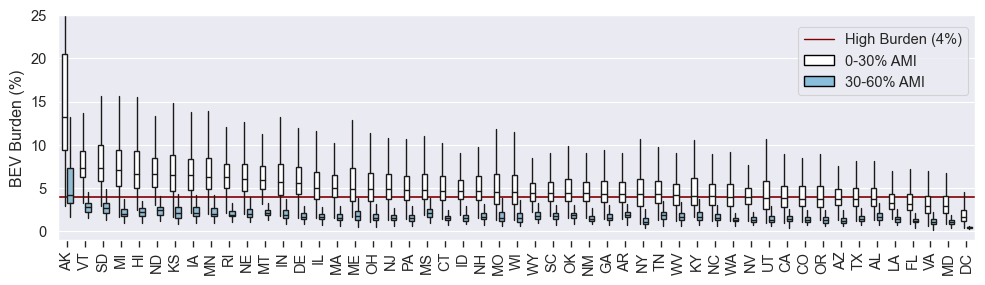

In [63]:
with sns.axes_style(style='darkgrid',rc = {'xtick.bottom': True}):
    # Process data
    df = tract_res_pHHy_bINC[['tract_index','ami_bin','state','TEB_newBEV_base_res']].query('((ami_bin == 0)|(ami_bin == 1))')
    df['TEB_newBEV_base_res'] = df['TEB_newBEV_base_res'] * 100 # convert to percentage
    state_med = df.groupby(by=['state','ami_bin'],as_index=False).median().sort_values(by='TEB_newBEV_base_res',ascending=False)
    state_med.rename(columns={'TEB_newBEV_base_res':'med_TEB_newBEV_base_res'},inplace=True)
    df_wmed = df.merge(state_med,how='left',on=['state','ami_bin']).sort_values(by='med_TEB_newBEV_base_res',ascending=False)

    # Plot
    fig, axes = plt.subplots(1,1,figsize=(10,3))
    palette_lmh = sns.color_palette([sns.color_palette('Dark2')[0],sns.color_palette('Dark2')[5],sns.color_palette('Dark2')[1]])
    color_low = sns.color_palette('Dark2')[0]
    color_mid = sns.color_palette('Dark2')[5]
    color_high = sns.color_palette('Dark2')[1]
    alpha=0.7
    legend_elements = [mlines.Line2D([],[],color='maroon',label='High Burden (4%)',lw=1),
                        Patch(facecolor='white',edgecolor='black',label='0-30% AMI',linewidth=1,alpha=1),
                        Patch(facecolor='#89bedc',edgecolor='black',label='30-60% AMI',linewidth=1,alpha=1)]
    axes.axhline(4,color='maroon',zorder=-1)
    g = sns.boxplot(data=df_wmed,y='TEB_newBEV_base_res',x='state',hue='ami_bin',fliersize=1.2,linewidth=0.5,width=0.6,palette=sns.color_palette(['white','#89bedc']),showfliers=False,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(markerfacecolor='k', markeredgecolor ='k',alpha=1))
    axes.set(xlabel='',ylabel='BEV Burden (%)',ylim=(-1,25))
    axes.tick_params('x',labelrotation=90)
    sns.move_legend(g,'upper right',handles=legend_elements,title=None,bbox_to_anchor=(1,0.98),ncol=1,frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'fig4e_box_BEV_TEB_AMI0_1.png'),bbox_inches='tight')

In [64]:
state_med.query('state=="AK"')

,state,ami_bin,tract_index,med_TEB_newBEV_base_res
0,AK,0.0,1261.0,13.261083
1,AK,1.0,1261.0,4.179849


In [65]:
state_med.query('ami_bin==0')

,state,ami_bin,tract_index,med_TEB_newBEV_base_res
0,AK,0.0,1261.0,13.261083
92,VT,0.0,67373.5,7.353127
82,SD,0.0,59830.0,7.341621
44,MI,0.0,33974.0,7.052603
22,HI,0.0,20407.5,6.623677
56,ND,0.0,50232.0,6.615044
32,KS,0.0,26715.5,6.523818
24,IA,0.0,25917.5,6.474683
46,MN,0.0,36020.0,6.313182
78,RI,0.0,58495.5,6.278421


### Charging Access

In [66]:
# results for article:
print('LCOC stats - base res:')
df = scen_base_res['county_cost_by_l'].query('(year==2022)&(POWERTRAIN=="BEV")').merge(fips_state_county[['state','county_name','county_index']],how='left',on='county_index')
display(df[['c_USD']].describe())
# df.sort_values(by='c_USD')
print('LCOC stats - base pub:')
df = scen_base_pub['county_cost_by_l'].query('(year==2022)&(POWERTRAIN=="BEV")').merge(fips_state_county[['state','county_name','county_index']],how='left',on='county_index')
display(df[['c_USD']].describe())
# df.sort_values(by='c_USD')

LCOC stats - base res:


,c_USD
count,9426.000000
mean,0.162505
std,0.041843
min,0.070997
25%,0.144484
50%,0.161874
75%,0.176352
max,0.913967


LCOC stats - base pub:


,c_USD
count,9426.000000
mean,0.227276
std,0.045744
min,0.140604
25%,0.207027
50%,0.222147
75%,0.238495
max,1.112138


In [67]:
# results for article:
TEB_newBEV_hh_AMI0 = tract_res_pHHy_bINC[['cat_TEB_newBEV_base_pub','ami_bin','mult_hh_study_incbin']].query('ami_bin==0').groupby(by=['cat_TEB_newBEV_base_pub','ami_bin']).sum()
TEB_newBEV_hh_AMI0['pct_of_total'] = TEB_newBEV_hh_AMI0['mult_hh_study_incbin'] / TEB_newBEV_hh_AMI0['mult_hh_study_incbin'].sum()
display(TEB_newBEV_hh_AMI0)

,,mult_hh_study_incbin,pct_of_total
cat_TEB_newBEV_base_pub,ami_bin,,
Low,0.0,0.000967,0.007479
Mid,0.0,0.029023,0.224528
High,0.0,0.099272,0.767993


In [68]:
tract_res_bVC_US[['VEHCLASS','burden','TEB_newBEV_base_res','TEB_newICEV_base_res','TEB_newBEV_base_pub']].head()

,VEHCLASS,burden,TEB_newBEV_base_res,TEB_newICEV_base_res,TEB_newBEV_base_pub
218494,Sedan,0.035881,0.013947,0.023114,0.017702
218493,SUV,0.035881,0.016978,0.026529,0.023217
218495,Truck,0.035881,0.019901,0.033567,0.028195


In [84]:
# Figure 5
# Plot
gs_kw = dict(width_ratios=[0.5, 1, 1], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['left','right','right'],
                               ['left','right','right']],
                              gridspec_kw=gs_kw, figsize=(9, 4),constrained_layout=True)

# (a) LCOC - Box
df1 = scen_base_res['county_cost_by_l'].query('(year==2022)&(POWERTRAIN=="BEV")')
df1['scenario'] = 'New BEV (Baseline - Residential Charging)'
df2 = scen_base_pub['county_cost_by_l'].query('(year==2022)&(POWERTRAIN=="BEV")')
df2['scenario'] = 'New BEV - (Baseline - Public Charging)'
df_lcoc = pd.concat([df1,df2]).reset_index()
g1 = sns.boxplot(ax=axd['left'],data=df_lcoc,x='scenario',y='c_USD',hue='scenario',palette=sns.color_palette(['white','#89bedc']),width=0.5,fliersize=1,linewidth=1,showfliers=False,showcaps=False) #,medianprops=dict(linewidth=2)
g1.legend([],[], frameon=False)
axd['left'].axis(ymin=0,ymax=0.3)
axd['left'].set_title('(a)',weight='bold')
axd['left'].set(xlabel='',ylabel='LCOC (USD kWh'+'$\u207b$'+'$\mathregular{\u00b9}$'+')')
axd['left'].set_xticks([])

# (b) Transportation Energy Burden - Box, by Income
df = tract_res_pHHy_bINC[['tract_index','ami_bin','TEB_newBEV_base_res','TEB_newBEV_base_pub','TEB_newICEV_base_res','burden_pct']]
df['TEB_newBEV_base_res'] = df['TEB_newBEV_base_res'] * 100
df['TEB_newBEV_base_pub'] = df['TEB_newBEV_base_pub'] * 100
df['TEB_newICEV_base_res'] = df['TEB_newICEV_base_res'] * 100
df = df.melt(id_vars=['tract_index','ami_bin'])
df['scenario'] = np.select(condlist=[df['variable']=='burden_pct',df['variable']=='TEB_newBEV_base_res',df['variable']=='TEB_newBEV_base_pub',df['variable']=='TEB_newICEV_base_res'],
                            choicelist=['Current Vehicle Stock','New BEV (Baseline-Residential)','New BEV (Baseline-Public)','New ICEV (Baseline)'])
axis_ymax = 23
g2 = sns.boxplot(ax=axd['right'],data=df,x='ami_bin',y='value',hue='scenario',palette=sns.color_palette(['white','#89bedc','#2b7bba','lightgray']),width=0.5,linewidth=1,showfliers=False,showcaps=False,fliersize=1) #,medianprops=dict(linewidth=2)
g2.legend([],[], frameon=False)
axd['right'].axis(ymin=0,ymax=axis_ymax)
axd['right'].set_xlabel('AMI')
axd['right'].set_ylabel('Transportation Energy Burden (%)')
axd['right'].set_xticklabels(['0-30%','30-60%','60-80%','80-100%','100-150%','150-200%','200%+'])
axd['right'].set_yticks([2,4,6,8,10,12,14,16,18,20,22])
axd['right'].set_title('(b)',weight='bold')

legend_elements = [Patch(facecolor='white',edgecolor='k',label='New BEV (Baseline-Residential)',linewidth=1,alpha=1),
                    Patch(facecolor='#89bedc',edgecolor='k',label='New BEV (Baseline-Public)',linewidth=1,alpha=1),
                    Patch(facecolor='#2b7bba',edgecolor='k',label='New ICEV (Baseline)',linewidth=1,alpha=1),
                    Patch(facecolor='lightgray',edgecolor='k',label='Current Vehicle Stock',linewidth=1,alpha=1)]
fig.legend(handles=legend_elements,loc='lower center',bbox_to_anchor=(0.5,-0.15),title=None,ncol=2,frameon=False)

plt.savefig(os.path.join(dir.p_fig,'fig5_box_charging.png'),bbox_inches='tight')
plt.savefig(os.path.join(dir.p_fig,'EPS','figure5.eps'),bbox_inches='tight',format='eps')

## Geographic Distribution - Cost & GHG

In [70]:
stats_key_pHHy = tract_res[['vmt_wtd',
                    'burden_svgs_base_res',
                    'lfcs_USDpHHy_base_res',
                    'lces_MTCO2EpHHy_base_res',
                    'burden_svgs_base_pub',
                    'lfcs_USDpHHy_base_pub',
                    'lces_MTCO2EpHHy_base_pub',
                    'burden_svgs_lwr',
                    'lfcs_USDpHHy_lwr',
                    'lces_MTCO2EpHHy_lwr',
                    'burden_svgs_upr',
                    'lfcs_USDpHHy_upr',
                    'lces_MTCO2EpHHy_upr']].describe()

stats_key_pHHy[[x for x in stats_key_pHHy.columns if ('base_res' in x)]]

,burden_svgs_base_res,lfcs_USDpHHy_base_res,lces_MTCO2EpHHy_base_res
count,72054.000000,72054.000000,72054.000000
mean,0.987523,449.322152,3.168815
std,0.614182,270.585348,1.422570
min,-13.358290,-5506.044452,-3.546133
25%,0.616901,273.090203,2.255503
50%,0.898051,414.217243,3.120504
75%,1.266764,595.099030,4.083503
max,12.446011,2003.946058,11.105142


### Box and bar plot

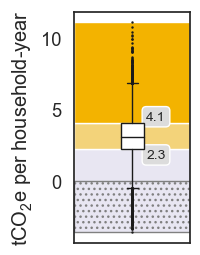

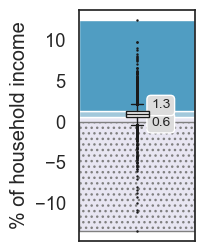

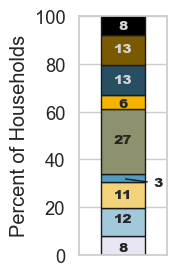

In [71]:
# GHG and Cost Only
with sns.axes_style(style='white',rc={'font.sans-serif':'Arial'}):
    sns.set(style='white',font_scale=1.2)
    bg_alpha = 1
    color_low_ghg = (232/255,230/255,242/255)
    color_mid_ghg = (243/255,211/255,122/255)
    color_high_ghg = (243/255,179/255,0/255)
    color_low_cost = (232/255,230/255,242/255)
    color_mid_cost = (162/255,200/255,219/255)
    color_high_cost = (80/255,157/255,194/255)
    zorder_bkgrd = -2
    # Life Cycle GHG Savings
    fig, axes = plt.subplots(1,1,figsize=(1.5,3))
    axes.axhspan(stats_key_pHHy.loc['min','lces_MTCO2EpHHy_base_res'], stats_key_pHHy.loc['25%','lces_MTCO2EpHHy_base_res'],facecolor=color_low_ghg,alpha=bg_alpha,zorder=zorder_bkgrd)
    axes.axhspan(stats_key_pHHy.loc['min','lces_MTCO2EpHHy_base_res'],0,facecolor=color_low_ghg,edgecolor='gray',alpha=bg_alpha,zorder=zorder_bkgrd,hatch='...')
    axes.axhspan(stats_key_pHHy.loc['25%','lces_MTCO2EpHHy_base_res'],stats_key_pHHy.loc['75%','lces_MTCO2EpHHy_base_res'], facecolor=color_mid_ghg,alpha=bg_alpha,zorder=zorder_bkgrd)
    axes.axhspan(stats_key_pHHy.loc['75%','lces_MTCO2EpHHy_base_res'],stats_key_pHHy.loc['max','lces_MTCO2EpHHy_base_res'], facecolor=color_high_ghg,alpha=bg_alpha,zorder=zorder_bkgrd)
    axes.text(0.12,stats_key_pHHy.loc['25%','lces_MTCO2EpHHy_base_res'],round(stats_key_pHHy.loc['25%','lces_MTCO2EpHHy_base_res'],1),{'fontsize':'x-small','va':'top'},
                bbox=dict(boxstyle="round",fc='gainsboro'),zorder=-1)
    axes.text(0.12,stats_key_pHHy.loc['75%','lces_MTCO2EpHHy_base_res'],round(stats_key_pHHy.loc['75%','lces_MTCO2EpHHy_base_res'],1),{'fontsize':'x-small','va':'bottom'},
                bbox=dict(boxstyle="round",fc='gainsboro'),zorder=-1)
    sns.boxplot(ax=axes,data=tract_res,y='lces_MTCO2EpHHy_base_res',width=0.2,fliersize=1.5,
                boxprops=dict(linewidth=1, facecolor='w', edgecolor='k', alpha=1),
                medianprops=dict(linewidth=1, color='k', alpha=1),
                whiskerprops=dict(linewidth=1, color='k', alpha=1),
                capprops=dict(linewidth=1, color='k', alpha=1),
                flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    axes.set(ylabel='$\mathregular{tCO_2e}$'+' per household-year')
    plt.savefig(os.path.join(dir.p_fig,'fig6b_box_ghg_pHHy.png'),bbox_inches='tight')

    # Fuel Cost Savings
    fig, axes = plt.subplots(1,1,figsize=(1.5,3))
    axes.axhspan(stats_key_pHHy.loc['min','burden_svgs_base_res'],stats_key_pHHy.loc['25%','burden_svgs_base_res'], facecolor=color_low_cost,alpha=bg_alpha,zorder=zorder_bkgrd)
    axes.axhspan(stats_key_pHHy.loc['min','burden_svgs_base_res'], 0,facecolor=color_low_cost,edgecolor='gray',alpha=bg_alpha,zorder=zorder_bkgrd,hatch='...')
    axes.axhspan(stats_key_pHHy.loc['25%','burden_svgs_base_res'],stats_key_pHHy.loc['75%','burden_svgs_base_res'],facecolor=color_mid_cost,alpha=bg_alpha,zorder=zorder_bkgrd)
    axes.axhspan(stats_key_pHHy.loc['75%','burden_svgs_base_res'],stats_key_pHHy.loc['max','burden_svgs_base_res'], facecolor=color_high_cost,alpha=bg_alpha,zorder=zorder_bkgrd)
    axes.text(0.12,stats_key_pHHy.loc['25%','burden_svgs_base_res'],round(stats_key_pHHy.loc['25%','burden_svgs_base_res'],1),{'fontsize':'x-small','va':'top'},
                bbox=dict(boxstyle="round",fc='gainsboro'),zorder=-1)
    axes.text(0.12,stats_key_pHHy.loc['75%','burden_svgs_base_res'],round(stats_key_pHHy.loc['75%','burden_svgs_base_res'],1),{'fontsize':'x-small','va':'bottom'},
                bbox=dict(boxstyle="round",fc='gainsboro'),zorder=-1)
    sns.boxplot(ax=axes,data=tract_res,y='burden_svgs_base_res',width=0.2,fliersize=1.5,
                boxprops=dict(linewidth=1, facecolor='w', edgecolor='k', alpha=1),
                medianprops=dict(linewidth=1, color='k', alpha=1),
                whiskerprops=dict(linewidth=1, color='k', alpha=1),
                capprops=dict(linewidth=1, color='k', alpha=1),
                flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    axes.set(ylabel='% of household income')
    plt.savefig(os.path.join(dir.p_fig,'fig6c_box_burden_svgs_pHHy.png'),bbox_inches='tight')

with sns.axes_style(style='whitegrid',rc={'font.sans-serif':'Arial'}):
    # Population Distribution
    fig, axes = plt.subplots(1,1,figsize=(2,3))
    pct_hh_r3 = tract_res.pivot_table(values='mult_hh_study',index=['biv2_cat_pHHy_base_res'],aggfunc='sum',margins=True).reset_index().query('biv2_cat_pHHy_base_res != "All"')
    pct_hh_r3['biv2_cat_pHHy_base_res'] = pd.Categorical(pct_hh_r3['biv2_cat_pHHy_base_res'],['High_High','High_Mid','Mid_High','High_Low','Mid_Mid','Low_High','Mid_Low','Low_Mid','Low_Low'])
    pct_hh_r3 = pct_hh_r3.sort_values(by='biv2_cat_pHHy_base_res',ascending=False).set_index('biv2_cat_pHHy_base_res')
    pct_hh_r3_plot = pct_hh_r3.copy()
    pct_hh_r3_plot['pct_hh_study'] = pct_hh_r3_plot['mult_hh_study'] * 100
    pct_hh_r3_plot = pct_hh_r3_plot[['pct_hh_study']].transpose()
    palette_biv = {'High_High':(0/255,0/255,0/255), 'High_Low':(243/255,179/255,0/255), 'High_Mid':(122/255,90/255,0/255), 'Low_High':(80/255,157/255,194/255), 'Low_Low':(232/255,230/255,242/255), 'Low_Mid':(162/255,200/255,219/255),'Mid_High':(40/255,79/255,97/255), 'Mid_Low':(243/255,211/255,122/255), 'Mid_Mid':(142/255,145/255,110/255)}
    pct_hh_r3_plot.plot(ax=axes,kind='bar',stacked=True,color=palette_biv,edgecolor='k',legend=None,ylabel='Percent of Households',ylim=(0,100))
    axes.text(0,96,round(pct_hh_r3.loc['High_High','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center','c':'lightgray'},zorder=1)
    axes.text(0,86,round(pct_hh_r3.loc['High_Mid','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center','c':'lightgray'},zorder=1)
    axes.text(0,73,round(pct_hh_r3.loc['Mid_High','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center','c':'lightgray'},zorder=1)
    axes.text(0,63,round(pct_hh_r3.loc['High_Low','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center'},zorder=1)
    axes.text(0,48,round(pct_hh_r3.loc['Mid_Mid','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center'},zorder=1)
    axes.text(0,25,round(pct_hh_r3.loc['Mid_Low','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center'},zorder=1)
    axes.text(0,15,round(pct_hh_r3.loc['Low_Mid','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center'},zorder=1)
    axes.text(0,3,round(pct_hh_r3.loc['Low_Low','mult_hh_study']*100),{'fontsize':'x-small','weight':'black','va':'center','ha':'center'},zorder=1)
    axes.annotate(3,xy=(0,32), xycoords='data',
            xytext=(0.4,30), textcoords='data',
            arrowprops=dict(arrowstyle='-',color='k'),
            fontsize='x-small',weight='black',va='center',ha='center')
    plt.xticks([])
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'fig6a_bivar_hh_pHHy.png'),bbox_inches='tight')

In [72]:
# biv2_cat = GHG + Fuel Burden Savings rankings
# No Low
# cat_lces_pm_base_res
print('No low svgs households - state:')
pct_hh_r3_no_l = tract_res.query('(cat_lces_pHHy_base_res!="Low")&(cat_burden_svgs_base_res!="Low")').pivot_table(values='mult_hh_study',index=['biv2_cat_pHHy_base_res'],aggfunc='sum',margins=True).sort_values(by='mult_hh_study',ascending=False)
pct_hh_r3_no_l['pct_cumulative'] = pct_hh_r3_no_l['mult_hh_study'].cumsum()
display(pct_hh_r3_no_l.head(5))

print('bivariate household pcts:')
pct_hh_r3 = tract_res.pivot_table(values='mult_hh_study',index=['biv2_cat_pHHy_base_res'],aggfunc='sum',margins=True)
display(pct_hh_r3)

# High-high households
print('High-high households - state:')
state_pct_hh_r3_hh = tract_res.query('biv2_cat_pHHy_base_res=="High_High"').pivot_table(values='mult_hh_study',index=['state'],aggfunc='sum').sort_values(by='mult_hh_study',ascending=False).reset_index()
state_pct_hh_r3_hh['pct_cumulative'] = state_pct_hh_r3_hh['mult_hh_study'].cumsum()
display(state_pct_hh_r3_hh.head(5))
# print('High-high households - state & county:')
# county_pct_hh_r3_hh = tract_res.query('biv2_cat_pHHy_base_res=="High_High"').pivot_table(values='mult_hh_study',index=['state','county_name'],aggfunc='sum').sort_values(by='mult_hh_study',ascending=False).reset_index()
# county_pct_hh_r3_hh['pct_cumulative'] = county_pct_hh_r3_hh['mult_hh_study'].cumsum()
# display(county_pct_hh_r3_hh.head(5))

# Low-low households
print('Low-low households - state:')
state_pct_hh_r3_ll = tract_res.query('biv2_cat_pHHy_base_res=="Low_Low"').pivot_table(values='mult_hh_study',index=['state'],aggfunc='sum').sort_values(by='mult_hh_study',ascending=False).reset_index()
state_pct_hh_r3_ll['pct_cumulative'] = state_pct_hh_r3_ll['mult_hh_study'].cumsum()
display(state_pct_hh_r3_ll.head(6))
# print('Low-low households - state & county:')
# county_pct_hh_r3_ll = tract_res.query('biv2_cat_pHHy_base_res=="Low_Low"').pivot_table(values='mult_hh_study',index=['state','county_name'],aggfunc='sum').sort_values(by='mult_hh_study',ascending=False).reset_index()
# county_pct_hh_r3_ll['pct_cumulative'] = county_pct_hh_r3_ll['mult_hh_study'].cumsum()
# display(county_pct_hh_r3_ll.head(5))

# Mid GHG-Mid cost svgs households
print('Mid GHG-Mid cost svgs households - state:')
state_pct_hh_r3_mm = tract_res.query('biv2_cat_pHHy_base_res=="Mid_Mid"').pivot_table(values='mult_hh_study',index=['state'],aggfunc='sum').sort_values(by='mult_hh_study',ascending=False).reset_index()
state_pct_hh_r3_mm['pct_cumulative'] = state_pct_hh_r3_mm['mult_hh_study'].cumsum()
display(state_pct_hh_r3_mm.head(5))

# # High GHG-low cost svgs households
# print('High GHG-low cost svgs households - state:')
# pct_hh_r3_hl = tract_res.query('biv2_cat_pHHy_base_res=="High_Low"').pivot_table(values='mult_hh_study',index=['state'],aggfunc='sum').sort_values(by='mult_hh_study',ascending=False)
# pct_hh_r3_hl['pct_cumulative'] = pct_hh_r3_hl['mult_hh_study'].cumsum()
# display(pct_hh_r3_hl.head(5))

# # Low GHG-High cost svgs households
# print('Low GHG-High cost svgs households - state:')
# pct_hh_r3_lh = tract_res.query('biv2_cat_pHHy_base_res=="Low_High"').pivot_table(values='mult_hh_study',index=['state'],aggfunc='sum').sort_values(by='mult_hh_study',ascending=False)
# pct_hh_r3_lh['pct_cumulative'] = pct_hh_r3_lh['mult_hh_study'].cumsum()
# display(pct_hh_r3_lh.head(5))

No low svgs households - state:


,mult_hh_study,pct_cumulative
biv2_cat_pHHy_base_res,,
All,0.603842,0.603842
Mid_Mid,0.273537,0.877380
Mid_High,0.125571,1.002951
High_Mid,0.125421,1.128372
High_High,0.079313,1.207685


bivariate household pcts:


,mult_hh_study
biv2_cat_pHHy_base_res,
High_High,0.079313
High_Low,0.057806
High_Mid,0.125421
Low_High,0.033512
Low_Low,0.080742
Low_Mid,0.117948
Mid_High,0.125571
Mid_Low,0.106150
Mid_Mid,0.273537


High-high households - state:


,state,mult_hh_study,pct_cumulative
0,CA,0.029170,0.029170
1,WA,0.013078,0.042248
2,NY,0.009699,0.051948
3,OR,0.006122,0.058070
4,AZ,0.005297,0.063367


Low-low households - state:


,state,mult_hh_study,pct_cumulative
0,MI,0.016144,0.016144
1,OH,0.007229,0.023374
2,IN,0.005097,0.028471
3,MO,0.004866,0.033337
4,NY,0.003270,0.036607
5,TN,0.003105,0.039712


Mid GHG-Mid cost svgs households - state:


,state,mult_hh_study,pct_cumulative
0,TX,0.031541,0.031541
1,FL,0.023835,0.055376
2,CA,0.020803,0.076178
3,PA,0.020312,0.096490
4,GA,0.016605,0.113095


### State ranking charts

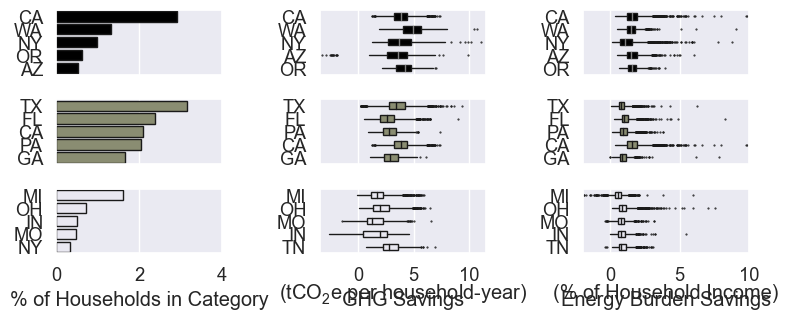

In [73]:
# state ranking charts
with sns.plotting_context(font_scale=0.75):
    fig, axes = plt.subplots(3,3,figsize=(8,3.5))
    sns.axes_style(style='whitegrid')
    # colors
    color_ll = (232/255,230/255,242/255)
    color_mm = (142/255,145/255,110/255)
    color_hh = (0/255,0/255,0/255)

    # High-High
    state_pct_hh_r3_hh['pct_hh_study'] = state_pct_hh_r3_hh['mult_hh_study'] * 100
    sns.barplot(ax=axes[0,0],data=state_pct_hh_r3_hh.head(5),x='pct_hh_study',y='state',color=color_hh,edgecolor='k')
    sns.boxplot(ax=axes[0,1],data=tract_res.query('(state=="CA")|(state=="WA")|(state=="NY")|(state=="AZ")|(state=="OR")'),x='lces_MTCO2EpHHy_base_res',y='state',order=['CA','WA','NY','AZ','OR'],
                    fliersize=1,color=color_hh,width=0.5,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='gray', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    sns.boxplot(ax=axes[0,2],data=tract_res.query('(state=="CA")|(state=="WA")|(state=="NY")|(state=="AZ")|(state=="OR")'),x='burden_svgs_base_res',y='state',order=['CA','WA','NY','AZ','OR'],
                    fliersize=1,color=color_hh,width=0.5,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='gray', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))

    # axes
    axes[0,0].set(xlabel='',xlim=(0,4),ylabel='',xticklabels=[])
    axes[0,1].set(xlabel='',xlim=(-3.5,11.5),ylabel='',xticklabels=[])
    axes[0,2].set(xlabel='',xlim=(-2,10),ylabel='',xticklabels=[])

    # Mid-Mid
    state_pct_hh_r3_mm['pct_hh_study'] = state_pct_hh_r3_mm['mult_hh_study'] * 100
    sns.barplot(ax=axes[1,0],data=state_pct_hh_r3_mm.head(5),x='pct_hh_study',y='state',color=color_mm,edgecolor='k')
    sns.boxplot(ax=axes[1,1],data=tract_res.query('(state=="TX")|(state=="FL")|(state=="PA")|(state=="CA")|(state=="GA")'),x='lces_MTCO2EpHHy_base_res',y='state',order=['TX','FL','PA','CA','GA'],
                    fliersize=1,color=color_mm,width=0.5,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    sns.boxplot(ax=axes[1,2],data=tract_res.query('(state=="TX")|(state=="FL")|(state=="PA")|(state=="CA")|(state=="GA")'),x='burden_svgs_base_res',y='state',order=['TX','FL','PA','CA','GA'],
                    fliersize=1,color=color_mm,width=0.5,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))

    # labels
    axes[1,0].set(xlabel='',xlim=(0,4),ylabel='',xticklabels=[])
    axes[1,1].set(xlabel='',xlim=(-3.5,11.5),ylabel='',xticklabels=[])
    axes[1,2].set(xlabel='',xlim=(-2,10),ylabel='',xticklabels=[])

    # Low-Low
    state_pct_hh_r3_ll['pct_hh_study'] = state_pct_hh_r3_ll['mult_hh_study'] * 100
    sns.barplot(ax=axes[2,0],data=state_pct_hh_r3_ll.head(5),x='pct_hh_study',y='state',color=color_ll,edgecolor='k')
    sns.boxplot(ax=axes[2,1],data=tract_res.query('(state=="MI")|(state=="OH")|(state=="MO")|(state=="IN")|(state=="TN")'),x='lces_MTCO2EpHHy_base_res',y='state',order=['MI','OH','MO','IN','TN'],
                    fliersize=1,color=color_ll,width=0.5,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    sns.boxplot(ax=axes[2,2],data=tract_res.query('(state=="MI")|(state=="OH")|(state=="MO")|(state=="IN")|(state=="TN")'),x='burden_svgs_base_res',y='state',order=['MI','OH','MO','IN','TN'],
                    fliersize=1,color=color_ll,width=0.5,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    # labels
    axes[2,0].set(xlabel='% of Households in Category',xlim=(0,4),ylabel='')
    axes[2,1].set(xlabel='GHG Savings',xlim=(-3.5,11.5),ylabel='')
    axes[2,1].text(0.5,-0.7,'('+'$\mathregular{tCO_2e}$'+' per household-year)',ha='center',transform=axes[2,1].transAxes)
    axes[2,2].set(xlabel='Energy Burden Savings',xlim=(-2,10),ylabel='')
    axes[2,2].text(0.5,-0.7,'(% of Household Income)',ha='center',transform=axes[2,2].transAxes)

    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'fig6d_hh_mm_ll_rank.png'),bbox_inches='tight')

### Similar-Performing Areas

In [74]:
print('% of households with less than 5% difference b/w ICEV and BEV GHG results:')
display(tract_res.query('(pct_diff_lce_BEV_ICEV_base_res<5)')[['mult_hh_study']].sum()*100)
tract_res[['state','county_name','lce_MTCO2EpHHy_ICEV_base_res','lce_MTCO2EpHHy_BEV_base_res','lces_gCO2Epm_base_res','pct_diff_lce_BEV_ICEV_base_res']].query('pct_diff_lce_BEV_ICEV_base_res<5')

print('% of households with less than 5% difference b/w ICEV and BEV fuel cost results:')
display(tract_res.query('(pct_diff_lfc_BEV_ICEV_base_res<5)')[['mult_hh_study']].sum()*100)
tract_res[['state','county_name','lfc_USDpHHy_ICEV_base_res','lfc_USDpHHy_BEV_base_res','lfcs_USDpm_base_res','pct_diff_lfc_BEV_ICEV_base_res']].query('pct_diff_lfc_BEV_ICEV_base_res<5')

# print('% of households with less than 5% difference b/w ICEV and BEV GHG & fuel cost results:')
# display(tract_res.query('(pct_diff_lce_BEV_ICEV_base_res<5)&(pct_diff_lfc_BEV_ICEV_base_res<5)')[['mult_hh_study']].sum()*100)

print('% of households with greater than 5% difference b/w ICEV and BEV GHG results & BEV performs worse:')
display(tract_res.query('(pct_diff_lce_BEV_ICEV_base_res>5)&(sign_lces_gCO2Epm_base_res=="Negative")')[['mult_hh_study']].sum()*100)
tract_res.query('(pct_diff_lce_BEV_ICEV_base_res>5)&(sign_lces_gCO2Epm_base_res=="Negative")')[['state','county_name','lce_MTCO2EpHHy_ICEV_base_res','lce_MTCO2EpHHy_BEV_base_res','lces_gCO2Epm_base_res','lces_MTCO2EpHHy_base_res','pct_diff_lce_BEV_ICEV_base_res']].sort_values(by='pct_diff_lce_BEV_ICEV_base_res')

print('% of households with greater than 5% difference b/w ICEV and BEV fuel cost results & BEV performs worse:')
display(tract_res.query('(pct_diff_lfc_BEV_ICEV_base_res>5)&(sign_lfcs_USDpm_base_res=="Negative")')[['mult_hh_study']].sum()*100)
tract_res.query('(pct_diff_lfc_BEV_ICEV_base_res>5)&(sign_lfcs_USDpm_base_res=="Negative")')[['state','county_name','lfc_USDpHHy_ICEV_base_res','lfc_USDpHHy_BEV_base_res','lfcs_USDpm_base_res','pct_diff_lfc_BEV_ICEV_base_res']]

# print('% of households with greater than 5% difference b/w ICEV and BEV GHG & fuel cost results & BEV performs worse:')
# display(tract_res.query('(pct_diff_lce_BEV_ICEV_base_res>5)&(pct_diff_lfc_BEV_ICEV_base_res>5)&(sign_lfcs_USDpm_base_res=="Negative")')[['mult_hh_study']].sum()*100)

print('% of households with some savings:')
tract_res.query('((cat_lfcs_pHHy_base_res=="Low")|(cat_lces_pHHy_base_res=="Low"))&((pct_diff_lce_BEV_ICEV_base_res>5)&(pct_diff_lfc_BEV_ICEV_base_res>5))&((sign_lces_gCO2Epm_base_res=="Positive")&(sign_lfcs_USDpm_base_res=="Positive"))')[['mult_hh_study']].sum()*100

% of households with less than 5% difference b/w ICEV and BEV GHG results:


mult_hh_study    1.041437
dtype: float64

% of households with less than 5% difference b/w ICEV and BEV fuel cost results:


mult_hh_study    1.297047
dtype: float64

% of households with greater than 5% difference b/w ICEV and BEV GHG results & BEV performs worse:


mult_hh_study    1.253306
dtype: float64

% of households with greater than 5% difference b/w ICEV and BEV fuel cost results & BEV performs worse:


mult_hh_study    0.758495
dtype: float64

% of households with some savings:


mult_hh_study    30.649732
dtype: float64

## Sensitivity Analysis

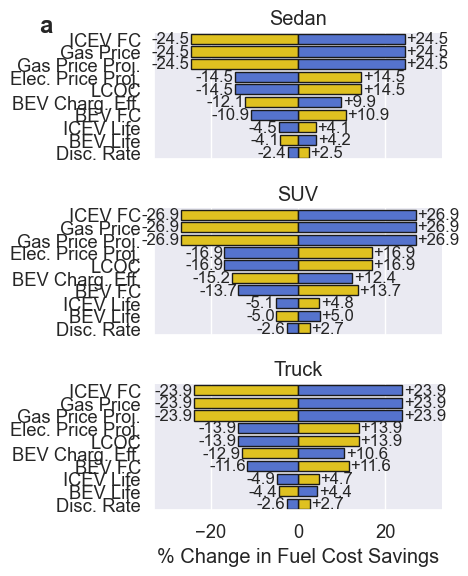

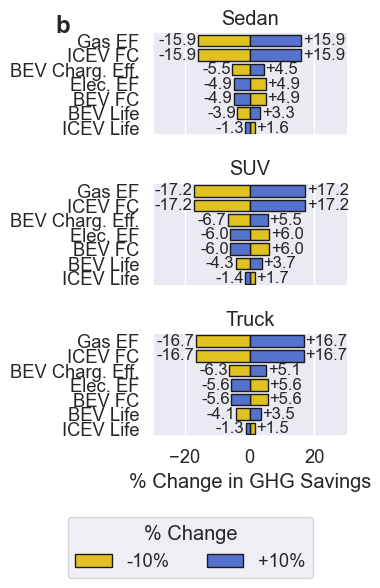

In [75]:
# Sensitivity analysis results by vehicle class
# fuel costs
county_svgs_bVC_plot = county_svgs_bVC_pct_chg.reset_index().query('county_index == 3142')[['county_index','VEHCLASS','lfcs_USDpm','scenario_bnd']]
county_svgs_bVC_plot = county_svgs_bVC_plot.merge(scenario_df,how='left',on='scenario_bnd')
county_svgs_bVC_plot = county_svgs_bVC_plot.query('(lfcs_USDpm != 0)&(scenario_type =="sensitivity")')
county_svgs_bVC_plot = county_svgs_bVC_plot.sort_values(by='lfcs_USDpm')
g = sns.catplot(kind='bar',data=county_svgs_bVC_plot,y='scenario_name',row='VEHCLASS',x='lfcs_USDpm',hue='bnd_name',ci=None,dodge=False,edgecolor='k',
                orient='h',height=2,aspect=2.5,legend=False,palette=['gold','royalblue'])
g.set_axis_labels('% Change in Fuel Cost Savings','')
g.set_titles(row_template='{row_name}')
for i in range(len(g.axes)):
    g.axes[i,0].set(xlim=(-33,33))
    for c in g.axes[i,0].containers:
        g.axes[i,0].bar_label(c,fmt='%+.1f',label_type='edge',fontsize='small',padding=1)
plt.text(x=-0.4,y=1,s='a',fontdict={'fontweight':'bold','fontsize':'large'},transform=g.axes[0,0].transAxes)
plt.savefig(os.path.join(dir.p_fig,'figS15_SA_US_a.png'),bbox_inches='tight')

# GHG emissions
county_svgs_bVC_plot = county_svgs_bVC_pct_chg.reset_index().query('county_index == 3142')[['county_index','VEHCLASS','lces_gCO2Epm','scenario_bnd']]
county_svgs_bVC_plot = county_svgs_bVC_plot.merge(scenario_df,how='left',on='scenario_bnd')
county_svgs_bVC_plot = county_svgs_bVC_plot.query('(lces_gCO2Epm != 0)&(scenario_type =="sensitivity")')
county_svgs_bVC_plot = county_svgs_bVC_plot.sort_values(by='lces_gCO2Epm')
g = sns.catplot(kind='bar',data=county_svgs_bVC_plot,y='scenario_name',row='VEHCLASS',x='lces_gCO2Epm',hue='bnd_name',ci=None,dodge=False,edgecolor='k',
                orient='h',height=1.75,aspect=2.5,palette=['gold','royalblue'])
g.set_axis_labels('% Change in GHG Savings','')
g._legend.set_title('% Change')
g.set_titles(row_template='{row_name}')

for i in range(len(g.axes)):
    g.axes[i,0].set(xlim=(-30,30))
    for c in g.axes[i,0].containers:
        g.axes[i,0].bar_label(c,fmt='%+.1f',label_type='edge',fontsize='small',padding=1)
plt.text(x=-0.5,y=1,s='b',fontdict={'fontweight':'bold','fontsize':'large'},transform=g.axes[0,0].transAxes)
sns.move_legend(g,'upper center',bbox_to_anchor=(0.5,0.01),ncol=2,frameon=True)
plt.savefig(os.path.join(dir.p_fig,'figS15_SA_US_b.png'),bbox_inches='tight')

In [76]:
# figure S15 data
df_S15 = county_svgs_bVC_pct_chg.reset_index().query('county_index == 3142')[['county_index','VEHCLASS','lfcs_USDpm','lces_gCO2Epm','scenario_bnd']]
df_S15 = df_S15.merge(scenario_df,how='left',on='scenario_bnd')
df_S15 = df_S15.query('(scenario_type =="sensitivity")')
df_S15 = df_S15.reindex(columns=['VEHCLASS','scenario_bnd','scenario_name','bnd_name','lfcs_USDpm','lces_gCO2Epm'])
df_S15.rename(columns={'VEHCLASS':'vehclass','lfcs_USDpm':'pct_chg_lfcs','lces_gCO2Epm':'pct_chg_lces'},inplace=True)

df_S15.to_csv(os.path.join(dir.p_fig_data,'figS15_data.csv'))

# metadata
df_S15_metadata = {'column_name':['vehclass','scenario_bnd','scenario_name','bnd_name','pct_chg_lfcs','pct_chg_lces'],
                'description':['vehicle class - sedan, SUV = sport utility vehicle, truck = pickup truck',
                                'scenario_bnd - sensitivity scenario and bound (lwr = -10%, upr = +10%)',
                                'name of sensitivity scenario','name of bound',
                                'percent change in national average lifetime fuel cost savings',
                                'percent change in national average life cycle GHG emission savings']}
df_S15_metadata_df = pd.DataFrame(data=df_S15_metadata)
df_S15_metadata_df.to_csv(os.path.join(dir.p_fig_data,'figS15_data_metadata.csv'),index=False)

## Upper and Lower Bounds

In [77]:
tract_res_bVC_US[['VEHCLASS']+[x for x in tract_res_bVC_US if ('pHHy' in x) or ('TEB' in x) or ('burden_svgs' in x)]]

,VEHCLASS,lce_MTCO2EpHHy_ICEV_base_res,lce_MTCO2EpHHy_BEV_base_res,lfc_USDpHHy_ICEV_base_res,lfc_USDpHHy_BEV_base_res,lce_MTCO2EpHHy_ICEV_base_pub,lce_MTCO2EpHHy_BEV_base_pub,lfc_USDpHHy_ICEV_base_pub,lfc_USDpHHy_BEV_base_pub,lce_MTCO2EpHHy_ICEV_lwr,...,lfcs_USDpHHy_lwr,burden_svgs_lwr,TEB_newICEV_lwr,TEB_newBEV_lwr,lces_MTCO2EpHHy_lwr,lfcs_USDpHHy_upr,burden_svgs_upr,TEB_newICEV_upr,TEB_newBEV_upr,lces_MTCO2EpHHy_upr
218494,Sedan,5.336397,2.296249,1082.230385,648.133703,5.336397,2.296249,1082.230385,820.430736,4.847366,...,-374.547888,-0.824607,0.014307,0.022553,1.986537,1273.581732,2.716649,0.034640,0.007474,4.333694
218493,SUV,6.151799,2.899434,1240.007261,788.310855,6.151799,2.899434,1240.007261,1074.697343,5.586222,...,-602.463244,-1.319898,0.016196,0.029395,1.961379,1404.746180,3.001056,0.039817,0.009807,4.888164
218495,Truck,7.755760,3.517775,1569.553255,923.393417,7.755760,3.517775,1569.553255,1304.058998,7.039668,...,-702.183103,-1.543886,0.020584,0.036023,2.639614,1800.249999,3.843527,0.050296,0.011861,6.247690


In [78]:
# national averages by vehicle class
df = tract_res_bVC_US[['VEHCLASS']+[x for x in tract_res_US if (('lces' in x)&('pHHy' in x)) or (('lfcs' in x)&('pHHy' in x)) or ('burden_svgs' in x)]]
print('worst case for BEV:')
display(df[['VEHCLASS']+[x for x in df.columns if ('lwr' in x)]])
print('best case for BEV:')
df[['VEHCLASS']+[x for x in df.columns if ('upr' in x)]]

worst case for BEV:


,VEHCLASS,lfcs_USDpHHy_lwr,burden_svgs_lwr,lces_MTCO2EpHHy_lwr
218494,Sedan,-374.547888,-0.824607,1.986537
218493,SUV,-602.463244,-1.319898,1.961379
218495,Truck,-702.183103,-1.543886,2.639614


best case for BEV:


,VEHCLASS,lfcs_USDpHHy_upr,burden_svgs_upr,lces_MTCO2EpHHy_upr
218494,Sedan,1273.581732,2.716649,4.333694
218493,SUV,1404.746180,3.001056,4.888164
218495,Truck,1800.249999,3.843527,6.247690


In [79]:
# truck relative to sedan - burden
df = tract_res_bVC_US[['VEHCLASS','TEB_newICEV_base_res','TEB_newBEV_base_res']].set_index('VEHCLASS')
print('truck energy burdens to sedan energy burdens - ICEV:')
display(df.loc['Truck','TEB_newICEV_base_res'] / df.loc['Sedan','TEB_newICEV_base_res'])
print('truck energy burdens to sedan energy burdens - BEV:')
display(df.loc['Truck','TEB_newBEV_base_res'] / df.loc['Sedan','TEB_newBEV_base_res'])

truck energy burdens to sedan energy burdens - ICEV:


1.4522459650651538

truck energy burdens to sedan energy burdens - BEV:


1.4268671648175972

In [80]:
# ICEV to BEV - burden
df['TEB_newICEV_to_newBEV'] = df['TEB_newICEV_base_res'] / df['TEB_newBEV_base_res']
df

,TEB_newICEV_base_res,TEB_newBEV_base_res,TEB_newICEV_to_newBEV
VEHCLASS,,,
Sedan,0.023114,0.013947,1.657272
SUV,0.026529,0.016978,1.562502
Truck,0.033567,0.019901,1.686749


In [81]:
# # national averages - population and VC weighted
# tract_res_US_summ = tract_res_US[[x for x in tract_res_US if (('lces' in x)&('pHHy' in x)) or ('burden_svgs' in x)]]
# tract_res_US_summ = tract_res_US_summ.reindex(sorted(tract_res_US_summ.columns),axis=1)
# print('worst case for BEV:')
# display(tract_res_US_summ[[x for x in tract_res_US_summ.columns if ('lwr' in x)]])
# print('best case for BEV:')
# display(tract_res_US_summ[[x for x in tract_res_US_summ.columns if ('upr' in x)]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


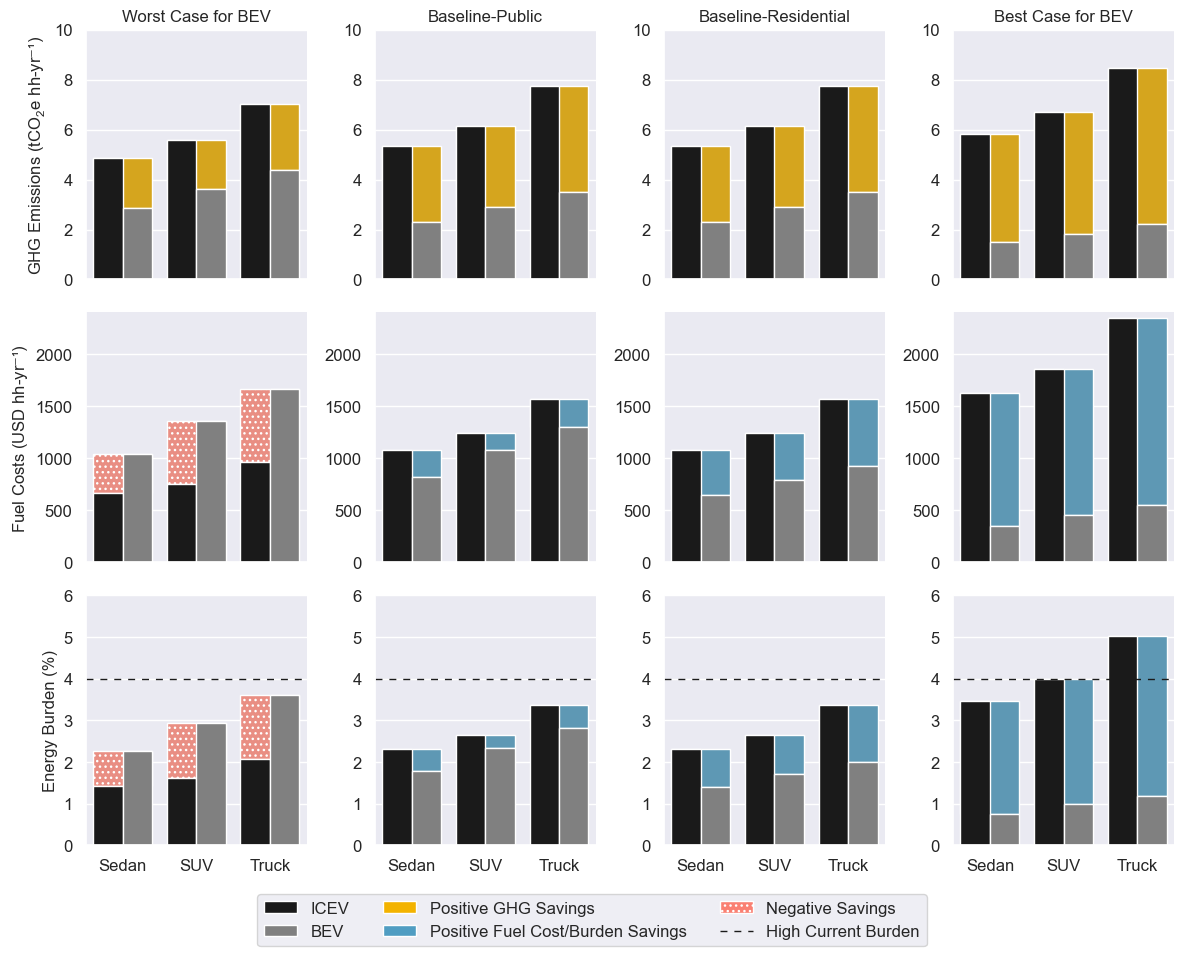

In [82]:
# Figure 7 - showing national average results by vehicle class
with sns.plotting_context(rc={'font.size':12, 'axes.labelsize': 12,'axes.titlesize': 12,'xtick.labelsize': 12,'ytick.labelsize': 12,'legend.fontsize': 12,'legend.title_fontsize': 12}):
    sns.axes_style(style='darkgrid')
    # Manipulate Data
    scenario_name_map = {'res':'Baseline','lwr':'Worst Case for BEV','pub':'Public-Only Charging','upr':'Best Case for BEV'}
    metric_type_map = {'lce':'GHG','lces':'GHG','lfc':'Fuel Cost','lfcs':'Fuel Cost','TEB':'Transportation Energy Burden','burden':'Transportation Energy Burden'}
    df_scen_bVC_US = tract_res_bVC_US[['VEHCLASS']+[x for x in tract_res_bVC_US if ('pHHy' in x) or ('TEB' in x) or ('burden_svgs' in x)]]
    df_scen_bVC_US = df_scen_bVC_US.reindex(sorted(df_scen_bVC_US.columns),axis=1).set_index('VEHCLASS')
    df_scen_bVC_US_l = df_scen_bVC_US.reset_index().melt(id_vars=['VEHCLASS'],value_vars=[x for x in df_scen_bVC_US.columns if 'VECLASS' not in x])
    df_scen_bVC_US_l['VEHCLASS'] = pd.Categorical(df_scen_bVC_US_l['VEHCLASS'],['Sedan','SUV','Truck'])
    df_scen_bVC_US_l['scen'] = df_scen_bVC_US_l['variable'].str[-3:]
    df_scen_bVC_US_l['scen_name'] = df_scen_bVC_US_l['scen'].map(scenario_name_map)
    df_scen_bVC_US_l['POWERTRAIN'] = np.select(condlist=[df_scen_bVC_US_l['variable'].str.contains('BEV'),df_scen_bVC_US_l['variable'].str.contains('ICEV')],choicelist=['BEV','ICEV'],default=np.nan)
    df_scen_bVC_US_l['POWERTRAIN'] = pd.Categorical(df_scen_bVC_US_l['POWERTRAIN'],['ICEV','BEV'])
    df_scen_bVC_US_l[['metric','metric_detail']] = df_scen_bVC_US_l['variable'].str.split(pat='_',n=1,expand=True)
    df_scen_bVC_US_l['metric_type'] = df_scen_bVC_US_l['metric'].map(metric_type_map)
    df_scen_bVC_US_l.loc[df_scen_bVC_US_l['metric']=='TEB','value'] = df_scen_bVC_US_l.loc[df_scen_bVC_US_l['metric']=='TEB','value']*100 # convert TEB values to pct

    df_scen_bVC_US_l_no_svgs = df_scen_bVC_US_l.query('(metric != "lfcs")&(metric != "lces")&(metric!="burden")')
    df_scen_bVC_US_l_svgs = df_scen_bVC_US_l.query('(metric == "lfcs")|(metric == "lces")|(metric=="burden")')
    df_scen_bVC_US_l_svgs = (df_scen_bVC_US_l_svgs.merge(df_scen_bVC_US_l.query('POWERTRAIN == "BEV"')[['VEHCLASS','metric_type','scen','value']]
                                .rename(columns={'value':'bottom_BEV'}),how='left',on=['VEHCLASS','metric_type','scen']))

    # Plot
    order_scen = ['lwr','pub','res','upr']
    order_metric = ['lce','lfc','TEB']
    axis_ymax = [10,2400,6]
    label_y = ['GHG Emissions ($\mathregular{tCO_2e}$ hh-yr'+'$\u207b$'+'$\mathregular{\u00b9}$'+')','Fuel Costs (USD hh-yr'+'$\u207b$'+'$\mathregular{\u00b9}$'+')','Energy Burden (%)']
    col_titles = ['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV']
    legend_elements = [Patch(facecolor='k',label='ICEV'),
                    Patch(facecolor='gray',label='BEV'),
                    Patch(facecolor=color_high_ghg,label='Positive GHG Savings',alpha=1),
                    Patch(facecolor=color_high_cost,label='Positive Fuel Cost/Burden Savings',alpha=1),
                    Patch(facecolor='salmon',label='Negative Savings',alpha=1,hatch='...'),
                    mlines.Line2D([],[],color='k',label='High Current Burden',dashes=(5,5),lw=1)]

    g = sns.FacetGrid(data=df_scen_bVC_US_l_no_svgs,col='scen',col_order=order_scen,row='metric',row_order=order_metric,sharey=False,height=3,aspect=1)
    for i,met in enumerate(['lce','lfc','TEB']):
        g.axes[i,0].set_ylabel(label_y[i])
        for j,scen in enumerate(order_scen):
            if met in ['lce','lfc']:
                df = df_scen_bVC_US_l_svgs.query(f'(metric=="{met}s")&(scen=="{scen}")').sort_values(by=['POWERTRAIN','VEHCLASS'])
            elif met in ['TEB']:
                df = df_scen_bVC_US_l_svgs.query(f'(metric=="burden")&(scen=="{scen}")').sort_values(by=['POWERTRAIN','VEHCLASS'])
            if not((i>=1)&(j==0)):
                if i==0:
                    sns.barplot(ax=g.axes[i,j],data=df,x='VEHCLASS',y='value',bottom=df['bottom_BEV'],color=color_high_ghg,fill=True,alpha=1,edgecolor='w')
                elif i==1:
                    sns.barplot(ax=g.axes[i,j],data=df,x='VEHCLASS',y='value',bottom=df['bottom_BEV'],color=color_high_cost,fill=True,alpha=1,edgecolor='w')
                elif i==2:
                    sns.barplot(ax=g.axes[i,j],data=df,x='VEHCLASS',y='value',bottom=df['bottom_BEV'],color=color_high_cost,fill=True,alpha=1,edgecolor='w')
            elif (i>=1)&(j==0):
                sns.barplot(ax=g.axes[i,j],data=df,x='VEHCLASS',y='value',bottom=df['bottom_BEV'],color='salmon',fill=True,alpha=1,edgecolor='w',hatch='...')
            plt.ioff()
    g.map_dataframe(sns.barplot,x='VEHCLASS',y='value',hue='POWERTRAIN',palette={'ICEV':'k','BEV':'gray'})
    for i,met in enumerate(['lce','lfc','TEB']):
        g.axes[i,0].set_ylabel(label_y[i])
        for j,scen in enumerate(order_scen):
            df_met = df_scen_bVC_US_l.query(f'(metric=="{met}")').sort_values(by=['POWERTRAIN','VEHCLASS'])
            g.axes[i,j].axis(ymax=axis_ymax[i])
            g.axes[i,j].set_title(None)
            g.axes[2,j].set_xlabel(None)
            if i == 0:
                g.axes[i,j].set_title(col_titles[j])
            if i == 2:
                g.axes[i,j].axhline(y=4,color='k',dashes=(5,5),lw=1)

    plt.figlegend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5,-0.07),ncol=3)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'fig7_bar_key_pHHy_bVC.png'),bbox_inches='tight')
    plt.savefig(os.path.join(dir.p_fig,'EPS','figure7.eps'),bbox_inches='tight',format='eps')

In [83]:
# Data for Figure 7
scenario_name_map = {'res':'Baseline-Residential Charging','lwr':'Worst Case for BEV','pub':'Baseline-Public Charging','upr':'Best Case for BEV'}
df_fig7 = tract_res_bVC_US[['VEHCLASS']+[x for x in tract_res_bVC_US if ('pHHy' in x) or ('TEB' in x) or ('burden_svgs' in x)]]
df_fig7_l = df_fig7.reset_index().melt(id_vars=['VEHCLASS'],value_vars=[x for x in df_fig7.columns if 'VECLASS' not in x])
df_fig7_l['VEHCLASS'] = pd.Categorical(df_fig7_l['VEHCLASS'],['Sedan','SUV','Truck'])
df_fig7_l['scen'] = df_fig7_l['variable'].str[-3:]
df_fig7_l['scenario'] = df_fig7_l['scen'].map(scenario_name_map)
df_fig7_l['POWERTRAIN'] = np.select(condlist=[df_fig7_l['variable'].str.contains('BEV'),df_fig7_l['variable'].str.contains('ICEV')],choicelist=['BEV','ICEV'],default=np.nan)
df_fig7_l['POWERTRAIN'] = pd.Categorical(df_fig7_l['POWERTRAIN'],['ICEV','BEV'])
df_fig7_l[['metric','metric_detail']] = df_fig7_l['variable'].str.split(pat='_',n=1,expand=True)
df_fig7_l['metric_type'] = df_fig7_l['metric'].map(metric_type_map)
df_fig7_l.loc[df_fig7_l['metric']=='TEB','value'] = df_fig7_l.loc[df_fig7_l['metric']=='TEB','value']*100 # convert TEB values to pct
df_fig7_l = df_fig7_l.reindex(columns=['VEHCLASS','variable','POWERTRAIN','scenario','value'])
df_fig7_l.rename(columns={'VEHCLASS':'vehclass','POWERTRAIN':'powertrain'})
df_fig7_l.to_csv(os.path.join(dir.p_fig_data,'fig7_data.csv'),index=False)

# metadata
df_fig7_metadata = {'column_name':['vehclass', 'variable', 'powertrain', 'scenario', 'value'],
                              'description':['vehicle class - sedan; SUV = sport utility vehicle; truck = pickup truck',
                                            'variable name - [base_res, base_pub, lwr, upr - see scenario column]; [BEV, ICEV - see powertrain column]; burden_svgs = transportation energy burden savings; lce = life cycle emissions; lces = life cycle emission savings; lfc = lifetime fuel costs; lfc = lifetime fuel cost savings; MTCO2EpHHy = metric tons of carbon dioxide equivalents per household-year; TEB = transportation energy burden; USDpHHy = U.S. dollars per household-year',
                                            'powertrain - BEV = battery electric vehicle; ICEV = internal combustion engine vehicle',
                                            'scenario from scenario analysis',
                                            'variable value (see variable for units)']}
df_fig7_metadata_df = pd.DataFrame(data=df_fig7_metadata)
df_fig7_metadata_df.to_csv(os.path.join(dir.p_fig_data,'fig7_data_metadata.csv'),index=False)

In [94]:
# percentage of households with higher BEV costs and GHGs
cols_svgs_sign = [x for x in tract_res.columns if ('sign_' in x) and (('lces' in x)|('lfcs' in x))]

df = tract_res.melt(id_vars=['tract_index','mult_hh_study'],value_vars=cols_svgs_sign,value_name='sign')
results_hh_sign = df.pivot_table(values='mult_hh_study',index=['sign'],columns='variable',aggfunc='sum')
display(results_hh_sign[[x for x in results_hh_sign.columns if ('lwr' in x) or ('upr' in x)]])

print('higher BEV GHG states:')
display(tract_res.query('sign_lces_gCO2Epm_lwr=="Negative"')[['state','mult_hh_study']].groupby('state').sum().sort_values(by='mult_hh_study',ascending=False).head(10))
print('higher BEV fuel cost states:')
tract_res.query('sign_lfcs_USDpm_upr=="Negative"')[['state','mult_hh_study']].groupby('state').sum().sort_values(by='mult_hh_study',ascending=False).head(10)

variable,sign_lces_gCO2Epm_lwr,sign_lces_gCO2Epm_upr,sign_lfcs_USDpm_lwr,sign_lfcs_USDpm_upr
sign,,,,
Negative,0.077169,NaN,0.980791,0.000654
Positive,0.922831,1.0,0.019209,0.999346


higher BEV GHG states:


,mult_hh_study
state,
KY,0.012719
MO,0.012136
WI,0.010610
OH,0.010497
MI,0.008885
IN,0.006030
WV,0.004318
UT,0.003561
WY,0.001931


higher BEV fuel cost states:


,mult_hh_study
state,
AK,0.000510
ME,0.000144


# Supplementary Results

## Vehicle Class Prevalence

In [234]:
with sns.plotting_context(rc={'font.size':12, 'axes.labelsize': 12,'axes.titlesize': 12,'xtick.labelsize': 12,'ytick.labelsize': 12,'legend.fontsize': 12,'legend.title_fontsize': 12}):
    sns.axes_style(style='darkgrid')
    df = nhts_VEHCLASS_byGGVC.copy()
    df['VEHCLASS_PCT'] = df['VEHCLASS_FRAC'] * 100
    df['VEHCLASS'] = pd.Categorical(df['VEHCLASS'],['Sedan','SUV','Truck'])
    g = sns.catplot(kind='bar',data=df,x='VEHCLASS',y='VEHCLASS_PCT',col='geogroup',hue='density_group',col_wrap=3,height=3,aspect=1,palette=sns.color_palette(['#A2C8DB','#284F61','#FFBE02']))
    g.set_axis_labels('','Prevalence (%)')
    g.set_titles(col_template='{col_name}')
    g._legend.set_title('')
    sns.move_legend(g,'upper center',bbox_to_anchor=(0.5,0.05),ncol=3,frameon=True)
    for i in range(len(g.axes)):
        for c in g.axes[i].containers:
            g.axes[i].bar_label(c,fmt='%.0f',label_type='edge',fontsize=12)
    plt.savefig(os.path.join(dir.p_fig,'figS1b_bar_vehclass_prev.png'),bbox_inches='tight')

figS1_data = tract_county_index.merge(GG_VC_df_wide,how='left',on=['county_index','tract_index'],validate='one_to_one')
figS1_data['county_fips'] = figS1_data['county_text'].str[1:]
figS1_data['tract_fips'] = figS1_data['tract_text'].str[1:]
figS1_data = figS1_data.reindex(columns=['county_index','tract_index','county_fips','tract_fips','geogroup','density_group','SUV','Sedan','Truck','state_name','Region_Name','Division_Name'])
figS1_data.to_csv(os.path.join(dir.p_fig_data,'figS1_data.csv'),index=False)

# metadata
df_S1_metadata = {'column_name':['_index', '_fips', 'geogroup','density_group',
                                 'SUV', 'Sedan', 'Truck', 'state_name', 'Region_Name','Division_Name'],
                'description':['simple index used to join files','county/tract FIPS code','one of six geographic groups','density group - urban, suburban, rural based on housing unit density',
                                'SUV - fractional prevalence of sport utility vehicles (SUV)','sedan - fractional prevalence of sedans','Truck - fractional prevalence of pickup trucks',
                                'state name','census region name','census division name']}
df_S1_metadata_df_S1 = pd.DataFrame(data=df_S1_metadata)
df_S1_metadata_df_S1.to_csv(os.path.join(dir.p_fig_data,'figS1_data_metadata.csv'),index=False)

## Fuel Price Projections

In [137]:
# Process data
map_scenario_price_proj = {'ref_gas_cost_sf':'Reference Case',
                            'highoil_gas_cost_sf':'High Oil Price',
                            'lowoil_gas_cost_sf':'Low Oil Price',
                            'ref_com_elec_cost_sf':'Reference Case',
                            'highoil_com_elec_cost_sf':'High Oil Price',
                            'lowoil_com_elec_cost_sf':'Low Oil Price',
                            'ref_res_elec_cost_sf':'Reference Case',
                            'highoil_res_elec_cost_sf':'High Oil Price',
                            'lowoil_res_elec_cost_sf':'Low Oil Price'}

map_fuel_price_proj = {'ref_gas_cost_sf':'Gasoline',
                        'highoil_gas_cost_sf':'Gasoline',
                        'lowoil_gas_cost_sf':'Gasoline',
                        'ref_com_elec_cost_sf':'Commercial Electricity',
                        'highoil_com_elec_cost_sf':'Commercial Electricity',
                        'lowoil_com_elec_cost_sf':'Commercial Electricity',
                        'ref_res_elec_cost_sf':'Residential Electricity',
                        'highoil_res_elec_cost_sf':'Residential Electricity',
                        'lowoil_res_elec_cost_sf':'Residential Electricity'}

eia_aeo_l = eia_aeo.loc[:,'year':'lowoil_res_elec_cost_sf'].query('year!=2019').melt(id_vars='year')
eia_aeo_l['Scenario'] = eia_aeo_l['variable'].map(map_scenario_price_proj)
eia_aeo_l['Fuel'] = eia_aeo_l['variable'].map(map_fuel_price_proj)

# Plot
with sns.plotting_context(rc={'font.size':9, 'axes.labelsize': 9,'axes.titlesize': 9,'xtick.labelsize': 9,'ytick.labelsize': 9,'legend.fontsize': 9,'legend.title_fontsize': 9}):
    sns.axes_style(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(7.5,4.5),sharex=True)
    palette_col = ['k','goldenrod','royalblue']
    sns.set(font_scale=0.9)
    g1 = sns.lineplot(ax=ax,x='year', y='value', hue='Fuel', style='Scenario',data=eia_aeo_l, legend='auto',ci=None,palette=sns.color_palette(palette_col))
    ax.set(xlabel='Year',ylabel='Price Index to 2020')
    sns.move_legend(g1,loc='upper center',bbox_to_anchor=(0.5,-0.15),ncol=2,title=None)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS2_fuel_price_proj.png'),bbox_inches='tight')

## Electricity Grid Projections

In [145]:
scenario_grid_map = {'grid_kgCO2EpkWh_MC':'Mid Case - No New Policy','grid_kgCO2EpkWh_MC35':'Mid Case - 95% Decarbonization by 2035','grid_kgCO2EpkWh_HIRE':'High Renewable Energy Cost'}
df = county_grid_ef_long.melt(id_vars=['state','BA','year'],value_vars=['grid_kgCO2EpkWh_MC','grid_kgCO2EpkWh_MC35','grid_kgCO2EpkWh_HIRE'])
df['Scenario'] = df['variable'].map(scenario_grid_map)

# Plot
with sns.plotting_context(rc={'font.size':9, 'axes.labelsize': 9,'axes.titlesize': 9,'xtick.labelsize': 9,'ytick.labelsize': 9,'legend.fontsize': 9,'legend.title_fontsize': 9}):
    sns.axes_style(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(7.5,4),sharex=True)
    palette_col = ['k','royalblue','darkgoldenrod']
    g1 = sns.lineplot(ax=ax,x='year', y='value', hue='Scenario',data=df,legend='auto',estimator='mean',ci='sd',palette=sns.color_palette(palette_col))
    ax.set(xlabel='',ylabel='GHG Emissions Factor ('+'$\mathregular{kgCO_2e}$'+' kWh'+'$\u207b$'+'$\mathregular{\u00b9}$'+')',xlim=(2022,2050))
    sns.move_legend(g1,loc='upper right',bbox_to_anchor=(1,1),ncol=1,title=None)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS3_grid_ef_proj.png'),bbox_inches='tight')
    plt.close()
del df

In [230]:
# Alaska and Hawaii
scenario_grid_map = {'grid_kgCO2EpkWh_MC':'Mid Case - No New Policy','grid_kgCO2EpkWh_MC35':'Mid Case - 95% Decarbonization by 2035','grid_kgCO2EpkWh_HIRE':'High Renewable Energy Cost'}
df_S4 = county_ef_AKHI_long.melt(id_vars=['state','SUBRGN','year'],value_vars=['grid_kgCO2EpkWh_MC','grid_kgCO2EpkWh_MC35','grid_kgCO2EpkWh_HIRE'])
df_S4['Scenario'] = df_S4['variable'].map(scenario_grid_map)
df_S4.rename(columns={'SUBRGN':'eGRID Subregion'},inplace=True)

# Plot
with sns.plotting_context(rc={'font.size':10, 'axes.labelsize': 10,'axes.titlesize': 10,'xtick.labelsize': 10,'ytick.labelsize': 10,'legend.fontsize': 10,'legend.title_fontsize': 10}):
    sns.axes_style(style='darkgrid')
    palette_col = ['k','royalblue','darkgoldenrod']
    list_dashes = [(),(),(),()]
    list_markers = ['o','X','s','v']
    g = sns.relplot(kind='line',x='year', y='value', hue='Scenario', style='eGRID Subregion',row='state',data=df_S4,legend='auto',estimator='mean',ci='sd',
                    dashes=list_dashes,markers=list_markers,markersize=6,palette=sns.color_palette(palette_col),height=4,aspect=1)
    g.set_axis_labels('','GHG Emissions Factor ('+'$\mathregular{kgCO_2e}$'+' kWh'+'$\u207b$'+'$\mathregular{\u00b9}$'+')')
    g.set_titles(row_template='{row_name}')
    sns.move_legend(g,loc='center left',bbox_to_anchor=(1,0.5),ncol=1,title=None)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS4_grid_ef_proj_AKHI.png'),bbox_inches='tight')

df_S4.rename(columns={'eGRID Subregion':'egrid_subregion','Scenario':'scenario'},inplace=True)
df_S4.to_csv(os.path.join(dir.p_fig_data,'figS4_data.csv'),index=False)

# metadata
df_S4_metadata = {'column_name':['state', 'egrid_subregion', 'year', 'variable', 'value', 'scenario'],
                              'description':['state abbreviation','eGRID Subregion','year of projection',
                                            'variable - grid emissions factor in kilograms of carbon dioxide equivalents per kilowatt-hour; [MC, MC35, HIRE - see scenario column]',
                                            'variable value - see variable name for units','scenario - NREL Cambium Scenario']}
df_S4_metadata_df_S4 = pd.DataFrame(data=df_S4_metadata)
df_S4_metadata_df_S4.to_csv(os.path.join(dir.p_fig_data,'figS4_data_metadata.csv'),index=False)

## Underlying variables

In [99]:
sns.color_palette(['#d95f02','#e6ab02','#1b9e77','#0b559f'])

[(0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.043137254901960784, 0.3333333333333333, 0.6235294117647059)]

### LCOC

In [100]:
# aggregate to state-level by population
state_cost_LCOC = county_cost_LCOC.merge(county_tot_pop,how='left',on='county_index')
state_cost_LCOC.sort_values(by=['state'],inplace=True)
state_cost_LCOC.set_index(keys=['state'],inplace=True)
state_cost_LCOC['pop_state'] = state_cost_LCOC['pop_US'].groupby(level=['state']).sum()
state_cost_LCOC['mult_pop_state'] = state_cost_LCOC['pop_US'] / state_cost_LCOC['pop_state']
state_cost_LCOC.reset_index(inplace=True)
state_cost_LCOC.sort_values(by=['state','county_index','county_name'],inplace=True)
state_cost_LCOC.set_index(keys=['state','county_index','county_name'],inplace=True)
state_cost_LCOC = state_cost_LCOC.multiply(state_cost_LCOC['mult_pop_state'],axis='index',level='county_name',fill_value=None).groupby(level=['state']).sum()
state_cost_LCOC['mult_pop_US'] = state_cost_LCOC['pop_state'] / state_cost_LCOC['pop_state'].sum()
# add population-weighted national average
state_cost_LCOC_US = pd.DataFrame(state_cost_LCOC.multiply(state_cost_LCOC['mult_pop_US'],axis='index').sum()).transpose()
state_cost_LCOC_US['state'] = 'US'
state_cost_LCOC = pd.concat([state_cost_LCOC.reset_index(),state_cost_LCOC_US])
state_cost_LCOC.drop(columns=['pop_US','mult_pop_US','pop_state','mult_pop_state'],inplace=True)

# manipulate into long format
scenario_lcoc_map = {'c_USD_base_res':'Baseline-Residential','c_USD_base_pub':'Baseline-Public','c_USD_upr':'Best Case for BEV','c_USD_lwr':'Worst Case for BEV'}
state_cost_LCOC_l = state_cost_LCOC.melt(id_vars=['state'])
state_cost_LCOC_l['scenario'] = state_cost_LCOC_l['variable'].map(scenario_lcoc_map)
state_cost_LCOC_l['study'] = 'This study'

# Borlaug et al. (2020) LCOC results
# Source: https://data.nrel.gov/submissions/150
scenario_lcoc_map_borlaug = {'baseline_comb_lcoc':'Baseline-Residential','min_comb_lcoc':'Best Case for BEV','max_comb_lcoc':'Worst Case for BEV'}
state_LCOC_borlaug_0 = pd.read_excel(os.path.join(dir.p_data,'borlaug_etal_2020','cost_of_charging_2019_v1.xlsx'),sheet_name='B-BEV')
state_LCOC_borlaug = state_LCOC_borlaug_0[['state','baseline_comb_lcoc','min_comb_lcoc','max_comb_lcoc']].copy()
state_LCOC_borlaug_l = state_LCOC_borlaug.melt(id_vars=['state'])
state_LCOC_borlaug_l['scenario'] = state_LCOC_borlaug_l['variable'].map(scenario_lcoc_map_borlaug)
state_LCOC_borlaug_l['study'] = 'Borlaug et al. (2020)'
state_LCOC_borlaug_l

# Combine state-level results from both studies
state_LCOC_compare = pd.concat([state_cost_LCOC_l.query('scenario!="Baseline-Public"'),state_LCOC_borlaug_l])

# Calculate percent difference and percent change
state_LCOC_compare_wstudy = state_LCOC_compare.pivot_table(index=['state','scenario'],values='value',columns='study').reset_index()
state_LCOC_compare_wstudy['pct_diff'] = abs(state_LCOC_compare_wstudy[f'Borlaug et al. (2020)'] - state_LCOC_compare_wstudy[f'This study']) / ((state_LCOC_compare_wstudy[f'Borlaug et al. (2020)'] + state_LCOC_compare_wstudy[f'This study'])/2) * 100
state_LCOC_compare_wstudy['pct_chg'] = (state_LCOC_compare_wstudy[f'This study'] - state_LCOC_compare_wstudy[f'Borlaug et al. (2020)']) / state_LCOC_compare_wstudy[f'Borlaug et al. (2020)'] * 100
state_LCOC_compare_wstudy['state'] = pd.Categorical(state_LCOC_compare_wstudy['state'],['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
        'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY','US'])

In [149]:
# manipulate into long format
scenario_lcoc_map = {'c_USD_base_res':'Baseline-Residential','c_USD_base_pub':'Baseline-Public','c_USD_upr':'Best Case for BEV','c_USD_lwr':'Worst Case for BEV'}
county_cost_LCOC_l = county_cost_LCOC.melt(id_vars=['state','county_index','county_name'])
county_cost_LCOC_l['Scenario'] = county_cost_LCOC_l['variable'].map(scenario_lcoc_map)

# Plot
with sns.plotting_context(rc={'font.size':10, 'axes.labelsize': 10,'axes.titlesize': 10,'xtick.labelsize': 10,'ytick.labelsize': 10,'legend.fontsize': 10,'legend.title_fontsize': 10}):
    sns.axes_style(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(3.5,3.5),sharex=True)
    list_dashes = [(),(1,1),(5,5)]
    g1 = sns.boxplot(ax=ax,x='Scenario',order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'],y='value',data=county_cost_LCOC_l,
                        palette=sns.color_palette(['#d95f02','#e6ab02','#1b9e77','#0b559f']),linewidth=1,width=0.2,
                        fliersize=1,flierprops=dict(marker='.'),dodge=False,
                        hue='Scenario',hue_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'])
    ax.set(xlabel='',ylabel='LCOC (USD kWh'+'$\u207b$'+'$\mathregular{\u00b9}$'+')')
    ax.set_xticks([])
    sns.move_legend(g1,loc='upper right',bbox_to_anchor=(1,1),ncol=1,title=None)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS5_LCOC_box_scen.png'),bbox_inches='tight')

In [150]:
with sns.plotting_context(rc={'font.size':10, 'axes.labelsize': 10,'axes.titlesize': 10,'xtick.labelsize': 10,'ytick.labelsize': 10,'legend.fontsize': 10,'legend.title_fontsize': 10}):
    sns.axes_style(style='darkgrid')
    # add state-level median for sorting
    state_med = county_cost_LCOC_l[['state','Scenario','value']].query('Scenario=="Baseline-Residential"').groupby(by=['state','Scenario'],as_index=False).median().sort_values(by='value',ascending=False).reset_index(drop=True).reset_index()
    df_wmed = county_cost_LCOC_l.merge(state_med[['state','index']],how='left',on='state').sort_values(by='index')
    # plot
    g = sns.catplot(kind='point',data=df_wmed,x='value',y='state',hue='Scenario',
                    height=7,aspect=0.3,sharey=False,join=False,estimator=np.median,ci='sd',dodge=False,scale=0.75,errwidth=1,
                    palette=sns.color_palette(['#d95f02','#e6ab02','#1b9e77','#0b559f']),
                    hue_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'])
    g.set_axis_labels('LCOC (USD kWh'+'$\u207b$'+'$\mathregular{\u00b9}$'+')','')
    g.set_titles(col_template='{col_name}')
    sns.move_legend(g,'upper center',frameon=True,bbox_to_anchor=(0.5,0.02),ncol=2,title=None)
    for ax in g.axes.flat:
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS6_lcoc_state_rank.png'),bbox_inches='tight')

del state_med,df_wmed

In [179]:
# LCOC data for Figures 5a, S5, S6
# results
lcoc_results = county_index.merge(county_cost_LCOC,how='left',on='county_index')
lcoc_results['county_fips'] = lcoc_results['county_text'].str[1:]
lcoc_results.rename(columns={'c_USD_base_res':'lcoc_USD_base_res','c_USD_base_pub':'lcoc_USD_base_pub','c_USD_lwr':'lcoc_USD_lwr','c_USD_upr':'lcoc_USD_upr'},inplace=True)
lcoc_results = lcoc_results.reindex(columns=['county_index','county_fips','county_name','state','lcoc_USD_base_res','lcoc_USD_base_pub','lcoc_USD_lwr','lcoc_USD_upr'])
lcoc_results.to_csv(os.path.join(dir.p_fig_data,'fig5a_S5_S6_data.csv'),index=False)
# metadata
lcoc_results_metadata = {'column_name':['county_index', 'county_fips', 'county_name', 'state',
                                    'lcoc_USD_base_res', 'lcoc_USD_base_pub', 'lcoc_USD_lwr',
                                    'lcoc_USD_upr'],
                              'description':['simple index used to join files','county FIPS code','county name','state abbreviation',
                                          'levelized cost of charging (U.S. dollars) for the baseline-residential charging scenario',
                                          'levelized cost of charging (U.S. dollars) for the baseline-public charging scenario',
                                          'levelized cost of charging (U.S. dollars) for the lower bound (worst case) scenario',
                                          'levelized cost of charging (U.S. dollars) for the upper bound (best case) scenario']}
lcoc_results_metadata_df = pd.DataFrame(data=lcoc_results_metadata)
lcoc_results_metadata_df.to_csv(os.path.join(dir.p_fig_data,'fig5a_S5_S6_data_metadata.csv'),index=False)

In [160]:
# Plot comparison b/w state-level LCOC for this study and Borlaug et al.
with sns.plotting_context(rc={'font.size':12, 'axes.labelsize': 12,'axes.titlesize': 12,'xtick.labelsize': 12,'ytick.labelsize': 12,'legend.fontsize': 12,'legend.title_fontsize': 12}):
    sns.axes_style(style='darkgrid')
    g = sns.catplot(kind='bar',data=state_LCOC_compare,x='value',y='state',hue='study',col='scenario',col_order=['Worst Case for BEV','Baseline-Residential','Best Case for BEV'],height=9,aspect=0.3,legend_out=False,palette=['gold','royalblue'],sharey=False,edgecolor='k')
    g.set_axis_labels('LCOC (USD kWh'+'$\u207b$'+'$\mathregular{\u00b9}$'+')','')
    g.set_titles(col_template='{col_name}')
    sns.move_legend(g,loc='upper center',bbox_to_anchor=(0.5,0),ncol=2,title=None)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS7_lcoc_compare.png'),bbox_inches='tight')

In [161]:
# Plot comparison b/w state-level LCOC for this study and Borlaug et al.
with sns.plotting_context(rc={'font.size':12, 'axes.labelsize': 12,'axes.titlesize': 12,'xtick.labelsize': 12,'ytick.labelsize': 12,'legend.fontsize': 12,'legend.title_fontsize': 12}):
    sns.axes_style(style='darkgrid')
    palette_col = ['k','royalblue','darkgoldenrod']
    list_dashes = [(),(),(),()]
    list_markers = ['o','X','s','v']
    sns.set(font_scale=1.1)
    g = sns.catplot(kind='bar',data=state_LCOC_compare_wstudy,x='pct_chg',y='state',col='scenario',col_order=['Worst Case for BEV','Baseline-Residential','Best Case for BEV'],height=9,aspect=0.3,color='royalblue',sharey=False,edgecolor='k')
    g.set_axis_labels('Percent Change','')
    g.set_titles(col_template='{col_name}')
    g.set(xlim=(-40,160))
    for i in range(3):
        for c in g.axes[0,i].containers:
            g.axes[0,i].bar_label(c,fmt='%.0f',label_type='edge',fontsize='small',padding=1)
    g.axes[0,2].annotate(335,xy=(150,8), xycoords='data',
        xytext=(145,6), textcoords='data',
        arrowprops=dict(arrowstyle='-',color='k'),
        fontsize='x-small',va='center',ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS8_lcoc_pct_chg.png'),bbox_inches='tight')

In [181]:
# LCOC data for Figures S7 and S8
# results
state_results = state_cost_LCOC.rename(columns={'c_USD_base_res':'lcoc_USD_base_res','c_USD_base_pub':'lcoc_USD_base_pub','c_USD_lwr':'lcoc_USD_lwr','c_USD_upr':'lcoc_USD_upr'})
state_results.to_csv(os.path.join(dir.p_fig_data,'figS7_S8_data.csv'),index=False)
# metadata
state_results_metadata = {'column_name':['state','lcoc_USD_base_res', 'lcoc_USD_base_pub', 'lcoc_USD_lwr','lcoc_USD_upr'],
                          'description':['state abbreviation',
                                          'levelized cost of charging (U.S. dollars) for the baseline-residential charging scenario',
                                          'levelized cost of charging (U.S. dollars) for the baseline-public charging scenario',
                                          'levelized cost of charging (U.S. dollars) for the lower bound (worst case) scenario',
                                          'levelized cost of charging (U.S. dollars) for the upper bound (best case) scenario']}
state_results_metadata_df = pd.DataFrame(data=state_results_metadata)
state_results_metadata_df.to_csv(os.path.join(dir.p_fig_data,'figS7_S8_data_metadata.csv'),index=False)

### Fuel consumption

In [183]:
# Fuel consumption for both powertrains
with sns.plotting_context(rc={'font.size':10, 'axes.labelsize': 10,'axes.titlesize': 10,'xtick.labelsize': 10,'ytick.labelsize': 10,'legend.fontsize': 10,'legend.title_fontsize': 10}):
    sns.axes_style(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(4,8))
    sns.set(font_scale=0.9)
    df = county_res_base.merge(county_fc_wtd_w,how='left',on='county_index')
    df = df.drop(columns=['pct_chg_FC','color_spectrum','county_name']).melt(id_vars=['county_index','state'])
    state_med = df.query('variable == "FC_BEV"')[['state','value']].groupby(by=['state'],as_index=False).median().sort_values(by='value',ascending=False).reset_index(drop=True).reset_index()
    df_wmed = df.merge(state_med[['state','index']],how='left',on='state').sort_values(by='index')
    g = sns.boxplot(ax=ax,data=df_wmed,x='value',y='state',hue='variable',dodge=False,
                    fliersize=1,palette=['goldenrod','royalblue'],showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(markerfacecolor='k', markeredgecolor ='k',alpha=1))
    ax.set(xlabel='Fuel Consumption (GGE 100 miles'+'$\u207b$'+'$\mathregular{\u00b9}$'+')',ylabel='')
    legend_elements = [Patch(facecolor='royalblue',edgecolor='black',label='BEV',linewidth=1,alpha=1),
                        Patch(facecolor='goldenrod',edgecolor='black',label='ICEV',linewidth=1,alpha=1)]
    sns.move_legend(g,'upper center',handles=legend_elements,bbox_to_anchor=(0.5,-0.08),ncol=2,title=None)

    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS11_box_fuel_consumption.png'),bbox_inches='tight')

    del df,state_med,df_wmed

c:\Anaconda3\envs\ev_impacts_env\lib\site-packages\seaborn\utils.py:477: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



In [249]:
# Data for Figure S9ab and S11
df_S9ab_S11 = county_index.merge(county_fc_wtd_w,how='left',on='county_index')
df_S9ab_S11['county_fips'] = df_S9ab_S11['county_text'].str[1:]
df_S9ab_S11 = df_S9ab_S11.reindex(columns=['county_index','county_fips','FC_BEV','FC_ICEV'])
df_S9ab_S11.to_csv(os.path.join(dir.p_fig_data,'figS9ab_S11_data.csv'),index=False)

# metadata
df_S9ab_S11_metadata = {'column_name':['county_index','county_fips','FC_BEV','FC_ICEV'],
                              'description':['simple index used to join files','county FIPS code',
                                            'fuel consumption of battery electric vehicle in gallons of gasoline equivalent per 100 miles',
                                            'fuel consumption of internal combustion engine vehicle in gallons of gasoline equivalent per 100 miles']}
df_S9ab_S11_metadata_df = pd.DataFrame(data=df_S9ab_S11_metadata)
df_S9ab_S11_metadata_df.to_csv(os.path.join(dir.p_fig_data,'figS9ab_S11_data_metadata.csv'),index=False)

In [106]:
county_fc_wtd_w.describe()

,county_index,FC_BEV,FC_ICEV,pct_chg_FC,color_spectrum
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,1570.500000,1.353268,3.916994,-65.543554,2.837207
std,907.161599,0.278384,0.187462,6.262770,1.234465
min,0.000000,0.700071,3.451466,-80.729054,0.700071
25%,785.250000,1.150102,3.783997,-70.465433,1.768639
50%,1570.500000,1.327670,3.886344,-65.620729,2.837207
75%,2355.750000,1.525268,4.038670,-61.240106,3.905775
max,3141.000000,2.820487,4.974343,-43.299311,4.974343


### Fuel costs

In [165]:
with sns.plotting_context(rc={'font.size':12, 'axes.labelsize': 12,'axes.titlesize': 12,'xtick.labelsize': 12,'ytick.labelsize': 12,'legend.fontsize': 12,'legend.title_fontsize': 12}):
    sns.axes_style(style='darkgrid')
    # manipulate data
    scenario_grid_map = {'c_USD_by_base_res':'Baseline-Residential','c_USD_by_base_pub':'Baseline-Public','c_USD_by_upr':'Best Case for BEV','c_USD_by_lwr':'Worst Case for BEV'}
    df = county_res_base.merge(county_cost_by_l,how='left',on='county_index')[['county_index','state','POWERTRAIN','year']+[x for x in county_cost_by_l.columns if 'c_USD_by' in x]]
    df = df.query('year==2022')
    df = df.melt(id_vars=['county_index','state','POWERTRAIN','year'])
    df['Scenario'] = df['variable'].map(scenario_grid_map)
    BEV_conversion_factor_GGEpkWH = fc_conversion.loc[fc_conversion['POWERTRAIN']=='BEV','conversion_factor_GGEpGGorkWh'][1]
    df['c_USDpGGE_by'] = np.where(df['POWERTRAIN']=="BEV",df['value'] * (1/BEV_conversion_factor_GGEpkWH),df['value'])
    # add state-level median for sorting
    state_med = df[['state','Scenario','POWERTRAIN','c_USDpGGE_by']].query('(Scenario=="Baseline-Residential")&(POWERTRAIN=="BEV")').groupby(by=['state','Scenario'],as_index=False).median().sort_values(by='c_USDpGGE_by',ascending=False).reset_index(drop=True).reset_index()
    df_wmed = df.merge(state_med[['state','index']],how='left',on='state').sort_values(by='index')
    # plot
    g = sns.catplot(kind='point',data=df_wmed.sort_values(by='index'),x='c_USDpGGE_by',y='state',hue='POWERTRAIN',col='Scenario',
                    height=9,aspect=0.25,palette=['goldenrod','royalblue'],sharey=False,join=False,estimator=np.median,ci='sd',dodge=False,scale=0.75,errwidth=1,
                    col_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'])
    g.set_axis_labels('2022 Fuel cost (USD GGE'+'$\u207b$'+'$\mathregular{\u00b9}$'+')','')
    g.set_titles(col_template='{col_name}')
    sns.move_legend(g,'upper center',frameon=True,bbox_to_anchor=(0.5,0),ncol=2,title=None)
    for ax in g.axes.flat:
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS12_fuel_cost_state_rank_22.png'),bbox_inches='tight')

In [225]:
with sns.plotting_context(rc={'font.size':12, 'axes.labelsize': 12,'axes.titlesize': 12,'xtick.labelsize': 12,'ytick.labelsize': 12,'legend.fontsize': 12,'legend.title_fontsize': 12}):
    sns.axes_style(style='darkgrid')
    # manipulate data
    scenario_grid_map = {'c_USD_by_base_res':'Baseline-Residential','c_USD_by_base_pub':'Baseline-Public','c_USD_by_upr':'Best Case for BEV','c_USD_by_lwr':'Worst Case for BEV'}
    df = county_res_base.merge(county_cost_by_l,how='left',on='county_index')[['county_index','state','POWERTRAIN','year']+[x for x in county_cost_by_l.columns if 'c_USD_by' in x]]
    df = df.query('year==2040')
    df = df.melt(id_vars=['county_index','state','POWERTRAIN','year'])
    df['Scenario'] = df['variable'].map(scenario_grid_map)
    BEV_conversion_factor_GGEpkWH = fc_conversion.loc[fc_conversion['POWERTRAIN']=='BEV','conversion_factor_GGEpGGorkWh'][1]
    df['c_USDpGGE_by'] = np.where(df['POWERTRAIN']=="BEV",df['value'] * (1/BEV_conversion_factor_GGEpkWH),df['value'])
    # add state-level median for sorting
    state_med = df[['state','Scenario','POWERTRAIN','c_USDpGGE_by']].query('(Scenario=="Baseline-Residential")&(POWERTRAIN=="BEV")').groupby(by=['state','Scenario'],as_index=False).median().sort_values(by='c_USDpGGE_by',ascending=False).reset_index(drop=True).reset_index()
    df_wmed = df.merge(state_med[['state','index']],how='left',on='state').sort_values(by='index')
    # plot
    g = sns.catplot(kind='point',data=df_wmed.sort_values(by='index'),x='c_USDpGGE_by',y='state',hue='POWERTRAIN',col='Scenario',
                    height=9,aspect=0.25,palette=['goldenrod','royalblue'],sharey=False,join=False,estimator=np.median,ci='sd',dodge=False,scale=0.75,errwidth=1,
                    col_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'])
    g.set_axis_labels('2040 Fuel cost (USD GGE'+'$\u207b$'+'$\mathregular{\u00b9}$'+')','')
    g.set_titles(col_template='{col_name}')
    sns.move_legend(g,'upper center',frameon=True,bbox_to_anchor=(0.5,0),ncol=2,title=None)
    for ax in g.axes.flat:
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS13_fuel_cost_state_rank_40.png'),bbox_inches='tight')

In [250]:
# Data for Figure S12 and S13
scenario_grid_map = {'c_USD_by_base_res':'Baseline-Residential','c_USD_by_base_pub':'Baseline-Public','c_USD_by_upr':'Best Case for BEV','c_USD_by_lwr':'Worst Case for BEV'}
df_S9cd_S12_S13 = county_index.merge(county_cost_by_l,how='left',on='county_index')[['county_index','county_text','POWERTRAIN','year']+[x for x in county_cost_by_l.columns if 'c_USD_by' in x]].sort_values(by=['year','county_index','POWERTRAIN'])
df_S9cd_S12_S13['county_fips'] = df_S9cd_S12_S13['county_text'].str[1:]
df_S9cd_S12_S13 = df_S9cd_S12_S13.reindex(columns=['county_index','county_fips','POWERTRAIN','year','c_USD_by_base_res','c_USD_by_base_pub','c_USD_by_lwr','c_USD_by_upr'])
df_S9cd_S12_S13 = df_S9cd_S12_S13.query('(year==2022)|(year==2040)')
df_S9cd_S12_S13 = df_S9cd_S12_S13.melt(id_vars=['county_index','county_fips','POWERTRAIN','year'])
df_S9cd_S12_S13['scenario'] = df_S9cd_S12_S13['variable'].map(scenario_grid_map)
BEV_conversion_factor_GGEpkWH = fc_conversion.loc[fc_conversion['POWERTRAIN']=='BEV','conversion_factor_GGEpGGorkWh'][1]
df_S9cd_S12_S13['c_USDpGGE_by'] = np.where(df_S9cd_S12_S13['POWERTRAIN']=="BEV",df_S9cd_S12_S13['value'] * (1/BEV_conversion_factor_GGEpkWH),df_S9cd_S12_S13['value'])
df_S9cd_S12_S13.drop(columns=['variable','value'],inplace=True)
df_S9cd_S12_S13.rename(columns={'POWERTRAIN':'powertrain'},inplace=True)
df_S9cd_S12_S13.to_csv(os.path.join(dir.p_fig_data,'figS9cd_S12_S13_data.csv'),index=False)

# metadata
df_S9cd_S12_S13_metadata = {'column_name':['county_index', 'county_fips', 'powertrain', 'year','scenario', 'c_USDpGGE_by'],
                              'description':['simple index used to join files','county FIPS code',
                                            'powertrain - BEV = battery electric vehicle; ICEV = internal combustion engine vehicle','year of projection','scenario from scenario analysis',
                                            'fuel cost in U.S. dollars per gallon of gasoline equivalent (by = by year)']}
df_S9cd_S12_S13_metadata_df = pd.DataFrame(data=df_S9cd_S12_S13_metadata)
df_S9cd_S12_S13_metadata_df.to_csv(os.path.join(dir.p_fig_data,'figS9cd_S12_S13_data_metadata.csv'),index=False)

In [109]:
county_cost_by_w_22.describe()

,county_index,BEV_price_2022,ICEV_price_2022,pct_chg_price_2022,2022_color_spectrum
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,1570.500000,5.381516,2.518690,114.531515,15.651859
std,907.161599,1.358029,0.259108,46.987580,8.200621
min,0.000000,2.569113,1.454745,-21.476637,1.454745
25%,785.250000,4.817306,2.347824,91.303646,8.553302
50%,1570.500000,5.369959,2.477568,117.277043,15.651859
75%,2355.750000,5.810458,2.593449,135.389166,22.750415
max,3141.000000,29.848972,3.982309,850.975520,29.848972


### Grid EFs

In [206]:
# 2022 and 2040
with sns.plotting_context(rc={'font.size':11, 'axes.labelsize': 11,'axes.titlesize': 11,'xtick.labelsize': 11,'ytick.labelsize': 11,'legend.fontsize': 11,'legend.title_fontsize': 11}):
    sns.axes_style(style='darkgrid')
    # manipulate data
    scenario_grid_map = {'grid_kgCO2EpkWh_MC':'Baseline','grid_kgCO2EpkWh_MC35':'Best Case for BEV','grid_kgCO2EpkWh_HIRE':'Worst Case for BEV'}
    df = county_grid_ef_long.query('(year==2022)|(year==2040)').melt(id_vars=['state','BA','year'],value_vars=['grid_kgCO2EpkWh_MC','grid_kgCO2EpkWh_MC35','grid_kgCO2EpkWh_HIRE'])
    df['Scenario'] = df['variable'].map(scenario_grid_map)
    df['ef_kgCO2epGGE_by'] = df['value'] * (1/BEV_conversion_factor_GGEpkWH)
    display(df)
    # add state-level median for sorting
    state_med = df[['state','year','Scenario','ef_kgCO2epGGE_by']].query('(year==2022)&(Scenario=="Baseline")').groupby(by=['state','year','Scenario'],as_index=False).median().sort_values(by='ef_kgCO2epGGE_by',ascending=False).reset_index(drop=True).reset_index()
    df_wmed = df.merge(state_med[['state','index']],how='left',on='state').sort_values(by='index')
    # plot
    g = sns.catplot(kind='point',data=df_wmed,x='ef_kgCO2epGGE_by',y='state',hue='Scenario',col='year',
                    height=8,aspect=0.25,palette=sns.color_palette(['#d95f02','#1b9e77','#0b559f']),sharey=True,join=False,estimator=np.median,ci='sd',dodge=False,scale=0.75,errwidth=1,
                    hue_order=['Worst Case for BEV','Baseline','Best Case for BEV'])
    g.set_axis_labels('Emissions Factor ('+'$\mathregular{kgCO_2e}$'+' GGE'+'$\u207b$'+'$\mathregular{\u00b9}$'+')','')
    g.set_titles(col_template='{col_name}')
    legend_elements = [mlines.Line2D([],[],markerfacecolor='#d95f02',markeredgecolor='#d95f02',color='#d95f02',marker='o',label='Grid EF (Worst Case for BEV)',lw=1),
                        mlines.Line2D([],[],markerfacecolor='#1b9e77',markeredgecolor='#1b9e77',color='#1b9e77',marker='o',label='Grid EF (Baseline)',lw=1),
                        mlines.Line2D([],[],markerfacecolor='#0b559f',markeredgecolor='#0b559f',color='#0b559f',marker='o',label='Grid EF (Best Case for BEV)',lw=1),
                        mlines.Line2D([],[],color='black',dashes=(5,5),label='Gasoline combustion EF',lw=1.5)]
    sns.move_legend(g,'upper center',handles=legend_elements,frameon=True,bbox_to_anchor=(0.5,0.01),ncol=2,title=None)
    for ax in g.axes.flat:
        ax.axvline(ef_ICEV_kgCO2Epg, color='black',dashes=(5,5))
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS14_grid_ef_state_rank_22_40.png'),bbox_inches='tight')

,state,BA,year,variable,value,Scenario,ef_kgCO2epGGE_by
0,WA,1.0,2022,grid_kgCO2EpkWh_MC,0.039300,Baseline,1.267742
1,WA,1.0,2022,grid_kgCO2EpkWh_MC,0.039300,Baseline,1.267742
2,WA,1.0,2022,grid_kgCO2EpkWh_MC,0.039300,Baseline,1.267742
3,WA,1.0,2022,grid_kgCO2EpkWh_MC,0.039300,Baseline,1.267742
4,WA,1.0,2022,grid_kgCO2EpkWh_MC,0.039300,Baseline,1.267742
...,...,...,...,...,...,...,...
18847,HI,NaN,2040,grid_kgCO2EpkWh_HIRE,0.398958,Worst Case for BEV,12.869627
18848,HI,NaN,2040,grid_kgCO2EpkWh_HIRE,0.398958,Worst Case for BEV,12.869627
18849,HI,NaN,2040,grid_kgCO2EpkWh_HIRE,0.398958,Worst Case for BEV,12.869627
18850,HI,NaN,2022,grid_kgCO2EpkWh_HIRE,0.755458,Worst Case for BEV,24.369616


c:\Anaconda3\envs\ev_impacts_env\lib\site-packages\seaborn\utils.py:477: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



In [252]:
# Data for Figure S9ef and S14
scenario_grid_map = {'grid_kgCO2EpkWh_MC':'Baseline','grid_kgCO2EpkWh_MC35':'Best Case for BEV','grid_kgCO2EpkWh_HIRE':'Worst Case for BEV'}
df_S9ef_S14 = county_index.merge(county_grid_ef_long.query('(year==2022)|(year==2040)').melt(id_vars=['state','BA','county_index','year'],value_vars=['grid_kgCO2EpkWh_MC','grid_kgCO2EpkWh_MC35','grid_kgCO2EpkWh_HIRE']),
                            how='left',on='county_index')
df_S9ef_S14['scenario'] = df_S9ef_S14['variable'].map(scenario_grid_map)
df_S9ef_S14['ef_kgCO2epGGE_by'] = df_S9ef_S14['value'] * (1/BEV_conversion_factor_GGEpkWH)
df_S9ef_S14['county_fips'] = df_S9ef_S14['county_text'].str[1:]
df_S9ef_S14.drop(columns=['variable','value','county_text'],inplace=True)
df_S9ef_S14 = df_S9ef_S14.sort_values(by=['state','BA','year','scenario']).reindex(columns=['county_index','county_fips','state','BA','year','scenario','ef_kgCO2epGGE_by'])
df_S9ef_S14.to_csv(os.path.join(dir.p_fig_data,'figS9ef_S14_data.csv'),index=False)

# metadata
df_S9ef_S14_metadata = {'column_name':['county_index', 'county_fips', 'state','BA', 'year','scenario', 'ef_kgCO2epGGE_by'],
                              'description':['simple index used to join files','county FIPS code','state abbreviation','balancing area',
                                            'year of projection','scenario from scenario analysis',
                                            'GHG emission factor in kilograms of carbon dioxide equivalent per gallon of gasoline equivalent (by = by year)']}
df_S9ef_S14_metadata_df = pd.DataFrame(data=df_S9ef_S14_metadata)
df_S9ef_S14_metadata_df.to_csv(os.path.join(dir.p_fig_data,'figS9ef_S14_data_metadata.csv'),index=False)

## Scenario Analysis

In [172]:
# Figure showing boxplots by state for all scenarios
with sns.plotting_context(rc={'font.size':12, 'axes.labelsize': 12,'axes.titlesize': 12,'xtick.labelsize': 12,'ytick.labelsize': 12,'legend.fontsize': 12,'legend.title_fontsize': 12}):
    sns.axes_style(style='darkgrid',rc = {'xtick.bottom': True})
    # energy burden savings by state
    state_med = tract_res[['state','burden_svgs_base_res']].groupby(by='state',as_index=False).median().sort_values(by='burden_svgs_base_res',ascending=False).reset_index(drop=True).reset_index()
    state_med.rename(columns={'burden_svgs_base_res':'med_burden_svgs_base_res'},inplace=True)
    df = tract_res[['tract_index','state','burden_svgs_base_res','burden_svgs_base_pub','burden_svgs_lwr','burden_svgs_upr']]
    df = df.melt(id_vars=['tract_index','state'])
    df['scenario'] = np.select(condlist=[df['variable'].str.contains('base_res'),df['variable'].str.contains('base_pub'),df['variable'].str.contains('lwr'),df['variable'].str.contains('upr')],
                                choicelist=['Baseline-Residential','Baseline-Public','Worst Case for BEV','Best Case for BEV'])
    df_wmed = df.merge(state_med[['state','index']],how='left',on='state').sort_values(by='index')
    g = sns.catplot(kind='box',data=df_wmed,y='value',x='state',row='scenario',row_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'],#col_wrap=2,
                    hue='scenario',hue_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'],dodge=False,showfliers=False,
                    fliersize=1,palette=sns.color_palette(['#d95f02','#e6ab02','#1b9e77','#0b559f']),height=2.75,aspect=3.25,sharex=False,sharey=False,showcaps=False,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),width=0.5,
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    g.set_axis_labels('','Energy Burden Savings (%)')
    g.set_titles(row_template='{row_name}')
    g.axes[0,0].set_yticks([-14,-12,-10,-8,-6,-4,-2,0,2])
    g.axes[1,0].set_yticks([-12,-10,-8,-6,-4,-2,0,2,4])
    g.axes[2,0].set_yticks([-8,-6,-4,-2,0,2,4])
    g.axes[3,0].set_yticks([-6,-4,-2,0,2,4,6])
    for ax in g.axes.flat:
        ax.tick_params('x',labelrotation=90)
    plt.savefig(os.path.join(dir.p_fig,f'figS16_box_burden_svgs_pHHy_all_scen.png'),bbox_inches='tight')

    del df_wmed

    # GHG savings by state
    state_med = tract_res[['state','lces_MTCO2EpHHy_base_res']].groupby(by='state',as_index=False).median().sort_values(by='lces_MTCO2EpHHy_base_res',ascending=False).reset_index(drop=True).reset_index()
    state_med.rename(columns={'lces_MTCO2EpHHy_base_res':'med_lces_MTCO2EpHHy_base_res'},inplace=True)
    df = tract_res[['tract_index','state','lces_MTCO2EpHHy_base_res','lces_MTCO2EpHHy_base_pub','lces_MTCO2EpHHy_lwr','lces_MTCO2EpHHy_upr']]
    df = df.melt(id_vars=['tract_index','state'])
    df['scenario'] = np.select(condlist=[df['variable'].str.contains('base_res'),df['variable'].str.contains('base_pub'),df['variable'].str.contains('lwr'),df['variable'].str.contains('upr')],
                                choicelist=['Baseline-Residential','Baseline-Public','Worst Case for BEV','Best Case for BEV'])
    df_wmed = df.merge(state_med[['state','index']],how='left',on='state').sort_values(by='index')
    g = sns.catplot(kind='box',data=df_wmed,y='value',x='state',row='scenario',row_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'],#col_wrap=2,
                    hue='scenario',hue_order=['Worst Case for BEV','Baseline-Public','Baseline-Residential','Best Case for BEV'],dodge=False,showfliers=False,
                    fliersize=1,palette=sns.color_palette(['#d95f02','#e6ab02','#1b9e77','#0b559f']),height=2.75,aspect=3.25,sharex=False,sharey=False,showcaps=False,width=0.6,
                    boxprops=dict(linewidth=1, edgecolor='k', alpha=1),
                    medianprops=dict(linewidth=1, color='k', alpha=1),
                    whiskerprops=dict(linewidth=1, color='k', alpha=1),
                    capprops=dict(linewidth=1, color='k', alpha=1),
                    flierprops=dict(marker='.',markerfacecolor='k', markeredgecolor ='k',alpha=1))
    g.set_axis_labels('','GHG Savings ('+'$\mathregular{tCO_2e}$'+' hh-yr'+'$\u207b$'+'$\mathregular{\u00b9}$'+')')
    g.set_titles(row_template='{row_name}')
    g.axes[0,0].set_yticks([-6,-4,-2,0,2,4,6,8])
    g.axes[1,0].set_yticks([-4,-2,0,2,4,6,8,10])
    g.axes[2,0].set_yticks([-4,-2,0,2,4,6,8,10])
    g.axes[3,0].set_yticks([0,2,4,6,8,10,12])
    for ax in g.axes.flat:
        ax.tick_params('x',labelrotation=90)
    plt.savefig(os.path.join(dir.p_fig,f'figS17_box_ghg_svgs_pHHy_all_scen.png'),bbox_inches='tight')

    del df_wmed

## Energy Price Analysis

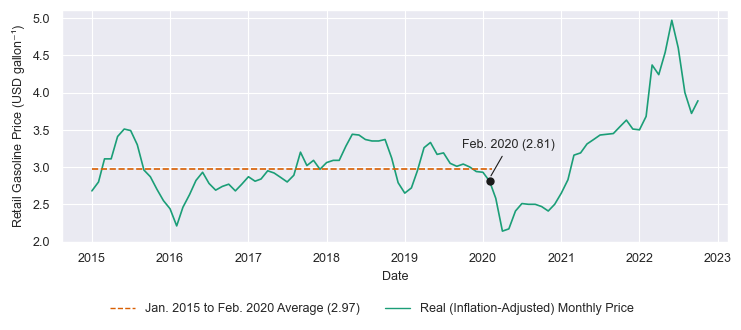

In [144]:
# National gas prices over time
# Source: https://www.eia.gov/outlooks/steo/realprices/ (downloaded 11/5/2022)
import matplotlib.dates as mdates
national_gas_prices = pd.read_csv(os.path.join(dir.p_data,'eia','Regular_Gasoline_Retail_Prices.csv'),skiprows=4)
national_gas_prices['Month'] = pd.to_datetime(national_gas_prices['Month'], format="%m/%d/%Y")
# national_gas_prices['year'] = national_gas_prices['Month'].str[-4:].astype(int)
df = national_gas_prices.query('(Month>="2015-01-01")&(Month<="2022-10-01")')
mean_2015_2020 = df.query('(Month>="2015-01-01")&(Month<="2020-02-01")')['Real Values'].mean()
mean_feb_2020 = df.query('(Month=="2020-02-01")').reset_index()['Real Values'][0]
# # df.rename(columns={'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)':'weekly_all_grades_all_form_gas_price'},inplace=True)
# # Plot
with sns.plotting_context(rc={'font.size':9, 'axes.labelsize': 9,'axes.titlesize': 9,'xtick.labelsize': 9,'ytick.labelsize': 9,'legend.fontsize': 9,'legend.title_fontsize': 9}):
    sns.axes_style(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(7.5,3),sharex=True)
    palette_col = ['k','goldenrod','royalblue']
    g1 = sns.lineplot(ax=ax,x='Month', y='Real Values',data=df, legend='auto',ci=None)
    ax.set(xlabel='Date',ylabel='Retail Gasoline Price (USD gallon'+'$\u207b$'+'$\mathregular{\u00b9}$'+')')
    ax.axhline(y=mean_2015_2020,xmin=0.045,xmax=0.645,linestyle='--',color='#d95f02')
    ax.plot(mdates.datestr2num("2020-02-01"),mean_feb_2020,'o',markersize=5,color='k')
    ax.annotate(f'Feb. 2020 ({mean_feb_2020:.2f})',xy=(mdates.datestr2num("2020-02-01"),2.85), xycoords='data',
        xytext=(mdates.datestr2num("2020-05-01"),3.3), textcoords='data',
        arrowprops=dict(arrowstyle='-',color='k'),
        fontsize='medium',va='center',ha='center')
    legend_elements = [mlines.Line2D([],[],color='#d95f02',label=f'Jan. 2015 to Feb. 2020 Average ({mean_2015_2020:.2f})',lw=1,linestyle='--'),
                       mlines.Line2D([],[],color='#1b9e77',label='Real (Inflation-Adjusted) Monthly Price',lw=1)]
    fig.legend(handles=legend_elements,loc='lower center',bbox_to_anchor=(0.5,-0.1),title=None,ncol=3,frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(dir.p_fig,'figS18_2015_22_gas_price.png'),bbox_inches='tight')

In [114]:
tract_res_pHHy_bINC[['burden','burden_22','pct_chg_TEB_20_22']].describe()

,burden,burden_22,pct_chg_TEB_20_22
count,435132.000000,435132.000000,435132.000000
mean,0.038650,0.065098,68.707635
std,0.039523,0.066409,8.246678
min,0.002865,0.004689,40.441703
25%,0.017804,0.030005,63.209081
50%,0.025193,0.042584,69.103557
75%,0.038553,0.065086,73.544718
max,0.945911,1.640323,99.366578


# Export Final Results

In [116]:
# tract-level
cols = [x for x in tract_res.columns.tolist() if (('TEB_new' in x) or ('lfc_USDpHHy' in x) or ('lce_MTCO2EpHHy' in x) or ('lfcs_USDpHHy' in x) or ('burden_svgs' in x) or ('lces_MTCO2EpHHy' in x) or ('cat_' in x)) and ('rk' not in x)]
tract_results = tract_county_index.merge(tract_res[['county_index','tract_index','mult_hh_study']+cols],how='left',on=['county_index','tract_index'],validate='one_to_one')
tract_results['county_fips'] = tract_results['county_text'].str[1:]
tract_results['tract_fips'] = tract_results['tract_text'].str[1:]
tract_results = tract_results.reindex(columns=['county_index','tract_index','county_fips','tract_fips','mult_hh_study',
                                                'lce_MTCO2EpHHy_ICEV_base_res','lce_MTCO2EpHHy_BEV_base_res','lces_MTCO2EpHHy_base_res','cat_lces_pHHy_base_res',
                                                'lfc_USDpHHy_ICEV_base_res','lfc_USDpHHy_BEV_base_res','lfcs_USDpHHy_base_res','cat_lfcs_pHHy_base_res',
                                                'TEB_newICEV_base_res','TEB_newBEV_base_res','burden_svgs_base_res','cat_burden_svgs_base_res',
                                                'biv1_cat_pHHy_base_res','biv2_cat_pHHy_base_res',
                                                'lce_MTCO2EpHHy_ICEV_base_pub','lce_MTCO2EpHHy_BEV_base_pub','lces_MTCO2EpHHy_base_pub','cat_lces_pHHy_base_pub',
                                                'lfc_USDpHHy_ICEV_base_pub','lfc_USDpHHy_BEV_base_pub','lfcs_USDpHHy_base_pub','cat_lfcs_pHHy_base_pub',
                                                'TEB_newICEV_base_pub','TEB_newBEV_base_pub','burden_svgs_base_pub','cat_burden_svgs_base_pub',
                                                'biv1_cat_pHHy_base_pub','biv2_cat_pHHy_base_pub',
                                                'lce_MTCO2EpHHy_ICEV_lwr','lce_MTCO2EpHHy_BEV_lwr','lces_MTCO2EpHHy_lwr','cat_lces_pHHy_lwr',
                                                'lfc_USDpHHy_ICEV_lwr','lfc_USDpHHy_BEV_lwr','lfcs_USDpHHy_lwr','cat_lfcs_pHHy_lwr',
                                                'TEB_newICEV_lwr','TEB_newBEV_lwr','burden_svgs_lwr','cat_burden_svgs_lwr',
                                                'biv1_cat_pHHy_lwr','biv2_cat_pHHy_lwr',
                                                'lce_MTCO2EpHHy_ICEV_upr','lce_MTCO2EpHHy_BEV_upr','lces_MTCO2EpHHy_upr','cat_lces_pHHy_upr',
                                                'lfc_USDpHHy_ICEV_upr','lfc_USDpHHy_BEV_upr','lfcs_USDpHHy_upr','cat_lfcs_pHHy_upr',
                                                'TEB_newICEV_upr','TEB_newBEV_upr','burden_svgs_upr','cat_burden_svgs_upr',
                                                'biv1_cat_pHHy_upr','biv2_cat_pHHy_upr'])
tract_results.to_csv(os.path.join(dir.p_out,'final_results','tract_results.csv'),index=False)
# metadata
tract_results_metadata = {'column_name_portion':['_index',
                                                '_fips',
                                                'mult_hh_study',
                                                'lce_MTCO2EpHHy',
                                                'lces_MTCO2EpHHy',
                                                'cat_lces_pHHy',
                                                'lfc_USDpHHy',
                                                'lfcs_USDpHHy',
                                                'cat_lfcs_pHHy',
                                                'TEB',
                                                'burden_svgs',
                                                'cat_burden_svgs',
                                                'biv1_cat_pHHy',
                                                'biv2_cat_pHHy',
                                                'ICEV',
                                                'BEV',
                                                'base_res',
                                                'base_pub',
                                                'lwr',
                                                'upr'],
                            'description':['simple index used to join files',
                                                'county/tract FIPS code',
                                                'portion of households in the census tract out of all households included in the study (column sum = 1)',
                                                'life cycle GHG emissions in metric tons of CO2e per household-year (MTCO2EpHHy)',
                                                'life cycle GHG emissions savings (i.e., difference b/w ICEV and BEV) in metric tons of CO2e per household-year (MTCO2EpHHy)',
                                                'categorization of life cycle GHG emissions savings (with units per household-year)',
                                                'lifetime fuel costs in U.S. dollars per household-year (USDpHHy)',
                                                'lifetime fuel cost savings (i.e., difference b/w ICEV and BEV) in U.S. dollars per household-year (USDpHHy)',
                                                'categorization of lifetime fuel cost savings (with units per household-year)',
                                                'transportation energy burden',
                                                'transportation energy burden savings (i.e., difference b/w ICEV and BEV)',
                                                'categorization of transportation energy burden savings',
                                                'bivariate combination 1: life cycle GHG emissions and lifetime fuel cost savings (with units per household-year)',
                                                'bivariate combination 2: life cycle GHG emissions and energy burden savings (with units per household-year)',
                                                'internal combustion engine vehicle',
                                                'battery electric vehicle',
                                                'baseline-residential charging scenario',
                                                'baseline-public charging scenario',
                                                'worst-case for BEV scenario',
                                                'best-case for BEV scenario']}
tract_results_metadata_df = pd.DataFrame(data=tract_results_metadata)
tract_results_metadata_df.to_csv(os.path.join(dir.p_out,'final_results','tract_results_metadata.csv'),index=False)

In [117]:
# tract income bin-level
cols = [x for x in tract_res_pHHy_bINC.columns.tolist() if ('TEB_new' in x) and ('cat' not in x)]
tract_bINC_results = tract_county_index.merge(tract_res_pHHy_bINC[['county_index','tract_index','ami_bin']+cols],how='left',on=['county_index','tract_index'],validate='one_to_many')
tract_bINC_results['county_fips'] = tract_bINC_results['county_text'].str[1:]
tract_bINC_results['tract_fips'] = tract_bINC_results['tract_text'].str[1:]
tract_bINC_results = tract_bINC_results.reindex(columns=['county_index','tract_index','county_fips','tract_fips','ami_bin',
                                                        'TEB_newICEV_base_res','TEB_newBEV_base_res',
                                                        'TEB_newICEV_base_pub','TEB_newBEV_base_pub',
                                                        'TEB_newICEV_lwr','TEB_newBEV_lwr',
                                                        'TEB_newICEV_upr','TEB_newBEV_upr'])
tract_bINC_results.to_csv(os.path.join(dir.p_out,'final_results','tract_incomebin_results.csv'),index=False)

# metadata
tract_results_metadata = {'column_name_portion':['_index',
                                                '_fips',
                                                'ami_bin',
                                                'TEB',
                                                'ICEV',
                                                'BEV',
                                                'base_res',
                                                'base_pub',
                                                'lwr',
                                                'upr'],
                            'description':['simple index used to join files',
                                                'county/tract FIPS code',
                                                'area median income (AMI) bin (0 = 0-30% AMI, 1 = 30-60% AMI, 2 = 60-80% AMI, 3 = 80-100% AMI, 4 = 100-150% AMI, 5 = 150-200% AMI, 6 = 200%+ AMI)',
                                                'transportation energy burden',
                                                'internal combustion engine vehicle',
                                                'battery electric vehicle',
                                                'baseline-residential charging scenario',
                                                'baseline-public charging scenario',
                                                'worst-case for BEV scenario',
                                                'best-case for BEV scenario']}
tract_results_metadata_df = pd.DataFrame(data=tract_results_metadata)
tract_results_metadata_df.to_csv(os.path.join(dir.p_out,'final_results','tract_incomebin_results_metadata.csv'),index=False)

# References

Borlaug B, Salisbury S, Gerdes M, Muratori M. Levelized Cost of Charging Electric Vehicles in the United States. Joule. 2020 Jul 15;4(7):1470–85. 

Woody M, Vaishnav P, Keoleian GA, Kleine RD, Kim HC, Anderson JE, et al. The role of pickup truck electrification in the decarbonization of light-duty vehicles. Environ Res Lett. 2022 Mar;17(3):034031.

Woody M, Vaishnav P, Keoleian GA, Kleine RD, Kim HC, Anderson JE, et al. Corrigendum: The role of pickup truck electrification in the decarbonization of light-duty vehicles (2022 Environ. Res. Lett. 17 034031). Environ Res Lett. 2022 Jul;17(8):089501.

Yan Zhou, Spencer Aeschliman, David Gohlke. Affordability of Household Transportation Fuel Costs by Region and Socioeconomic Factors [Internet]. Argonne, IL: Argonne National Laboratory (ANL); 2020 Dec. Available from: https://doi.org/10.2172/1760477
